Overbooking 5, Just DP, Simulation is the Very bottom code cell

Starting airline ticket dynamic programming solution...
Daily discount factor: 0.999534463400608
Calculating terminal values...
Starting backward induction with corrected transition probabilities...
Processing day 350...
Processing day 300...
Processing day 250...
Processing day 200...
Processing day 150...
Processing day 100...
Processing day 50...
Processing day 0...
Dynamic programming solution completed in 169.18 seconds
Creating fixed visualizations...
Fixed visualizations created successfully!
Expected profit from DP solution: $41886.16

AIRLINE TICKET PRICING OPTIMIZATION RESULTS
Final Expected Discounted Profit: $41886.16

Note: Simulation statistics (passenger bumping, actual revenue) have been removed
Generated visualizations: coach_price_evolution_by_fill.png, fc_price_evolution_by_fill.png,
                          coach_price_heatmap_fixed.png, fc_price_heatmap_fixed.png


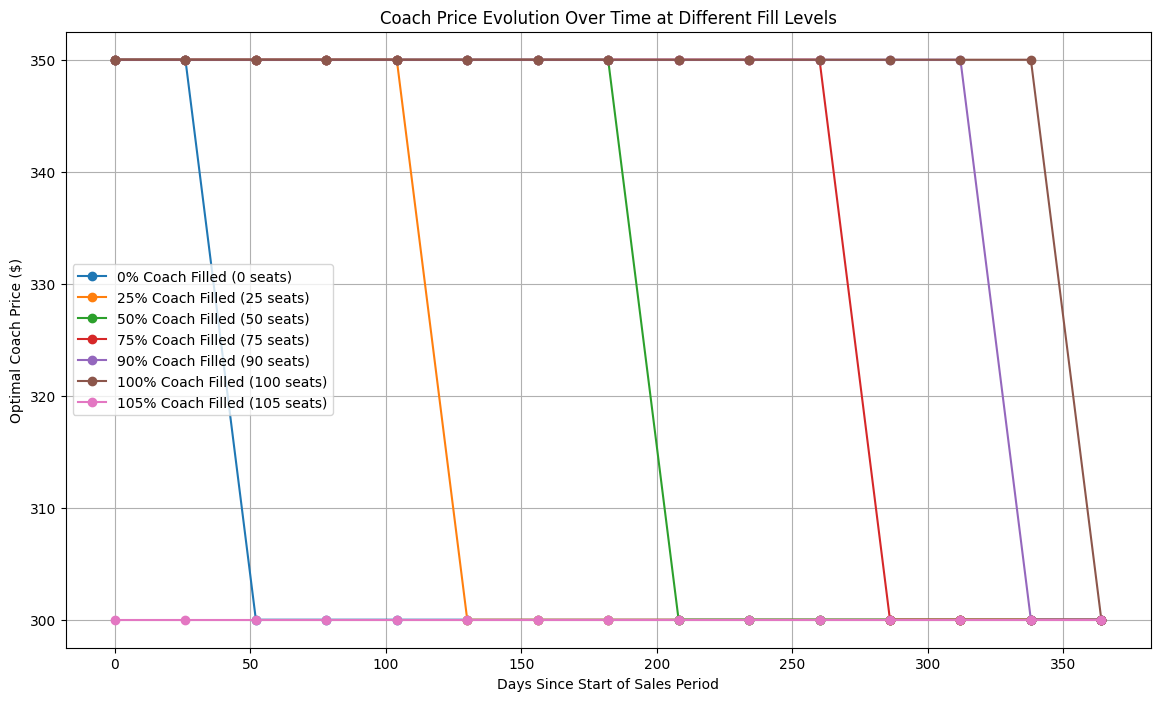

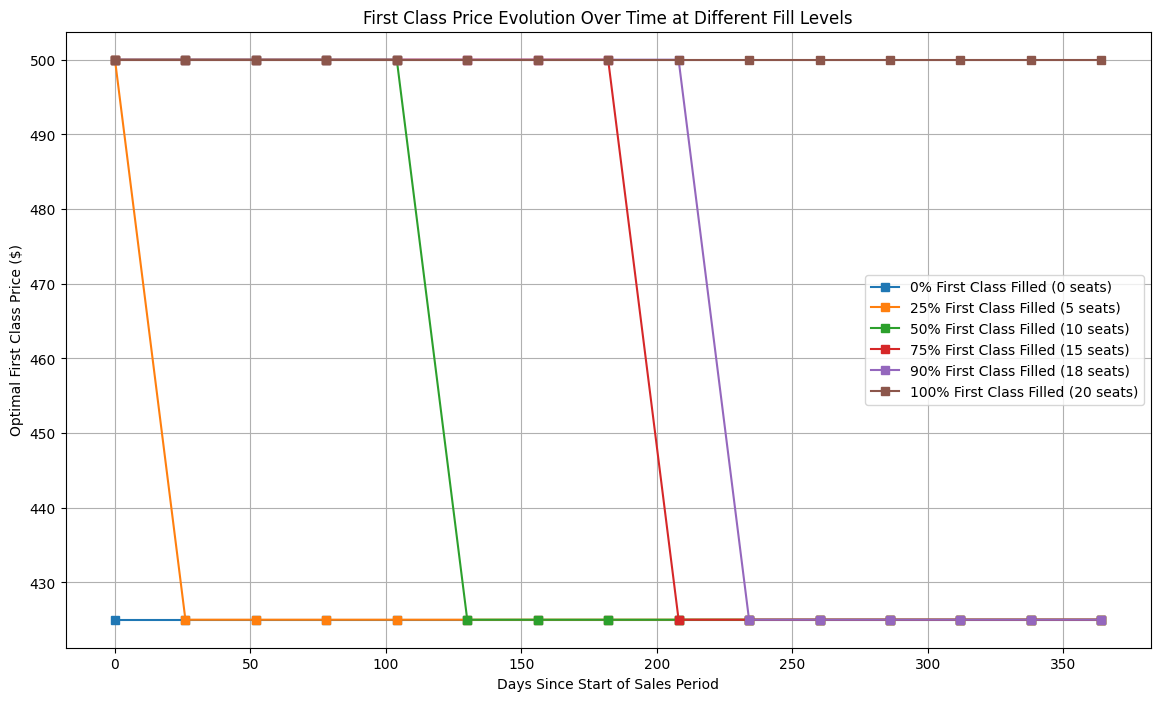

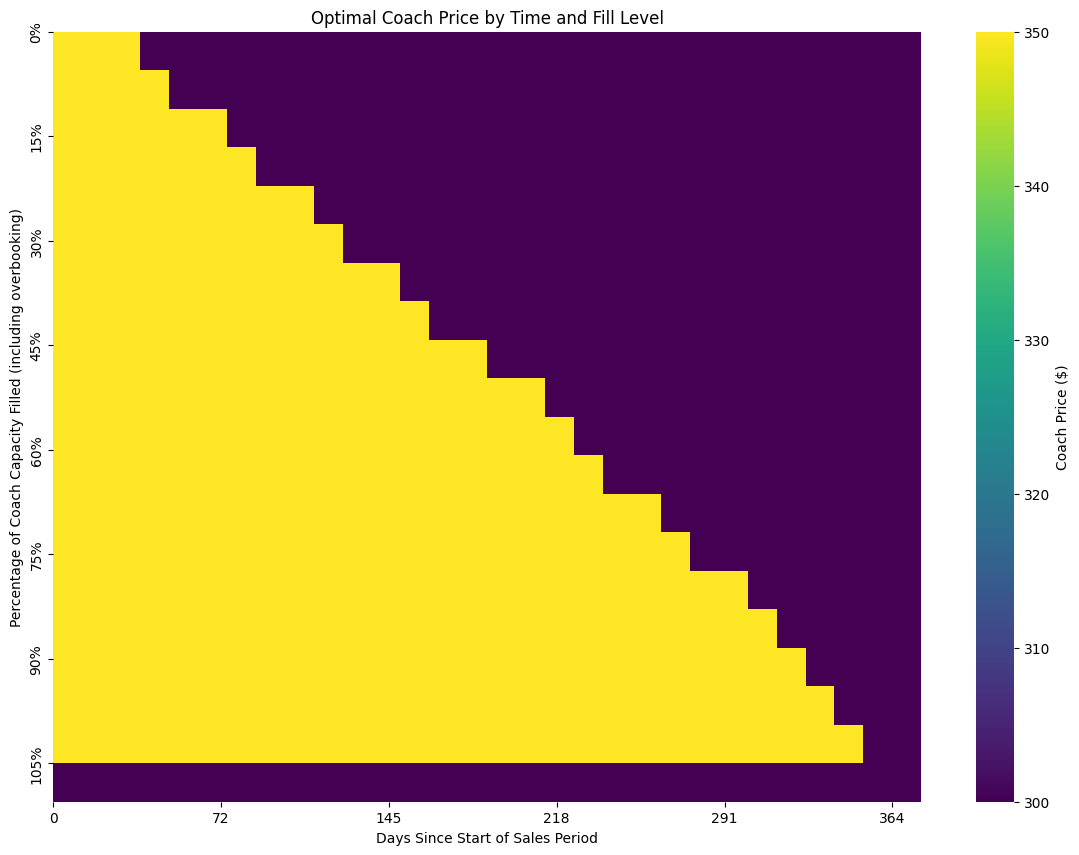

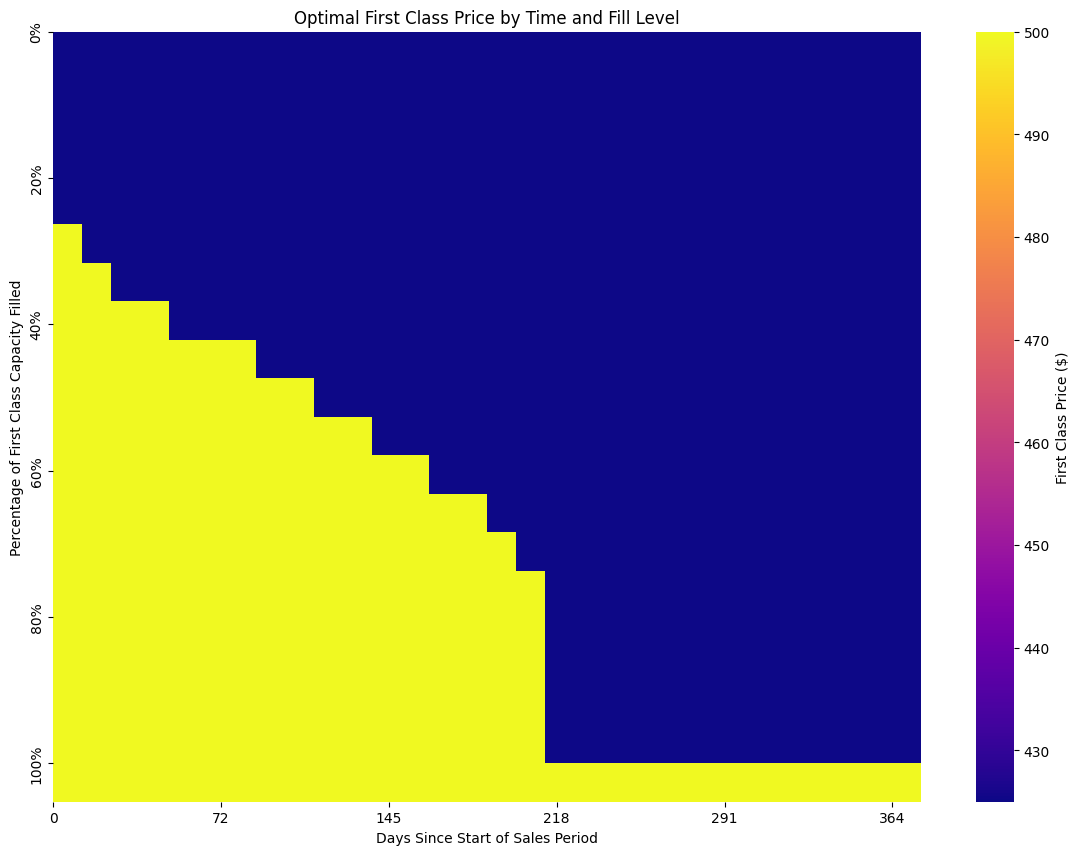

In [2]:
import numpy as np
from scipy.stats import binom
import matplotlib.pyplot as plt
import seaborn as sns
import time

def airline_dp_solution():
    """
    Solve the airline ticket pricing problem using dynamic programming,
    with corrected transition probability calculations and fixed visualizations.
    Enforces high price for first class when it's sold out.
    """
    print("Starting airline ticket dynamic programming solution...")
    start_time = time.time()
    
    # Step 1: Initialize Parameters
    # Seat configuration
    coach_seats = 100
    first_class_seats = 20
    max_coach_overbooking = 5
    max_coach_tickets = coach_seats + max_coach_overbooking  # 105
    
    # Time horizon
    days_until_takeoff = 365
    
    # Pricing options
    coach_prices = [300, 350]
    first_class_prices = [425, 500]
    
    # Sale probabilities
    coach_sale_prob = {
        300: 0.65,
        350: 0.30
    }
    # When first class is sold out
    coach_sale_prob_fc_sold_out = {
        300: 0.68,
        350: 0.33
    }
    first_class_sale_prob = {
        425: 0.08,
        500: 0.04
    }
    
    # Show-up probabilities
    coach_show_prob = 0.95
    first_class_show_prob = 0.97
    
    # Overbooking costs
    cost_bump_to_first_class = 50
    cost_bump_off_plane = 425
    
    # Discount rate
    annual_discount_rate = 0.17
    daily_discount_factor = 1 / (1 + annual_discount_rate / 365)
    
    print(f"Daily discount factor: {daily_discount_factor}")
    
    # Initialize state values and policy
    V = np.zeros((max_coach_tickets + 1, first_class_seats + 1, days_until_takeoff + 1))
    policy = np.zeros((max_coach_tickets + 1, first_class_seats + 1, days_until_takeoff + 1), dtype=int)
    
    # Step 2: Terminal day costs (day 365)
    print("Calculating terminal values...")
    
    # Terminal cost statistics
    terminal_cost_data = []
    
    for coach_sold in range(max_coach_tickets + 1):
        for fc_sold in range(first_class_seats + 1):
            # Calculate expected overbooking costs using binomial distribution
            cost = 0
            expected_bumped_to_fc = 0
            expected_bumped_off = 0
            
            # Generate all possible combinations of show-ups
            for coach_show in range(coach_sold + 1):
                coach_prob = binom.pmf(coach_show, coach_sold, coach_show_prob)
                
                for fc_show in range(fc_sold + 1):
                    fc_prob = binom.pmf(fc_show, fc_sold, first_class_show_prob)
                    
                    # Calculate probability of this exact scenario
                    scenario_prob = coach_prob * fc_prob
                    
                    # If coach is overbooked
                    if coach_show > coach_seats:
                        # Number of passengers to be bumped
                        bumped = coach_show - coach_seats
                        
                        # Available first class seats
                        available_fc = max(0, first_class_seats - fc_show)
                        
                        # Bump to first class if possible, otherwise off the plane
                        bumped_to_fc = min(bumped, available_fc)
                        bumped_off = bumped - bumped_to_fc
                        
                        # Track expected bumping for statistics
                        expected_bumped_to_fc += scenario_prob * bumped_to_fc
                        expected_bumped_off += scenario_prob * bumped_off
                        
                        # Calculate costs
                        scenario_cost = (bumped_to_fc * cost_bump_to_first_class) + (bumped_off * cost_bump_off_plane)
                        cost += scenario_prob * scenario_cost
            
            # Store terminal cost data for visualization
            if coach_sold >= 95:  # Only store for near-capacity situations
                terminal_cost_data.append({
                    'coach_sold': coach_sold,
                    'fc_sold': fc_sold,
                    'expected_cost': cost,
                    'expected_bumped_to_fc': expected_bumped_to_fc,
                    'expected_bumped_off': expected_bumped_off
                })
                
            V[coach_sold, fc_sold, -1] = -cost  # Negative because costs reduce value
    
    # Step 3: Backward induction - CORRECTED IMPLEMENTATION
    print("Starting backward induction with corrected transition probabilities...")
    
    for day in range(days_until_takeoff - 1, -1, -1):
        if day % 50 == 0:
            print(f"Processing day {day}...")
            
        for coach_sold in range(max_coach_tickets + 1):
            for fc_sold in range(first_class_seats + 1):
                # Skip impossible states
                if coach_sold > max_coach_tickets or fc_sold > first_class_seats:
                    continue
                
                # Special handling for the case when first class is full
                if fc_sold == first_class_seats:
                    # When first class is sold out, we always use high price (index 1)
                    # We only need to decide on coach price
                    best_value = float('-inf')
                    best_action = -1
                    
                    # Try both coach prices with high FC price
                    for c_idx, coach_price in enumerate(coach_prices):
                        action = c_idx * 2 + 1  # Force high first class price (index 1)
                        
                        # Check coach availability
                        coach_available = coach_sold < max_coach_tickets
                        
                        # Calculate expected value
                        expected_revenue = 0
                        if coach_available:
                            # Use the increased probability when FC is sold out
                            c_prob = coach_sale_prob_fc_sold_out[coach_price]
                            expected_revenue += c_prob * coach_price
                        
                        # Calculate expected future value
                        expected_future_value = 0
                        
                        if not coach_available:
                            # If coach is also full, just move to next day
                            expected_future_value = V[coach_sold, fc_sold, day + 1]
                        else:
                            # Calculate probabilities for future states
                            prob_no_sale = 1 - c_prob
                            expected_future_value += prob_no_sale * V[coach_sold, fc_sold, day + 1]
                            
                            if coach_available:
                                expected_future_value += c_prob * V[coach_sold + 1, fc_sold, day + 1]
                        
                        # Calculate total value
                        current_value = expected_revenue + daily_discount_factor * expected_future_value
                        
                        if current_value > best_value:
                            best_value = current_value
                            best_action = action
                    
                    # Store best value and action
                    V[coach_sold, fc_sold, day] = best_value
                    policy[coach_sold, fc_sold, day] = best_action
                else:
                    # Regular processing for non-full first class
                    # Initialize for this state
                    best_value = float('-inf')
                    best_action = 0
                    
                    # Check availability
                    coach_available = coach_sold < max_coach_tickets
                    fc_available = fc_sold < first_class_seats
                    
                    # If both are sold out, just move to next day
                    if not coach_available and not fc_available:
                        V[coach_sold, fc_sold, day] = daily_discount_factor * V[coach_sold, fc_sold, day + 1]
                        continue
                    
                    # Try all pricing combinations (actions)
                    for c_idx, coach_price in enumerate(coach_prices):
                        for f_idx, fc_price in enumerate(first_class_prices):
                            action = c_idx * 2 + f_idx
                            
                            # CORRECTED: Calculate expected value properly without double-counting
                            
                            # Determine probabilities based on availability and pricing
                            c_prob = 0  # Coach sale probability
                            if coach_available:
                                if fc_sold == first_class_seats:  # This case is handled separately now
                                    c_prob = coach_sale_prob_fc_sold_out[coach_price]
                                else:
                                    c_prob = coach_sale_prob[coach_price]
                                    
                            f_prob = 0  # First class sale probability
                            if fc_available:
                                f_prob = first_class_sale_prob[fc_price]
                            
                            # Calculate expected immediate revenue
                            expected_revenue = 0
                            if coach_available:
                                expected_revenue += c_prob * coach_price
                            if fc_available:
                                expected_revenue += f_prob * fc_price
                            
                            # Calculate expected future value considering all possible combinations
                            # NOTE: We calculate this ONCE, not separately for each ticket type
                            expected_future_value = 0
                            
                            # Case 1: Neither ticket sells
                            prob_neither = (1 - c_prob if coach_available else 1) * (1 - f_prob if fc_available else 1)
                            expected_future_value += prob_neither * V[coach_sold, fc_sold, day + 1]
                            
                            # Case 2: Only coach sells
                            if coach_available:
                                prob_only_coach = c_prob * (1 - f_prob if fc_available else 1)
                                expected_future_value += prob_only_coach * V[coach_sold + 1, fc_sold, day + 1]
                            
                            # Case 3: Only first class sells
                            if fc_available:
                                prob_only_fc = (1 - c_prob if coach_available else 1) * f_prob
                                expected_future_value += prob_only_fc * V[coach_sold, fc_sold + 1, day + 1]
                            
                            # Case 4: Both sell
                            if coach_available and fc_available:
                                prob_both = c_prob * f_prob
                                expected_future_value += prob_both * V[coach_sold + 1, fc_sold + 1, day + 1]
                            
                            # Total expected value = immediate revenue + discounted future value
                            current_value = expected_revenue + daily_discount_factor * expected_future_value
                            
                            # Update if this is the best action
                            if current_value > best_value:
                                best_value = current_value
                                best_action = action
                    
                    # Store best value and action
                    V[coach_sold, fc_sold, day] = best_value
                    policy[coach_sold, fc_sold, day] = best_action
    
    elapsed_time = time.time() - start_time
    print(f"Dynamic programming solution completed in {elapsed_time:.2f} seconds")
    
    # Create fixed visualizations for price policy
    def create_fixed_visualizations():
        """
        Create visualizations with properly fixed axes showing pricing strategy
        evolution over time.
        """
        print("Creating fixed visualizations...")
        
        # Helper function to get prices from action
        def get_prices(action):
            coach_idx = action // 2
            fc_idx = action % 2
            return coach_prices[coach_idx], first_class_prices[fc_idx]
        
        # 1. Price evolution over time at different inventory levels
        days_to_check = np.linspace(0, days_until_takeoff-1, 15, dtype=int)  # 15 time points
        
        # Define inventory levels to check (percentage of capacity filled)
        # For coach: 0%, 25%, 50%, 75%, 90%, 100%, 105% (max with overbooking)
        # For first class: 0%, 25%, 50%, 75%, 90%, 100% (max capacity)
        coach_fill_levels = [0.0, 0.25, 0.50, 0.75, 0.90, 1.0, 1.05]
        fc_fill_levels = [0.0, 0.25, 0.50, 0.75, 0.90, 1.0]
        
        # Prepare arrays for the data
        coach_price_data = np.zeros((len(coach_fill_levels), len(days_to_check)))
        fc_price_data = np.zeros((len(fc_fill_levels), len(days_to_check)))
        
        # Fill the arrays with pricing data for coach
        for i, fill_level in enumerate(coach_fill_levels):
            coach_sold = min(int(fill_level * coach_seats), max_coach_tickets)
            fc_sold = 0  # Start with no first class tickets sold
            
            for j, day in enumerate(days_to_check):
                action = policy[coach_sold, fc_sold, day]
                coach_price, _ = get_prices(action)
                coach_price_data[i, j] = coach_price
        
        # Fill the arrays with pricing data for first class
        for i, fill_level in enumerate(fc_fill_levels):
            fc_sold = min(int(fill_level * first_class_seats), first_class_seats)
            coach_sold = 0  # Start with no coach tickets sold
            
            for j, day in enumerate(days_to_check):
                action = policy[coach_sold, fc_sold, day]
                _, fc_price = get_prices(action)
                fc_price_data[i, j] = fc_price
        
        # Plot coach price evolution
        plt.figure(figsize=(14, 8))
        for i, fill_level in enumerate(coach_fill_levels):
            plt.plot(days_to_check, coach_price_data[i], 'o-', 
                    label=f"{int(fill_level*100)}% Coach Filled ({int(fill_level*coach_seats)} seats)")
        
        plt.xlabel('Days Since Start of Sales Period')
        plt.ylabel('Optimal Coach Price ($)')
        plt.title('Coach Price Evolution Over Time at Different Fill Levels')
        plt.grid(True)
        plt.legend()
        plt.savefig('coach_price_evolution_by_fill.png')
        
        # Plot first class price evolution
        plt.figure(figsize=(14, 8))
        for i, fill_level in enumerate(fc_fill_levels):
            plt.plot(days_to_check, fc_price_data[i], 's-', 
                    label=f"{int(fill_level*100)}% First Class Filled ({int(fill_level*first_class_seats)} seats)")
        
        plt.xlabel('Days Since Start of Sales Period')
        plt.ylabel('Optimal First Class Price ($)')
        plt.title('First Class Price Evolution Over Time at Different Fill Levels')
        plt.grid(True)
        plt.legend()
        plt.savefig('fc_price_evolution_by_fill.png')
        
        # 2. Create price heatmaps with PROPERLY FIXED AXES
        
        # For days, use evenly spaced points from 0 to days_until_takeoff-1
        days_points = np.linspace(0, days_until_takeoff-1, 30, dtype=int)
        
        # For coach fill levels, use points from 0% to 105% (accounting for overbooking)
        coach_fill_points = np.linspace(0, max_coach_tickets/coach_seats, 20)
        
        # For first class fill levels, use points from 0% to 100%
        fc_fill_points = np.linspace(0, 1.0, 20)
        
        # Arrays for heatmaps
        coach_heatmap = np.zeros((len(coach_fill_points), len(days_points)))
        fc_heatmap = np.zeros((len(fc_fill_points), len(days_points)))
        
        # Fill the coach heatmap data
        for i, fill in enumerate(coach_fill_points):
            coach_sold = min(int(fill * coach_seats), max_coach_tickets)
            fc_sold = 0  # Keep first class empty to isolate coach effect
            
            for j, day in enumerate(days_points):
                action = policy[coach_sold, fc_sold, day]
                coach_price, _ = get_prices(action)
                coach_heatmap[i, j] = coach_price
        
        # Fill the first class heatmap data
        for i, fill in enumerate(fc_fill_points):
            fc_sold = min(int(fill * first_class_seats), first_class_seats)
            coach_sold = 0  # Keep coach empty to isolate first class effect
            
            for j, day in enumerate(days_points):
                action = policy[coach_sold, fc_sold, day]
                _, fc_price = get_prices(action)
                fc_heatmap[i, j] = fc_price
        
        # Create coach price heatmap with PROPERLY FIXED AXES
        plt.figure(figsize=(14, 10))
        
        # Create the heatmap without automatic tick labels
        ax = sns.heatmap(coach_heatmap, cmap='viridis', cbar_kws={'label': 'Coach Price ($)'})
        
        # Explicitly set the tick locations and labels
        x_ticks = np.linspace(0, len(days_points)-1, 6)  # 6 evenly spaced ticks
        x_labels = [f"{int(d)}" for d in np.linspace(0, days_until_takeoff-1, 6)]  # 0, 73, 146, 219, 292, 365
        
        y_ticks = np.linspace(0, len(coach_fill_points)-1, 8)  # 8 evenly spaced ticks
        y_labels = [f"{int(p)}%" for p in np.linspace(0, 105, 8)]  # 0%, 15%, 30%, ..., 105%
        
        # Set the tick positions and labels
        plt.xticks(x_ticks, x_labels)
        plt.yticks(y_ticks, y_labels)
        
        plt.xlabel('Days Since Start of Sales Period')
        plt.ylabel('Percentage of Coach Capacity Filled (including overbooking)')
        plt.title('Optimal Coach Price by Time and Fill Level')
        plt.savefig('coach_price_heatmap_fixed.png')
        
        # Create first class price heatmap with PROPERLY FIXED AXES
        plt.figure(figsize=(14, 10))
        
        # Create the heatmap without automatic tick labels
        ax = sns.heatmap(fc_heatmap, cmap='plasma', cbar_kws={'label': 'First Class Price ($)'})
        
        # Explicitly set the tick locations and labels
        x_ticks = np.linspace(0, len(days_points)-1, 6)  # 6 evenly spaced ticks
        x_labels = [f"{int(d)}" for d in np.linspace(0, days_until_takeoff-1, 6)]  # 0, 73, 146, 219, 292, 365
        
        y_ticks = np.linspace(0, len(fc_fill_points)-1, 6)  # 6 evenly spaced ticks
        y_labels = [f"{int(p)}%" for p in np.linspace(0, 100, 6)]  # 0%, 20%, 40%, ..., 100%
        
        # Set the tick positions and labels
        plt.xticks(x_ticks, x_labels)
        plt.yticks(y_ticks, y_labels)
        
        plt.xlabel('Days Since Start of Sales Period')
        plt.ylabel('Percentage of First Class Capacity Filled')
        plt.title('Optimal First Class Price by Time and Fill Level')
        plt.savefig('fc_price_heatmap_fixed.png')
        
        print("Fixed visualizations created successfully!")
    
    # Create fixed visualizations
    create_fixed_visualizations()
    
    # Get the expected profit from DP solution
    expected_profit = V[0, 0, 0]
    print(f"Expected profit from DP solution: ${expected_profit:.2f}")
    
    return {
        'expected_profit': expected_profit,
        'value_function': V,
        'policy': policy
    }

# Run the solution
results = airline_dp_solution()

# Output the final answer
print("\n" + "="*50)
print("AIRLINE TICKET PRICING OPTIMIZATION RESULTS")
print("="*50)
print(f"Final Expected Discounted Profit: ${results['expected_profit']:.2f}")
print("="*50)
print("\nNote: Simulation statistics (passenger bumping, actual revenue) have been removed")
print("Generated visualizations: coach_price_evolution_by_fill.png, fc_price_evolution_by_fill.png,")
print("                          coach_price_heatmap_fixed.png, fc_price_heatmap_fixed.png")

Overbooking 6-15 (Just DP, Simulation for optimal overbooking = 9) is 2nd bottom code cell.

In [12]:
import numpy as np
from scipy.stats import binom
import matplotlib.pyplot as plt
import seaborn as sns
import time

def airline_dp_solution(max_coach_overbooking):
    """
    Solve the airline ticket pricing problem using dynamic programming,
    with corrected transition probability calculations and fixed visualizations.
    Enforces high price for first class when it's sold out.
    """
    print(f"Starting airline ticket dynamic programming solution with max_coach_overbooking = {max_coach_overbooking}...")
    start_time = time.time()
    
    # Step 1: Initialize Parameters
    # Seat configuration
    coach_seats = 100
    first_class_seats = 20
    max_coach_tickets = coach_seats + max_coach_overbooking
    
    # Time horizon
    days_until_takeoff = 365
    
    # Pricing options
    coach_prices = [300, 350]
    first_class_prices = [425, 500]
    
    # Sale probabilities
    coach_sale_prob = {
        300: 0.65,
        350: 0.30
    }
    # When first class is sold out
    coach_sale_prob_fc_sold_out = {
        300: 0.68,
        350: 0.33
    }
    first_class_sale_prob = {
        425: 0.08,
        500: 0.04
    }
    
    # Show-up probabilities
    coach_show_prob = 0.95
    first_class_show_prob = 0.97
    
    # Overbooking costs
    cost_bump_to_first_class = 50
    cost_bump_off_plane = 425
    
    # Discount rate
    annual_discount_rate = 0.17
    daily_discount_factor = 1 / (1 + annual_discount_rate / 365)
    
    print(f"Daily discount factor: {daily_discount_factor}")
    
    # Initialize state values and policy
    V = np.zeros((max_coach_tickets + 1, first_class_seats + 1, days_until_takeoff + 1))
    policy = np.zeros((max_coach_tickets + 1, first_class_seats + 1, days_until_takeoff + 1), dtype=int)
    
    # Step 2: Terminal day costs (day 365)
    print("Calculating terminal values...")
    
    # Terminal cost statistics
    terminal_cost_data = []
    
    for coach_sold in range(max_coach_tickets + 1):
        for fc_sold in range(first_class_seats + 1):
            # Calculate expected overbooking costs using binomial distribution
            cost = 0
            expected_bumped_to_fc = 0
            expected_bumped_off = 0
            
            # Generate all possible combinations of show-ups
            for coach_show in range(coach_sold + 1):
                coach_prob = binom.pmf(coach_show, coach_sold, coach_show_prob)
                
                for fc_show in range(fc_sold + 1):
                    fc_prob = binom.pmf(fc_show, fc_sold, first_class_show_prob)
                    
                    # Calculate probability of this exact scenario
                    scenario_prob = coach_prob * fc_prob
                    
                    # If coach is overbooked
                    if coach_show > coach_seats:
                        # Number of passengers to be bumped
                        bumped = coach_show - coach_seats
                        
                        # Available first class seats
                        available_fc = max(0, first_class_seats - fc_show)
                        
                        # Bump to first class if possible, otherwise off the plane
                        bumped_to_fc = min(bumped, available_fc)
                        bumped_off = bumped - bumped_to_fc
                        
                        # Track expected bumping for statistics
                        expected_bumped_to_fc += scenario_prob * bumped_to_fc
                        expected_bumped_off += scenario_prob * bumped_off
                        
                        # Calculate costs
                        scenario_cost = (bumped_to_fc * cost_bump_to_first_class) + (bumped_off * cost_bump_off_plane)
                        cost += scenario_prob * scenario_cost
            
            # Store terminal cost data for visualization
            if coach_sold >= 95:  # Only store for near-capacity situations
                terminal_cost_data.append({
                    'coach_sold': coach_sold,
                    'fc_sold': fc_sold,
                    'expected_cost': cost,
                    'expected_bumped_to_fc': expected_bumped_to_fc,
                    'expected_bumped_off': expected_bumped_off
                })
                
            V[coach_sold, fc_sold, -1] = -cost  # Negative because costs reduce value
    
    # Step 3: Backward induction - CORRECTED IMPLEMENTATION
    print("Starting backward induction with corrected transition probabilities...")
    
    for day in range(days_until_takeoff - 1, -1, -1):
        if day % 50 == 0:
            print(f"Processing day {day}...")
            
        for coach_sold in range(max_coach_tickets + 1):
            for fc_sold in range(first_class_seats + 1):
                # Skip impossible states
                if coach_sold > max_coach_tickets or fc_sold > first_class_seats:
                    continue
                
                # Special handling for the case when first class is full
                if fc_sold == first_class_seats:
                    # When first class is sold out, we always use high price (index 1)
                    # We only need to decide on coach price
                    best_value = float('-inf')
                    best_action = -1
                    
                    # Try both coach prices with high FC price
                    for c_idx, coach_price in enumerate(coach_prices):
                        action = c_idx * 2 + 1  # Force high first class price (index 1)
                        
                        # Check coach availability
                        coach_available = coach_sold < max_coach_tickets
                        
                        # Calculate expected value
                        expected_revenue = 0
                        if coach_available:
                            # Use the increased probability when FC is sold out
                            c_prob = coach_sale_prob_fc_sold_out[coach_price]
                            expected_revenue += c_prob * coach_price
                        
                        # Calculate expected future value
                        expected_future_value = 0
                        
                        if not coach_available:
                            # If coach is also full, just move to next day
                            expected_future_value = V[coach_sold, fc_sold, day + 1]
                        else:
                            # Calculate probabilities for future states
                            prob_no_sale = 1 - c_prob
                            expected_future_value += prob_no_sale * V[coach_sold, fc_sold, day + 1]
                            
                            if coach_available:
                                expected_future_value += c_prob * V[coach_sold + 1, fc_sold, day + 1]
                        
                        # Calculate total value
                        current_value = expected_revenue + daily_discount_factor * expected_future_value
                        
                        if current_value > best_value:
                            best_value = current_value
                            best_action = action
                    
                    # Store best value and action
                    V[coach_sold, fc_sold, day] = best_value
                    policy[coach_sold, fc_sold, day] = best_action
                else:
                    # Regular processing for non-full first class
                    # Initialize for this state
                    best_value = float('-inf')
                    best_action = 0
                    
                    # Check availability
                    coach_available = coach_sold < max_coach_tickets
                    fc_available = fc_sold < first_class_seats
                    
                    # If both are sold out, just move to next day
                    if not coach_available and not fc_available:
                        V[coach_sold, fc_sold, day] = daily_discount_factor * V[coach_sold, fc_sold, day + 1]
                        continue
                    
                    # Try all pricing combinations (actions)
                    for c_idx, coach_price in enumerate(coach_prices):
                        for f_idx, fc_price in enumerate(first_class_prices):
                            action = c_idx * 2 + f_idx
                            
                            # CORRECTED: Calculate expected value properly without double-counting
                            
                            # Determine probabilities based on availability and pricing
                            c_prob = 0  # Coach sale probability
                            if coach_available:
                                if fc_sold == first_class_seats:  # This case is handled separately now
                                    c_prob = coach_sale_prob_fc_sold_out[coach_price]
                                else:
                                    c_prob = coach_sale_prob[coach_price]
                                    
                            f_prob = 0  # First class sale probability
                            if fc_available:
                                f_prob = first_class_sale_prob[fc_price]
                            
                            # Calculate expected immediate revenue
                            expected_revenue = 0
                            if coach_available:
                                expected_revenue += c_prob * coach_price
                            if fc_available:
                                expected_revenue += f_prob * fc_price
                            
                            # Calculate expected future value considering all possible combinations
                            # NOTE: We calculate this ONCE, not separately for each ticket type
                            expected_future_value = 0
                            
                            # Case 1: Neither ticket sells
                            prob_neither = (1 - c_prob if coach_available else 1) * (1 - f_prob if fc_available else 1)
                            expected_future_value += prob_neither * V[coach_sold, fc_sold, day + 1]
                            
                            # Case 2: Only coach sells
                            if coach_available:
                                prob_only_coach = c_prob * (1 - f_prob if fc_available else 1)
                                expected_future_value += prob_only_coach * V[coach_sold + 1, fc_sold, day + 1]
                            
                            # Case 3: Only first class sells
                            if fc_available:
                                prob_only_fc = (1 - c_prob if coach_available else 1) * f_prob
                                expected_future_value += prob_only_fc * V[coach_sold, fc_sold + 1, day + 1]
                            
                            # Case 4: Both sell
                            if coach_available and fc_available:
                                prob_both = c_prob * f_prob
                                expected_future_value += prob_both * V[coach_sold + 1, fc_sold + 1, day + 1]
                            
                            # Total expected value = immediate revenue + discounted future value
                            current_value = expected_revenue + daily_discount_factor * expected_future_value
                            
                            # Update if this is the best action
                            if current_value > best_value:
                                best_value = current_value
                                best_action = action
                    
                    # Store best value and action
                    V[coach_sold, fc_sold, day] = best_value
                    policy[coach_sold, fc_sold, day] = best_action
    
    elapsed_time = time.time() - start_time
    print(f"Dynamic programming solution completed in {elapsed_time:.2f} seconds")
    
    # Get the expected profit from DP solution
    expected_profit = V[0, 0, 0]
    print(f"Expected profit from DP solution with overbooking={max_coach_overbooking}: ${expected_profit:.2f}")
    
    return {
        'expected_profit': expected_profit,
        'value_function': V,
        'policy': policy,
        'max_coach_overbooking': max_coach_overbooking,
        'terminal_cost_data': terminal_cost_data
    }

# Run the solution for different overbooking levels
overbooking_levels = range(6, 16)  # 6 to 15 inclusive
results = []

for level in overbooking_levels:
    result = airline_dp_solution(level)
    results.append(result)

# Output the results
print("\n" + "="*70)
print("AIRLINE TICKET PRICING OPTIMIZATION RESULTS BY OVERBOOKING LEVEL")
print("="*70)
print(f"{'Overbooking Level':<20} {'Expected Profit ($)':<20}")
print("-"*70)

# Extract data for visualizations
profits = []
overbooking = []

for result in results:
    print(f"{result['max_coach_overbooking']:<20} {result['expected_profit']:.2f}")
    profits.append(result['expected_profit'])
    overbooking.append(result['max_coach_overbooking'])

print("="*70)

# Create visualizations of the results

# 1. Expected profit by overbooking level
plt.figure(figsize=(12, 6))
plt.plot(overbooking, profits, 'o-', linewidth=2, markersize=8)
plt.grid(True)
plt.xlabel('Maximum Coach Overbooking Level')
plt.ylabel('Expected Profit ($)')
plt.title('Expected Profit by Overbooking Level')
plt.xticks(overbooking)
plt.savefig('overbooking_profit_analysis.png')
plt.close()

# 2. Find the optimal overbooking level
optimal_idx = np.argmax(profits)
optimal_overbooking = overbooking[optimal_idx]
optimal_profit = profits[optimal_idx]

# Create bar chart showing profit comparison
plt.figure(figsize=(14, 7))
bars = plt.bar(overbooking, profits, width=0.6)
plt.axhline(y=optimal_profit, color='r', linestyle='--', label=f'Maximum Profit: ${optimal_profit:.2f}')

# Highlight the optimal bar
bars[optimal_idx].set_color('green')

plt.grid(True, axis='y')
plt.xlabel('Maximum Coach Overbooking Level')
plt.ylabel('Expected Profit ($)')
plt.title(f'Optimal Overbooking Level: {optimal_overbooking} Seats')
plt.xticks(overbooking)
plt.legend()
plt.savefig('optimal_overbooking_analysis.png')
plt.close()

# 3. Marginal profit analysis
marginal_profits = [profits[i+1] - profits[i] for i in range(len(profits)-1)]
plt.figure(figsize=(12, 6))
plt.plot(overbooking[:-1], marginal_profits, 'o-', linewidth=2, markersize=8)
plt.grid(True)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Overbooking Level (x to x+1)')
plt.ylabel('Marginal Profit Increase ($)')
plt.title('Marginal Profit Analysis by Overbooking Level')
plt.xticks(overbooking[:-1])
plt.savefig('marginal_profit_analysis.png')
plt.close()

print("\nVisualizations created:")
print("1. overbooking_profit_analysis.png - Expected profit by overbooking level")
print("2. optimal_overbooking_analysis.png - Bar chart highlighting optimal overbooking")
print("3. marginal_profit_analysis.png - Marginal profit increases")
print(f"\nOptimal overbooking level: {optimal_overbooking} seats with expected profit: ${optimal_profit:.2f}")

Starting airline ticket dynamic programming solution with max_coach_overbooking = 6...
Daily discount factor: 0.999534463400608
Calculating terminal values...
Starting backward induction with corrected transition probabilities...
Processing day 350...
Processing day 300...
Processing day 250...
Processing day 200...
Processing day 150...
Processing day 100...
Processing day 50...
Processing day 0...
Dynamic programming solution completed in 185.80 seconds
Expected profit from DP solution with overbooking=6: $42011.22
Starting airline ticket dynamic programming solution with max_coach_overbooking = 7...
Daily discount factor: 0.999534463400608
Calculating terminal values...
Starting backward induction with corrected transition probabilities...
Processing day 350...
Processing day 300...
Processing day 250...
Processing day 200...
Processing day 150...
Processing day 100...
Processing day 50...
Processing day 0...
Dynamic programming solution completed in 197.26 seconds
Expected profit f

No Sale Policy DP & Simulation

RUNNING ORIGINAL POLICY SOLUTION
Starting airline ticket dynamic programming solution with original policy...
Daily discount factor: 0.999534463400608
Calculating terminal values...
Starting backward induction...
Processing day 350...
Processing day 300...
Processing day 250...
Processing day 200...
Processing day 150...
Processing day 100...
Processing day 50...
Processing day 0...
Dynamic programming solution completed in 166.87 seconds
Expected profit from original policy: $42134.62
Running 10000 simulations with detailed statistics...
Completed 1000 simulations...
Completed 2000 simulations...
Completed 3000 simulations...
Completed 4000 simulations...
Completed 5000 simulations...
Completed 6000 simulations...
Completed 7000 simulations...
Completed 8000 simulations...
Completed 9000 simulations...

Detailed Simulation Statistics:
Average coach tickets sold: 108.18 out of maximum 109
Average first class tickets sold: 19.62 out of 20
Average passengers bumped to first class: 0.7262

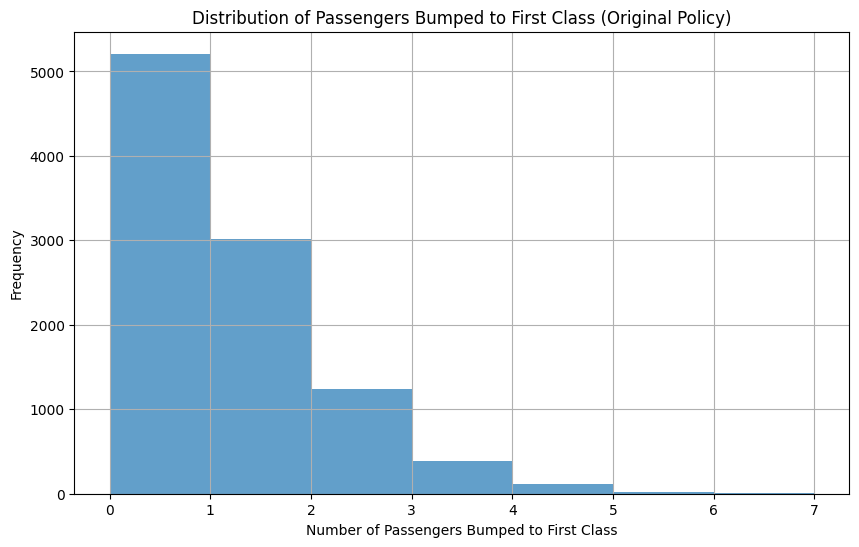

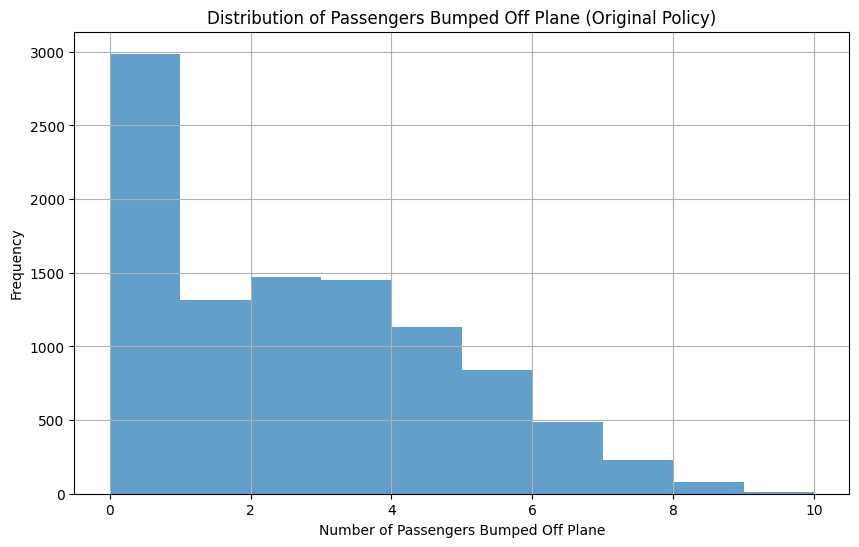

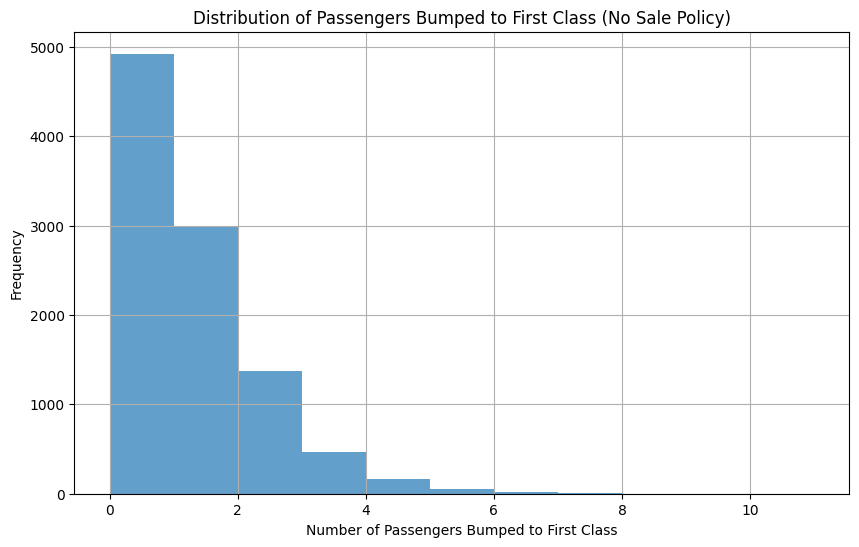

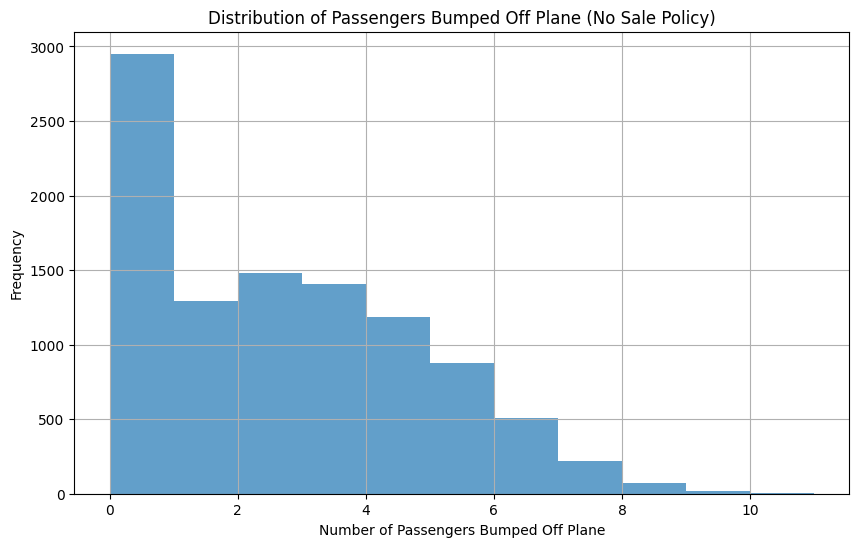

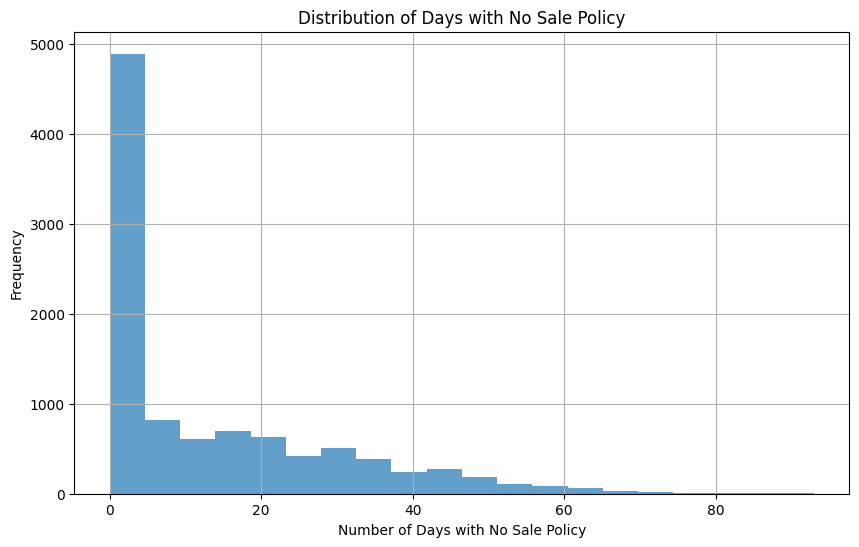

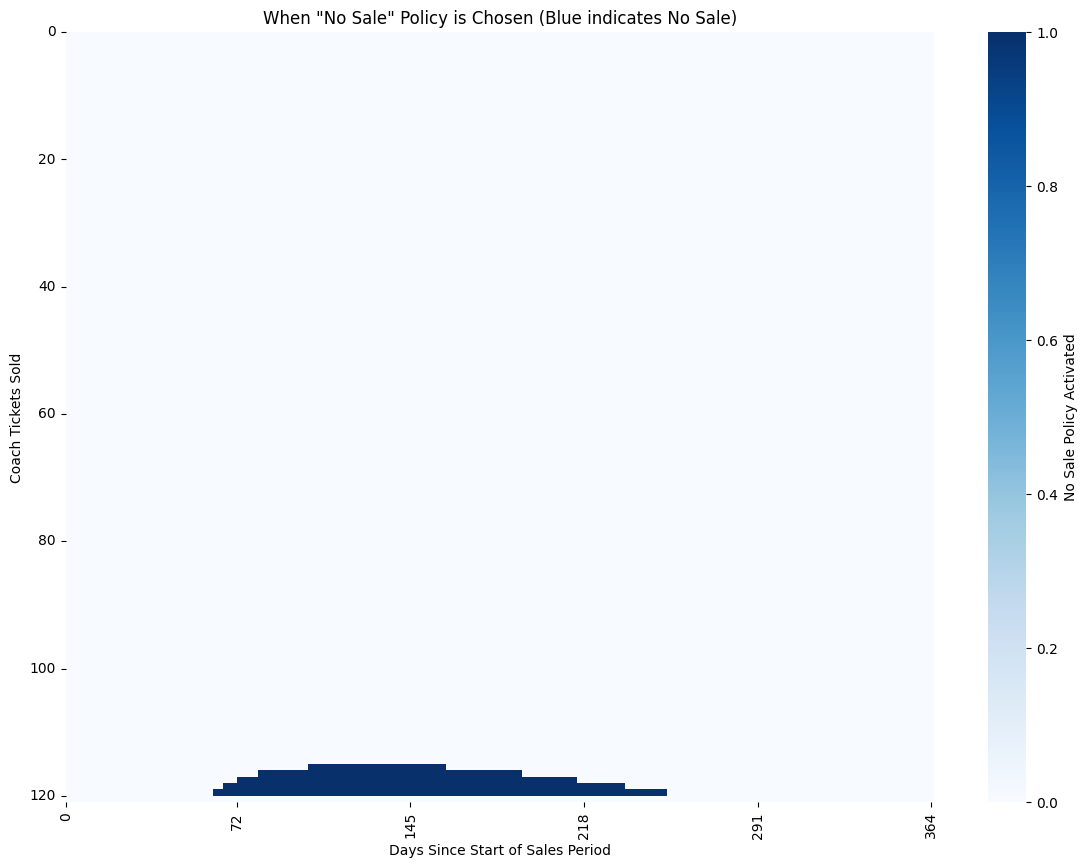

<Figure size 1200x800 with 0 Axes>

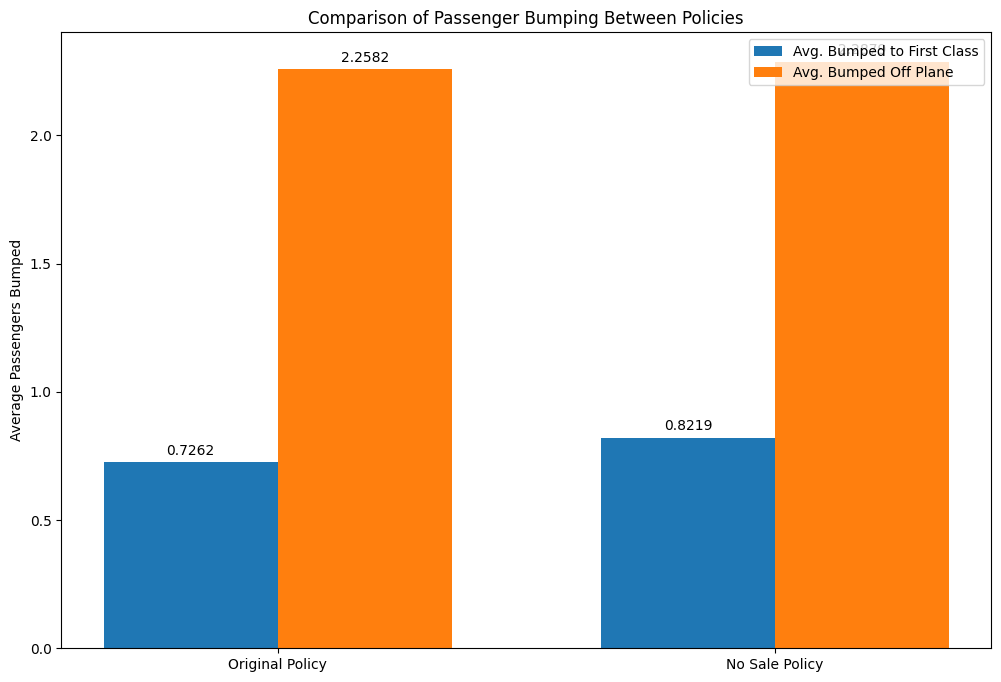

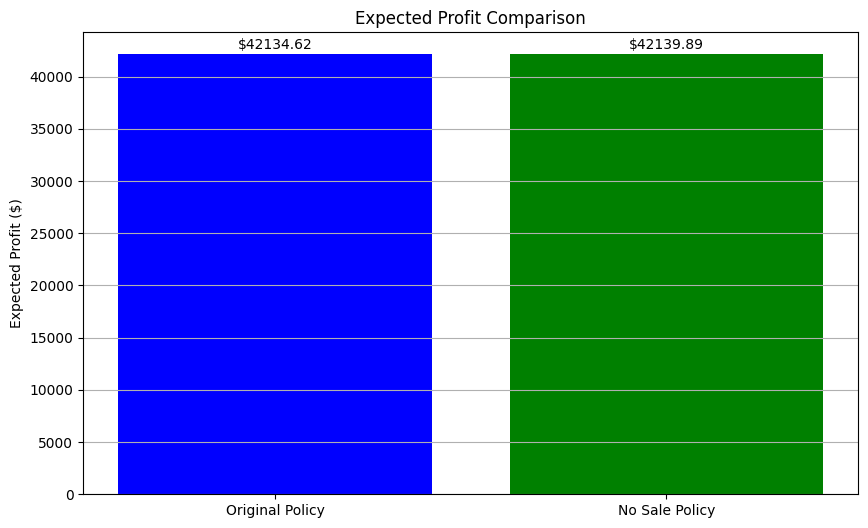

In [13]:
import numpy as np
from scipy.stats import binom
import matplotlib.pyplot as plt
import seaborn as sns
import time

def airline_dp_solution_with_no_sale_option():
    """
    Solve the airline ticket pricing problem using dynamic programming,
    with the additional "no sale" option for coach tickets.
    """
    print("Starting airline ticket dynamic programming solution with NO SALE option...")
    start_time = time.time()
    
    # Step 1: Initialize Parameters
    # Seat configuration
    coach_seats = 100
    first_class_seats = 20
    max_coach_tickets = 120  # Maximum allowed coach tickets with no sale option
    
    # Time horizon
    days_until_takeoff = 365
    
    # Pricing options (add a "no sale" option for coach)
    coach_prices = [300, 350, 0]  # 0 represents "no sale" option
    first_class_prices = [425, 500]
    
    # Sale probabilities (0 probability for "no sale" option)
    coach_sale_prob = {
        300: 0.65,
        350: 0.30,
        0: 0.0  # No sales probability
    }
    # When first class is sold out
    coach_sale_prob_fc_sold_out = {
        300: 0.68,
        350: 0.33,
        0: 0.0  # No sales probability
    }
    first_class_sale_prob = {
        425: 0.08,
        500: 0.04
    }
    
    # Show-up probabilities
    coach_show_prob = 0.95
    first_class_show_prob = 0.97
    
    # Overbooking costs
    cost_bump_to_first_class = 50
    cost_bump_off_plane = 425
    
    # Discount rate
    annual_discount_rate = 0.17
    daily_discount_factor = 1 / (1 + annual_discount_rate / 365)
    
    print(f"Daily discount factor: {daily_discount_factor}")
    
    # Initialize state values and policy
    V = np.zeros((max_coach_tickets + 1, first_class_seats + 1, days_until_takeoff + 1))
    policy = np.zeros((max_coach_tickets + 1, first_class_seats + 1, days_until_takeoff + 1), dtype=int)
    
    # Step 2: Terminal day costs (day 365)
    print("Calculating terminal values...")
    
    # Terminal cost statistics
    terminal_cost_data = []
    
    for coach_sold in range(max_coach_tickets + 1):
        for fc_sold in range(first_class_seats + 1):
            # Calculate expected overbooking costs using binomial distribution
            cost = 0
            expected_bumped_to_fc = 0
            expected_bumped_off = 0
            
            # Generate all possible combinations of show-ups
            for coach_show in range(coach_sold + 1):
                coach_prob = binom.pmf(coach_show, coach_sold, coach_show_prob)
                
                for fc_show in range(fc_sold + 1):
                    fc_prob = binom.pmf(fc_show, fc_sold, first_class_show_prob)
                    
                    # Calculate probability of this exact scenario
                    scenario_prob = coach_prob * fc_prob
                    
                    # If coach is overbooked
                    if coach_show > coach_seats:
                        # Number of passengers to be bumped
                        bumped = coach_show - coach_seats
                        
                        # Available first class seats
                        available_fc = max(0, first_class_seats - fc_show)
                        
                        # Bump to first class if possible, otherwise off the plane
                        bumped_to_fc = min(bumped, available_fc)
                        bumped_off = bumped - bumped_to_fc
                        
                        # Track expected bumping for statistics
                        expected_bumped_to_fc += scenario_prob * bumped_to_fc
                        expected_bumped_off += scenario_prob * bumped_off
                        
                        # Calculate costs
                        scenario_cost = (bumped_to_fc * cost_bump_to_first_class) + (bumped_off * cost_bump_off_plane)
                        cost += scenario_prob * scenario_cost
            
            # Store terminal cost data for visualization
            if coach_sold >= 95:  # Only store for near-capacity situations
                terminal_cost_data.append({
                    'coach_sold': coach_sold,
                    'fc_sold': fc_sold,
                    'expected_cost': cost,
                    'expected_bumped_to_fc': expected_bumped_to_fc,
                    'expected_bumped_off': expected_bumped_off
                })
                
            V[coach_sold, fc_sold, -1] = -cost  # Negative because costs reduce value
    
    # Step 3: Backward induction with "no sale" option
    print("Starting backward induction with 'no sale' option...")
    
    for day in range(days_until_takeoff - 1, -1, -1):
        if day % 50 == 0:
            print(f"Processing day {day}...")
            
        for coach_sold in range(max_coach_tickets + 1):
            for fc_sold in range(first_class_seats + 1):
                # Skip impossible states
                if coach_sold > max_coach_tickets or fc_sold > first_class_seats:
                    continue
                
                # Special handling for the case when first class is full
                if fc_sold == first_class_seats:
                    # When first class is sold out, we still need to decide on coach price
                    # But now we have 3 options: high, low, or no sale
                    best_value = float('-inf')
                    best_action = -1
                    
                    # Try all three coach prices with high FC price
                    for c_idx, coach_price in enumerate(coach_prices):
                        action = c_idx * 2 + 1  # Force high first class price (index 1)
                        
                        # Check coach availability
                        coach_available = coach_sold < max_coach_tickets
                        
                        # Calculate expected value
                        expected_revenue = 0
                        if coach_available and coach_price > 0:  # > 0 means not "no sale"
                            # Use the increased probability when FC is sold out
                            c_prob = coach_sale_prob_fc_sold_out[coach_price]
                            expected_revenue += c_prob * coach_price
                        
                        # Calculate expected future value
                        expected_future_value = 0
                        
                        if not coach_available:
                            # If coach is also full, just move to next day
                            expected_future_value = V[coach_sold, fc_sold, day + 1]
                        else:
                            # Calculate probabilities for future states
                            c_prob = coach_sale_prob_fc_sold_out[coach_price] if coach_price > 0 else 0
                            prob_no_sale = 1 - c_prob
                            expected_future_value += prob_no_sale * V[coach_sold, fc_sold, day + 1]
                            
                            if coach_available and coach_price > 0:
                                expected_future_value += c_prob * V[coach_sold + 1, fc_sold, day + 1]
                        
                        # Calculate total value
                        current_value = expected_revenue + daily_discount_factor * expected_future_value
                        
                        if current_value > best_value:
                            best_value = current_value
                            best_action = action
                    
                    # Store best value and action
                    V[coach_sold, fc_sold, day] = best_value
                    policy[coach_sold, fc_sold, day] = best_action
                else:
                    # Regular processing for non-full first class
                    # Initialize for this state
                    best_value = float('-inf')
                    best_action = 0
                    
                    # Check availability
                    coach_available = coach_sold < max_coach_tickets
                    fc_available = fc_sold < first_class_seats
                    
                    # If both are sold out, just move to next day
                    if not coach_available and not fc_available:
                        V[coach_sold, fc_sold, day] = daily_discount_factor * V[coach_sold, fc_sold, day + 1]
                        continue
                    
                    # Try all pricing combinations (actions)
                    for c_idx, coach_price in enumerate(coach_prices):
                        for f_idx, fc_price in enumerate(first_class_prices):
                            action = c_idx * 2 + f_idx
                            
                            # Determine probabilities based on availability and pricing
                            c_prob = 0  # Coach sale probability
                            if coach_available and coach_price > 0:  # > 0 means not "no sale"
                                if fc_sold == first_class_seats:
                                    c_prob = coach_sale_prob_fc_sold_out[coach_price]
                                else:
                                    c_prob = coach_sale_prob[coach_price]
                                    
                            f_prob = 0  # First class sale probability
                            if fc_available:
                                f_prob = first_class_sale_prob[fc_price]
                            
                            # Calculate expected immediate revenue
                            expected_revenue = 0
                            if coach_available and coach_price > 0:
                                expected_revenue += c_prob * coach_price
                            if fc_available:
                                expected_revenue += f_prob * fc_price
                            
                            # Calculate expected future value considering all possible combinations
                            expected_future_value = 0
                            
                            # Case 1: Neither ticket sells
                            prob_neither = (1 - c_prob if coach_available and coach_price > 0 else 1) * (1 - f_prob if fc_available else 1)
                            expected_future_value += prob_neither * V[coach_sold, fc_sold, day + 1]
                            
                            # Case 2: Only coach sells
                            if coach_available and coach_price > 0:
                                prob_only_coach = c_prob * (1 - f_prob if fc_available else 1)
                                expected_future_value += prob_only_coach * V[coach_sold + 1, fc_sold, day + 1]
                            
                            # Case 3: Only first class sells
                            if fc_available:
                                prob_only_fc = (1 - c_prob if coach_available and coach_price > 0 else 1) * f_prob
                                expected_future_value += prob_only_fc * V[coach_sold, fc_sold + 1, day + 1]
                            
                            # Case 4: Both sell
                            if coach_available and coach_price > 0 and fc_available:
                                prob_both = c_prob * f_prob
                                expected_future_value += prob_both * V[coach_sold + 1, fc_sold + 1, day + 1]
                            
                            # Total expected value = immediate revenue + discounted future value
                            current_value = expected_revenue + daily_discount_factor * expected_future_value
                            
                            # Update if this is the best action
                            if current_value > best_value:
                                best_value = current_value
                                best_action = action
                    
                    # Store best value and action
                    V[coach_sold, fc_sold, day] = best_value
                    policy[coach_sold, fc_sold, day] = best_action
    
    elapsed_time = time.time() - start_time
    print(f"Dynamic programming solution completed in {elapsed_time:.2f} seconds")
    
    # Step 4: Run a simulation to validate and collect detailed statistics
    def simulate_flights(num_simulations=10000):
        """Simulate flights using the optimal policy and collect detailed statistics."""
        print(f"Running {num_simulations} simulations with detailed statistics...")
        
        total_revenue = 0
        
        # Statistics tracking
        coach_tickets_sold = []
        fc_tickets_sold = []
        bumped_to_fc_counts = []
        bumped_off_counts = []
        total_bumped_counts = []
        overbooking_costs = []
        ticket_revenues = []
        no_sale_days_counts = []  # Track days when "no sale" was chosen
        
        # Helper function to convert action to prices
        def get_prices(action):
            coach_idx = action // 2
            fc_idx = action % 2
            return coach_prices[coach_idx], first_class_prices[fc_idx]
        
        for sim in range(num_simulations):
            if sim % 1000 == 0 and sim > 0:
                print(f"Completed {sim} simulations...")
                
            # Starting state
            coach_sold = 0
            fc_sold = 0
            ticket_revenue = 0
            no_sale_days = 0  # Count days with "no sale" policy activated
            
            # Daily ticket sales
            for day in range(days_until_takeoff):
                # Get optimal pricing for current state
                action = policy[coach_sold, fc_sold, day]
                coach_price, fc_price = get_prices(action)
                
                # Check if "no sale" option was chosen for coach
                if coach_price == 0:
                    no_sale_days += 1
                    coach_sale_prob_today = 0
                else:
                    # Coach sales
                    if coach_sold < max_coach_tickets:
                        # Determine probability based on first class availability
                        if fc_sold == first_class_seats:
                            coach_sale_prob_today = coach_sale_prob_fc_sold_out[coach_price]
                        else:
                            coach_sale_prob_today = coach_sale_prob[coach_price]
                        
                        # Simulate sale
                        if np.random.random() < coach_sale_prob_today:
                            coach_sold += 1
                            ticket_revenue += coach_price * (daily_discount_factor ** day)
                
                # First class sales
                if fc_sold < first_class_seats:
                    # Determine probability
                    sale_prob = first_class_sale_prob[fc_price]
                    
                    # Simulate sale
                    if np.random.random() < sale_prob:
                        fc_sold += 1
                        ticket_revenue += fc_price * (daily_discount_factor ** day)
            
            # Record tickets sold and no sale days
            coach_tickets_sold.append(coach_sold)
            fc_tickets_sold.append(fc_sold)
            ticket_revenues.append(ticket_revenue)
            no_sale_days_counts.append(no_sale_days)
            
            # Flight day costs (overbooking)
            coach_show = np.random.binomial(coach_sold, coach_show_prob)
            fc_show = np.random.binomial(fc_sold, first_class_show_prob)
            
            # Initialize bumping counters
            bumped_to_fc = 0
            bumped_off = 0
            flight_overbooking_cost = 0
            
            # Calculate overbooking costs
            if coach_show > coach_seats:
                # Total passengers to bump
                to_bump = coach_show - coach_seats
                
                # Available first class seats
                available_fc = max(0, first_class_seats - fc_show)
                
                # How many get bumped to each category
                bumped_to_fc = min(to_bump, available_fc)
                bumped_off = to_bump - bumped_to_fc
                
                # Calculate costs
                flight_overbooking_cost = (bumped_to_fc * cost_bump_to_first_class) + (bumped_off * cost_bump_off_plane)
                
                # Apply discount factor for final day
                discounted_cost = flight_overbooking_cost * (daily_discount_factor ** days_until_takeoff)
                ticket_revenue -= discounted_cost
            
            # Record bumping statistics
            bumped_to_fc_counts.append(bumped_to_fc)
            bumped_off_counts.append(bumped_off)
            total_bumped_counts.append(bumped_to_fc + bumped_off)
            overbooking_costs.append(flight_overbooking_cost)
            
            # Add to total revenue
            total_revenue += ticket_revenue
        
        # Calculate summary statistics
        avg_coach_sold = np.mean(coach_tickets_sold)
        avg_fc_sold = np.mean(fc_tickets_sold)
        avg_bumped_to_fc = np.mean(bumped_to_fc_counts)
        avg_bumped_off = np.mean(bumped_off_counts)
        avg_total_bumped = np.mean(total_bumped_counts)
        avg_overbooking_cost = np.mean(overbooking_costs)
        avg_ticket_revenue = np.mean(ticket_revenues)
        avg_no_sale_days = np.mean(no_sale_days_counts)
        
        # Calculate percentages
        pct_flights_with_bumping = 100 * np.sum(np.array(total_bumped_counts) > 0) / num_simulations
        pct_days_with_no_sale = 100 * avg_no_sale_days / days_until_takeoff
        total_coach_passengers = np.sum(np.array(coach_tickets_sold) * coach_show_prob)
        pct_coach_passengers_bumped = 100 * np.sum(total_bumped_counts) / total_coach_passengers if total_coach_passengers > 0 else 0
        
        # Print detailed statistics
        print("\nDetailed Simulation Statistics:")
        print(f"Average coach tickets sold: {avg_coach_sold:.2f} out of maximum {max_coach_tickets}")
        print(f"Average first class tickets sold: {avg_fc_sold:.2f} out of {first_class_seats}")
        print(f"Average number of 'no sale' days: {avg_no_sale_days:.2f} out of {days_until_takeoff} ({pct_days_with_no_sale:.2f}%)")
        print(f"Average passengers bumped to first class: {avg_bumped_to_fc:.4f}")
        print(f"Average passengers bumped off plane: {avg_bumped_off:.4f}")
        print(f"Average total passengers bumped: {avg_total_bumped:.4f}")
        print(f"Percentage of flights with any bumping: {pct_flights_with_bumping:.2f}%")
        print(f"Percentage of coach passengers bumped: {pct_coach_passengers_bumped:.4f}%")
        print(f"Average overbooking cost per flight: ${avg_overbooking_cost:.2f}")
        print(f"Average ticket revenue per flight: ${avg_ticket_revenue:.2f}")
        
        # Create visualizations
        
        # 1. Histogram of number of passengers bumped to first class
        plt.figure(figsize=(10, 6))
        plt.hist(bumped_to_fc_counts, bins=range(max(bumped_to_fc_counts)+2), alpha=0.7)
        plt.xlabel('Number of Passengers Bumped to First Class')
        plt.ylabel('Frequency')
        plt.title('Distribution of Passengers Bumped to First Class (No Sale Policy)')
        plt.grid(True)
        plt.savefig('bumped_to_fc_histogram_no_sale.png')
        
        # 2. Histogram of number of passengers bumped off plane
        plt.figure(figsize=(10, 6))
        plt.hist(bumped_off_counts, bins=range(max(bumped_off_counts)+2), alpha=0.7)
        plt.xlabel('Number of Passengers Bumped Off Plane')
        plt.ylabel('Frequency')
        plt.title('Distribution of Passengers Bumped Off Plane (No Sale Policy)')
        plt.grid(True)
        plt.savefig('bumped_off_histogram_no_sale.png')
        
        # 3. Histogram of no sale days
        plt.figure(figsize=(10, 6))
        plt.hist(no_sale_days_counts, bins=20, alpha=0.7)
        plt.xlabel('Number of Days with No Sale Policy')
        plt.ylabel('Frequency')
        plt.title('Distribution of Days with No Sale Policy')
        plt.grid(True)
        plt.savefig('no_sale_days_histogram.png')
        
        # Statistics dictionary
        statistics = {
            'avg_coach_sold': avg_coach_sold,
            'avg_fc_sold': avg_fc_sold,
            'avg_bumped_to_fc': avg_bumped_to_fc,
            'avg_bumped_off': avg_bumped_off,
            'avg_total_bumped': avg_total_bumped,
            'pct_flights_with_bumping': pct_flights_with_bumping,
            'pct_coach_passengers_bumped': pct_coach_passengers_bumped,
            'avg_overbooking_cost': avg_overbooking_cost,
            'avg_ticket_revenue': avg_ticket_revenue,
            'avg_no_sale_days': avg_no_sale_days,
            'pct_days_with_no_sale': pct_days_with_no_sale,
            'coach_tickets_sold': coach_tickets_sold,
            'fc_tickets_sold': fc_tickets_sold,
            'bumped_to_fc_counts': bumped_to_fc_counts,
            'bumped_off_counts': bumped_off_counts,
            'total_bumped_counts': total_bumped_counts,
            'overbooking_costs': overbooking_costs,
            'ticket_revenues': ticket_revenues,
            'no_sale_days_counts': no_sale_days_counts
        }
        
        return total_revenue / num_simulations, statistics
    
    # Helper function to get prices from action
    def get_prices(action):
        coach_idx = action // 2
        fc_idx = action % 2
        return coach_prices[coach_idx], first_class_prices[fc_idx]
    
    # Analyze when "no sale" option is chosen
    def analyze_no_sale_policy():
        print("Analyzing when 'No Sale' policy is chosen...")
        
        # Create a 2D array to store where the no-sale option is chosen
        no_sale_map = np.zeros((max_coach_tickets + 1, days_until_takeoff))
        
        # Fill the array with 1s where no-sale is chosen (coach_price == 0)
        for coach_sold in range(max_coach_tickets + 1):
            for day in range(days_until_takeoff):
                action = policy[coach_sold, 0, day]  # Assuming no first class sold
                coach_price, _ = get_prices(action)
                if coach_price == 0:  # No sale chosen
                    no_sale_map[coach_sold, day] = 1
        
        # Create a heatmap of when "no sale" is chosen
        plt.figure(figsize=(14, 10))
        ax = sns.heatmap(no_sale_map, cmap='Blues', cbar_kws={'label': 'No Sale Policy Activated'})
        
        # Set appropriate axis labels
        plt.xlabel('Days Since Start of Sales Period')
        plt.ylabel('Coach Tickets Sold')
        plt.title('When "No Sale" Policy is Chosen (Blue indicates No Sale)')
        
        # Customize tick labels
        x_ticks = np.linspace(0, days_until_takeoff-1, 6, dtype=int)
        y_ticks = np.linspace(0, max_coach_tickets, 7, dtype=int)
        plt.xticks(x_ticks, x_ticks)
        plt.yticks(y_ticks, y_ticks)
        
        plt.savefig('no_sale_policy_heatmap.png')
    
    # Get the expected profit from DP solution
    expected_profit = V[0, 0, 0]
    print(f"Expected profit with 'no sale' option: ${expected_profit:.2f}")
    
    # Validate with simulation and collect statistics
    simulated_profit, statistics = simulate_flights(10000)
    print(f"Simulated profit with 'no sale' option: ${simulated_profit:.2f}")
    print(f"Difference: ${abs(expected_profit - simulated_profit):.2f}")
    
    # Analyze when the "no sale" option is chosen
    analyze_no_sale_policy()
    
    return {
        'expected_profit': expected_profit,
        'simulated_profit': simulated_profit,
        'value_function': V,
        'policy': policy,
        'statistics': statistics
    }

def airline_dp_solution_original():
    """
    Solve the airline ticket pricing problem using dynamic programming,
    with the original policy (no "no sale" option, 9 overbooking limit).
    """
    print("Starting airline ticket dynamic programming solution with original policy...")
    start_time = time.time()
    
    # Step 1: Initialize Parameters
    # Seat configuration
    coach_seats = 100
    first_class_seats = 20
    max_coach_overbooking = 9
    max_coach_tickets = coach_seats + max_coach_overbooking  # 109
    
    # Time horizon
    days_until_takeoff = 365
    
    # Pricing options
    coach_prices = [300, 350]
    first_class_prices = [425, 500]
    
    # Sale probabilities
    coach_sale_prob = {
        300: 0.65,
        350: 0.30
    }
    # When first class is sold out
    coach_sale_prob_fc_sold_out = {
        300: 0.68,
        350: 0.33
    }
    first_class_sale_prob = {
        425: 0.08,
        500: 0.04
    }
    
    # Show-up probabilities
    coach_show_prob = 0.95
    first_class_show_prob = 0.97
    
    # Overbooking costs
    cost_bump_to_first_class = 50
    cost_bump_off_plane = 425
    
    # Discount rate
    annual_discount_rate = 0.17
    daily_discount_factor = 1 / (1 + annual_discount_rate / 365)
    
    print(f"Daily discount factor: {daily_discount_factor}")
    
    # Initialize state values and policy
    V = np.zeros((max_coach_tickets + 1, first_class_seats + 1, days_until_takeoff + 1))
    policy = np.zeros((max_coach_tickets + 1, first_class_seats + 1, days_until_takeoff + 1), dtype=int)
    
    # Step 2: Terminal day costs (day 365)
    print("Calculating terminal values...")
    
    # Terminal cost statistics
    terminal_cost_data = []
    
    for coach_sold in range(max_coach_tickets + 1):
        for fc_sold in range(first_class_seats + 1):
            # Calculate expected overbooking costs using binomial distribution
            cost = 0
            expected_bumped_to_fc = 0
            expected_bumped_off = 0
            
            # Generate all possible combinations of show-ups
            for coach_show in range(coach_sold + 1):
                coach_prob = binom.pmf(coach_show, coach_sold, coach_show_prob)
                
                for fc_show in range(fc_sold + 1):
                    fc_prob = binom.pmf(fc_show, fc_sold, first_class_show_prob)
                    
                    # Calculate probability of this exact scenario
                    scenario_prob = coach_prob * fc_prob
                    
                    # If coach is overbooked
                    if coach_show > coach_seats:
                        # Number of passengers to be bumped
                        bumped = coach_show - coach_seats
                        
                        # Available first class seats
                        available_fc = max(0, first_class_seats - fc_show)
                        
                        # Bump to first class if possible, otherwise off the plane
                        bumped_to_fc = min(bumped, available_fc)
                        bumped_off = bumped - bumped_to_fc
                        
                        # Track expected bumping for statistics
                        expected_bumped_to_fc += scenario_prob * bumped_to_fc
                        expected_bumped_off += scenario_prob * bumped_off
                        
                        # Calculate costs
                        scenario_cost = (bumped_to_fc * cost_bump_to_first_class) + (bumped_off * cost_bump_off_plane)
                        cost += scenario_prob * scenario_cost
            
            # Store terminal cost data for visualization
            if coach_sold >= 95:  # Only store for near-capacity situations
                terminal_cost_data.append({
                    'coach_sold': coach_sold,
                    'fc_sold': fc_sold,
                    'expected_cost': cost,
                    'expected_bumped_to_fc': expected_bumped_to_fc,
                    'expected_bumped_off': expected_bumped_off
                })
                
            V[coach_sold, fc_sold, -1] = -cost  # Negative because costs reduce value
    
    # Step 3: Backward induction - CORRECTED IMPLEMENTATION
    print("Starting backward induction...")
    
    for day in range(days_until_takeoff - 1, -1, -1):
        if day % 50 == 0:
            print(f"Processing day {day}...")
            
        for coach_sold in range(max_coach_tickets + 1):
            for fc_sold in range(first_class_seats + 1):
                # Skip impossible states
                if coach_sold > max_coach_tickets or fc_sold > first_class_seats:
                    continue
                
                # Special handling for the case when first class is full
                if fc_sold == first_class_seats:
                    # When first class is sold out, we always use high price (index 1)
                    # We only need to decide on coach price
                    best_value = float('-inf')
                    best_action = -1
                    
                    # Try both coach prices with high FC price
                    for c_idx, coach_price in enumerate(coach_prices):
                        action = c_idx * 2 + 1  # Force high first class price (index 1)
                        
                        # Check coach availability
                        coach_available = coach_sold < max_coach_tickets
                        
                        # Calculate expected value
                        expected_revenue = 0
                        if coach_available:
                            # Use the increased probability when FC is sold out
                            c_prob = coach_sale_prob_fc_sold_out[coach_price]
                            expected_revenue += c_prob * coach_price
                        
                        # Calculate expected future value
                        expected_future_value = 0
                        
                        if not coach_available:
                            # If coach is also full, just move to next day
                            expected_future_value = V[coach_sold, fc_sold, day + 1]
                        else:
                            # Calculate probabilities for future states
                            prob_no_sale = 1 - c_prob
                            expected_future_value += prob_no_sale * V[coach_sold, fc_sold, day + 1]
                            
                            if coach_available:
                                expected_future_value += c_prob * V[coach_sold + 1, fc_sold, day + 1]
                        
                        # Calculate total value
                        current_value = expected_revenue + daily_discount_factor * expected_future_value
                        
                        if current_value > best_value:
                            best_value = current_value
                            best_action = action
                    
                    # Store best value and action
                    V[coach_sold, fc_sold, day] = best_value
                    policy[coach_sold, fc_sold, day] = best_action
                else:
                    # Regular processing for non-full first class
                    # Initialize for this state
                    best_value = float('-inf')
                    best_action = 0
                    
                    # Check availability
                    coach_available = coach_sold < max_coach_tickets
                    fc_available = fc_sold < first_class_seats
                    
                    # If both are sold out, just move to next day
                    if not coach_available and not fc_available:
                        V[coach_sold, fc_sold, day] = daily_discount_factor * V[coach_sold, fc_sold, day + 1]
                        continue
                    
                    # Try all pricing combinations (actions)
                    for c_idx, coach_price in enumerate(coach_prices):
                        for f_idx, fc_price in enumerate(first_class_prices):
                            action = c_idx * 2 + f_idx
                            
                            # Determine probabilities based on availability and pricing
                            c_prob = 0  # Coach sale probability
                            if coach_available:
                                if fc_sold == first_class_seats:  # This case is handled separately now
                                    c_prob = coach_sale_prob_fc_sold_out[coach_price]
                                else:
                                    c_prob = coach_sale_prob[coach_price]
                                    
                            f_prob = 0  # First class sale probability
                            if fc_available:
                                f_prob = first_class_sale_prob[fc_price]
                            
                            # Calculate expected immediate revenue
                            expected_revenue = 0
                            if coach_available:
                                expected_revenue += c_prob * coach_price
                            if fc_available:
                                expected_revenue += f_prob * fc_price
                            
                            # Calculate expected future value considering all possible combinations
                            expected_future_value = 0
                            
                            # Case 1: Neither ticket sells
                            prob_neither = (1 - c_prob if coach_available else 1) * (1 - f_prob if fc_available else 1)
                            expected_future_value += prob_neither * V[coach_sold, fc_sold, day + 1]
                            
                            # Case 2: Only coach sells
                            if coach_available:
                                prob_only_coach = c_prob * (1 - f_prob if fc_available else 1)
                                expected_future_value += prob_only_coach * V[coach_sold + 1, fc_sold, day + 1]
                            
                            # Case 3: Only first class sells
                            if fc_available:
                                prob_only_fc = (1 - c_prob if coach_available else 1) * f_prob
                                expected_future_value += prob_only_fc * V[coach_sold, fc_sold + 1, day + 1]
                            
                            # Case 4: Both sell
                            if coach_available and fc_available:
                                prob_both = c_prob * f_prob
                                expected_future_value += prob_both * V[coach_sold + 1, fc_sold + 1, day + 1]
                            
                            # Total expected value = immediate revenue + discounted future value
                            current_value = expected_revenue + daily_discount_factor * expected_future_value
                            
                            # Update if this is the best action
                            if current_value > best_value:
                                best_value = current_value
                                best_action = action
                    
                    # Store best value and action
                    V[coach_sold, fc_sold, day] = best_value
                    policy[coach_sold, fc_sold, day] = best_action
    
    elapsed_time = time.time() - start_time
    print(f"Dynamic programming solution completed in {elapsed_time:.2f} seconds")
    
    # Step 4: Run a simulation to validate and collect detailed statistics
    def simulate_flights(num_simulations=10000):
        """Simulate flights using the optimal policy and collect detailed statistics."""
        print(f"Running {num_simulations} simulations with detailed statistics...")
        
        total_revenue = 0
        
        # Statistics tracking
        coach_tickets_sold = []
        fc_tickets_sold = []
        bumped_to_fc_counts = []
        bumped_off_counts = []
        total_bumped_counts = []
        overbooking_costs = []
        ticket_revenues = []
        
        # Helper function to convert action to prices
        def get_prices(action):
            coach_idx = action // 2
            fc_idx = action % 2
            return coach_prices[coach_idx], first_class_prices[fc_idx]
        
        for sim in range(num_simulations):
            if sim % 1000 == 0 and sim > 0:
                print(f"Completed {sim} simulations...")
                
            # Starting state
            coach_sold = 0
            fc_sold = 0
            ticket_revenue = 0
            
            # Daily ticket sales
            for day in range(days_until_takeoff):
                # Get optimal pricing for current state
                action = policy[coach_sold, fc_sold, day]
                coach_price, fc_price = get_prices(action)
                
                # Coach sales
                if coach_sold < max_coach_tickets:
                    # Determine probability based on first class availability
                    if fc_sold == first_class_seats:
                        sale_prob = coach_sale_prob_fc_sold_out[coach_price]
                    else:
                        sale_prob = coach_sale_prob[coach_price]
                    
                    # Simulate sale
                    if np.random.random() < sale_prob:
                        coach_sold += 1
                        ticket_revenue += coach_price * (daily_discount_factor ** day)
                
                # First class sales
                if fc_sold < first_class_seats:
                    # Determine probability
                    sale_prob = first_class_sale_prob[fc_price]
                    
                    # Simulate sale
                    if np.random.random() < sale_prob:
                        fc_sold += 1
                        ticket_revenue += fc_price * (daily_discount_factor ** day)
            
            # Record tickets sold
            coach_tickets_sold.append(coach_sold)
            fc_tickets_sold.append(fc_sold)
            ticket_revenues.append(ticket_revenue)
            
            # Flight day costs (overbooking)
            coach_show = np.random.binomial(coach_sold, coach_show_prob)
            fc_show = np.random.binomial(fc_sold, first_class_show_prob)
            
            # Initialize bumping counters
            bumped_to_fc = 0
            bumped_off = 0
            flight_overbooking_cost = 0
            
            # Calculate overbooking costs
            if coach_show > coach_seats:
                # Total passengers to bump
                to_bump = coach_show - coach_seats
                
                # Available first class seats
                available_fc = max(0, first_class_seats - fc_show)
                
                # How many get bumped to each category
                bumped_to_fc = min(to_bump, available_fc)
                bumped_off = to_bump - bumped_to_fc
                
                # Calculate costs
                flight_overbooking_cost = (bumped_to_fc * cost_bump_to_first_class) + (bumped_off * cost_bump_off_plane)
                
                # Apply discount factor for final day
                discounted_cost = flight_overbooking_cost * (daily_discount_factor ** days_until_takeoff)
                ticket_revenue -= discounted_cost
            
            # Record bumping statistics
            bumped_to_fc_counts.append(bumped_to_fc)
            bumped_off_counts.append(bumped_off)
            total_bumped_counts.append(bumped_to_fc + bumped_off)
            overbooking_costs.append(flight_overbooking_cost)
            
            # Add to total revenue
            total_revenue += ticket_revenue
        
        # Calculate summary statistics
        avg_coach_sold = np.mean(coach_tickets_sold)
        avg_fc_sold = np.mean(fc_tickets_sold)
        avg_bumped_to_fc = np.mean(bumped_to_fc_counts)
        avg_bumped_off = np.mean(bumped_off_counts)
        avg_total_bumped = np.mean(total_bumped_counts)
        avg_overbooking_cost = np.mean(overbooking_costs)
        avg_ticket_revenue = np.mean(ticket_revenues)
        
        # Calculate percentages
        pct_flights_with_bumping = 100 * np.sum(np.array(total_bumped_counts) > 0) / num_simulations
        total_coach_passengers = np.sum(np.array(coach_tickets_sold) * coach_show_prob)
        pct_coach_passengers_bumped = 100 * np.sum(total_bumped_counts) / total_coach_passengers if total_coach_passengers > 0 else 0
        
        # Print detailed statistics
        print("\nDetailed Simulation Statistics:")
        print(f"Average coach tickets sold: {avg_coach_sold:.2f} out of maximum {max_coach_tickets}")
        print(f"Average first class tickets sold: {avg_fc_sold:.2f} out of {first_class_seats}")
        print(f"Average passengers bumped to first class: {avg_bumped_to_fc:.4f}")
        print(f"Average passengers bumped off plane: {avg_bumped_off:.4f}")
        print(f"Average total passengers bumped: {avg_total_bumped:.4f}")
        print(f"Percentage of flights with any bumping: {pct_flights_with_bumping:.2f}%")
        print(f"Percentage of coach passengers bumped: {pct_coach_passengers_bumped:.4f}%")
        print(f"Average overbooking cost per flight: ${avg_overbooking_cost:.2f}")
        print(f"Average ticket revenue per flight: ${avg_ticket_revenue:.2f}")
        
        # Create visualizations
        
        # 1. Histogram of number of passengers bumped to first class
        plt.figure(figsize=(10, 6))
        plt.hist(bumped_to_fc_counts, bins=range(max(bumped_to_fc_counts)+2), alpha=0.7)
        plt.xlabel('Number of Passengers Bumped to First Class')
        plt.ylabel('Frequency')
        plt.title('Distribution of Passengers Bumped to First Class (Original Policy)')
        plt.grid(True)
        plt.savefig('bumped_to_fc_histogram_original.png')
        
        # 2. Histogram of number of passengers bumped off plane
        plt.figure(figsize=(10, 6))
        plt.hist(bumped_off_counts, bins=range(max(bumped_off_counts)+2), alpha=0.7)
        plt.xlabel('Number of Passengers Bumped Off Plane')
        plt.ylabel('Frequency')
        plt.title('Distribution of Passengers Bumped Off Plane (Original Policy)')
        plt.grid(True)
        plt.savefig('bumped_off_histogram_original.png')
        
        # Statistics dictionary
        statistics = {
            'avg_coach_sold': avg_coach_sold,
            'avg_fc_sold': avg_fc_sold,
            'avg_bumped_to_fc': avg_bumped_to_fc,
            'avg_bumped_off': avg_bumped_off,
            'avg_total_bumped': avg_total_bumped,
            'pct_flights_with_bumping': pct_flights_with_bumping,
            'pct_coach_passengers_bumped': pct_coach_passengers_bumped,
            'avg_overbooking_cost': avg_overbooking_cost,
            'avg_ticket_revenue': avg_ticket_revenue,
            'coach_tickets_sold': coach_tickets_sold,
            'fc_tickets_sold': fc_tickets_sold,
            'bumped_to_fc_counts': bumped_to_fc_counts,
            'bumped_off_counts': bumped_off_counts,
            'total_bumped_counts': total_bumped_counts,
            'overbooking_costs': overbooking_costs,
            'ticket_revenues': ticket_revenues
        }
        
        return total_revenue / num_simulations, statistics
    
    # Get the expected profit from DP solution
    expected_profit = V[0, 0, 0]
    print(f"Expected profit from original policy: ${expected_profit:.2f}")
    
    # Validate with simulation and collect statistics
    simulated_profit, statistics = simulate_flights(10000)
    print(f"Simulated profit from original policy: ${simulated_profit:.2f}")
    print(f"Difference: ${abs(expected_profit - simulated_profit):.2f}")
    
    return {
        'expected_profit': expected_profit,
        'simulated_profit': simulated_profit,
        'value_function': V,
        'policy': policy,
        'statistics': statistics
    }

# Run both solutions
print("="*50)
print("RUNNING ORIGINAL POLICY SOLUTION")
print("="*50)
original_results = airline_dp_solution_original()

print("\n" + "="*50)
print("RUNNING NEW POLICY WITH 'NO SALE' OPTION")
print("="*50)
no_sale_results = airline_dp_solution_with_no_sale_option()

# Compare the results
print("\n" + "="*50)
print("COMPARISON OF POLICIES")
print("="*50)
print(f"Original Policy Expected Profit: ${original_results['expected_profit']:.2f}")
print(f"Original Policy Simulated Profit: ${original_results['simulated_profit']:.2f}")
print(f"'No Sale' Policy Expected Profit: ${no_sale_results['expected_profit']:.2f}")
print(f"'No Sale' Policy Simulated Profit: ${no_sale_results['simulated_profit']:.2f}")

profit_difference = no_sale_results['expected_profit'] - original_results['expected_profit']
profit_pct_increase = 100 * profit_difference / original_results['expected_profit']

print(f"\nDifference in Expected Profit: ${profit_difference:.2f}")
print(f"Percentage Improvement: {profit_pct_increase:.2f}%")

# Create comparison visualization
plt.figure(figsize=(12, 8))

# Bumping comparison
labels = ['Original Policy', 'No Sale Policy']
avg_bumped_to_fc = [original_results['statistics']['avg_bumped_to_fc'], no_sale_results['statistics']['avg_bumped_to_fc']]
avg_bumped_off = [original_results['statistics']['avg_bumped_off'], no_sale_results['statistics']['avg_bumped_off']]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 8))
bumped_to_fc_bars = ax.bar(x - width/2, avg_bumped_to_fc, width, label='Avg. Bumped to First Class')
bumped_off_bars = ax.bar(x + width/2, avg_bumped_off, width, label='Avg. Bumped Off Plane')

ax.set_ylabel('Average Passengers Bumped')
ax.set_title('Comparison of Passenger Bumping Between Policies')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Add value labels
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bumped_to_fc_bars)
add_labels(bumped_off_bars)

plt.savefig('bumping_comparison.png')

# Create profit comparison
plt.figure(figsize=(10, 6))
profits = [original_results['expected_profit'], no_sale_results['expected_profit']]
bar_colors = ['blue', 'green']
plt.bar(labels, profits, color=bar_colors)
plt.ylabel('Expected Profit ($)')
plt.title('Expected Profit Comparison')
plt.grid(axis='y')

# Add profit values on bars
for i, v in enumerate(profits):
    plt.text(i, v + 500, f"${v:.2f}", ha='center')

plt.savefig('profit_comparison.png')

print("\nVisualizations created:")
print("1. bumping_comparison.png - Comparison of passenger bumping between policies")
print("2. profit_comparison.png - Comparison of expected profits")
print("3. no_sale_policy_heatmap.png - Heatmap showing when 'no sale' policy is chosen")

if profit_difference > 0:
    print(f"\nConclusion: The 'No Sale' policy is BETTER than the original policy, with ${profit_difference:.2f} higher expected profit.")
else:
    print(f"\nConclusion: The 'No Sale' policy is WORSE than the original policy, with ${-profit_difference:.2f} lower expected profit.")


Seasonal Pricing Simulation and DP profits are diferent so I think this is wrong akak use Bigaios)

Starting airline ticket dynamic programming solution...
Daily discount factor: 0.999534463400608
Calculating terminal values...
Starting backward induction with time-dependent demand...
Processing day 350...
Processing day 300...
Processing day 250...
Processing day 200...
Processing day 150...
Processing day 100...
Processing day 50...
Processing day 0...
Dynamic programming solution completed in 269.28 seconds
Expected profit from time-dependent DP solution: $42434.39
Running 50000 simulations with detailed statistics...
Completed 5000 simulations...
Completed 10000 simulations...
Completed 15000 simulations...
Completed 20000 simulations...
Completed 25000 simulations...
Completed 30000 simulations...
Completed 35000 simulations...
Completed 40000 simulations...
Completed 45000 simulations...

Detailed Bumping Statistics:
Average coach tickets sold: 108.97 out of 109
Average first class tickets sold: 19.86 out of 20
Average passengers bumped to first class: 0.6345
Average passengers

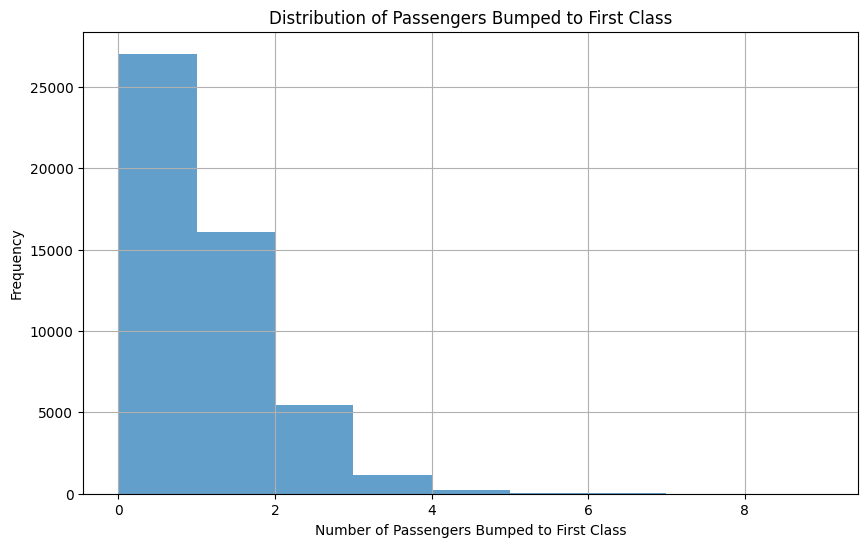

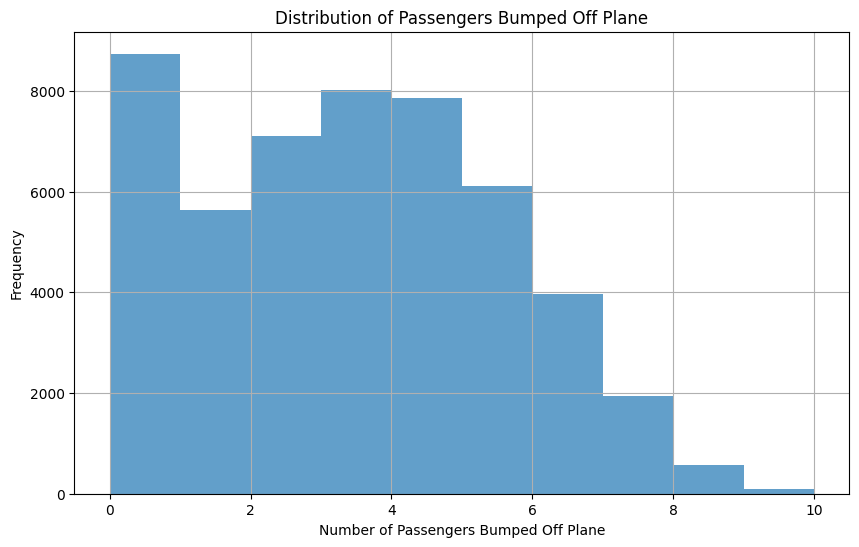

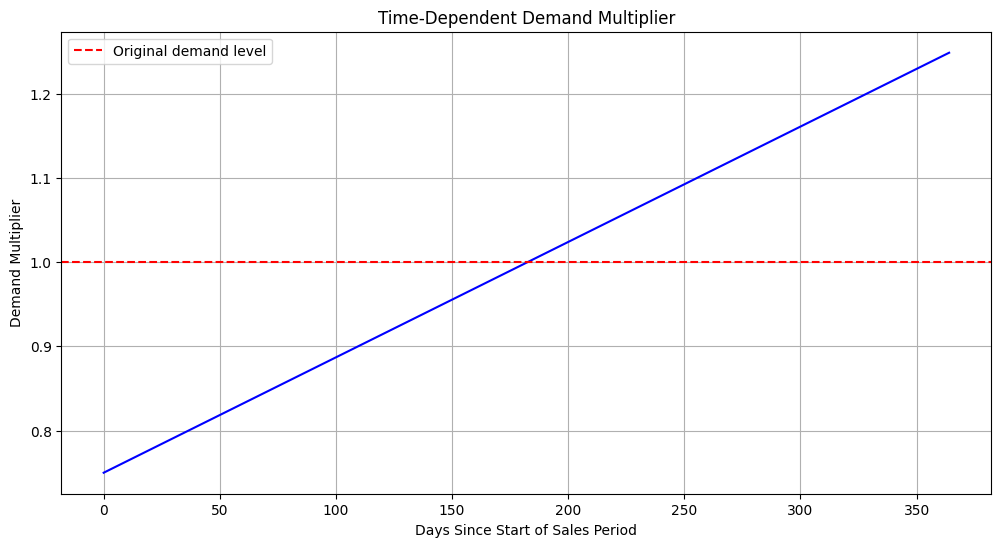

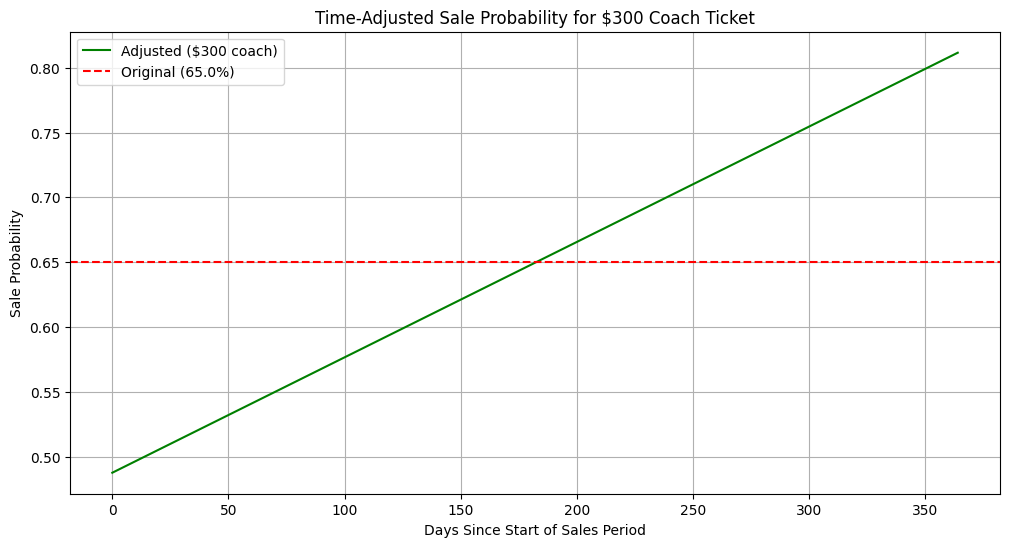

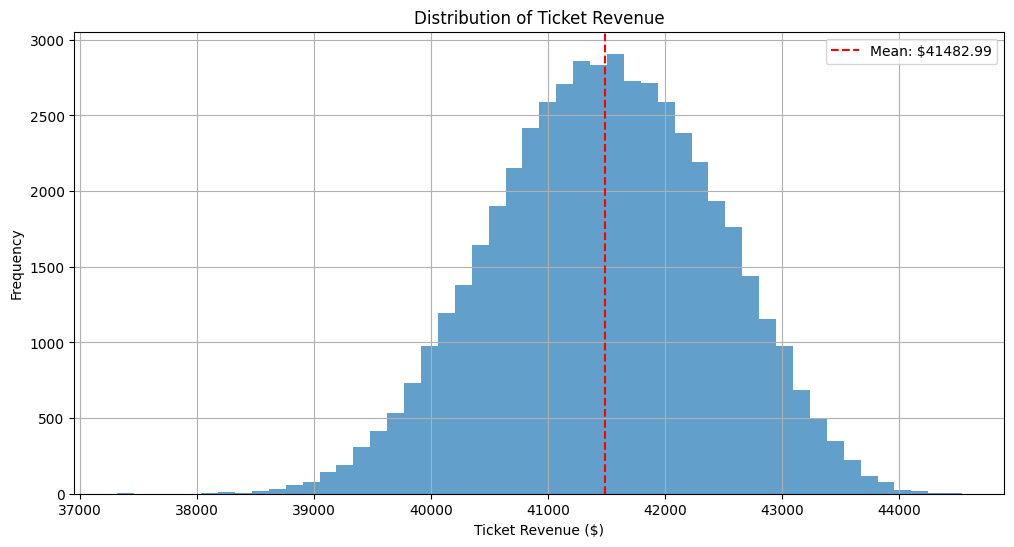

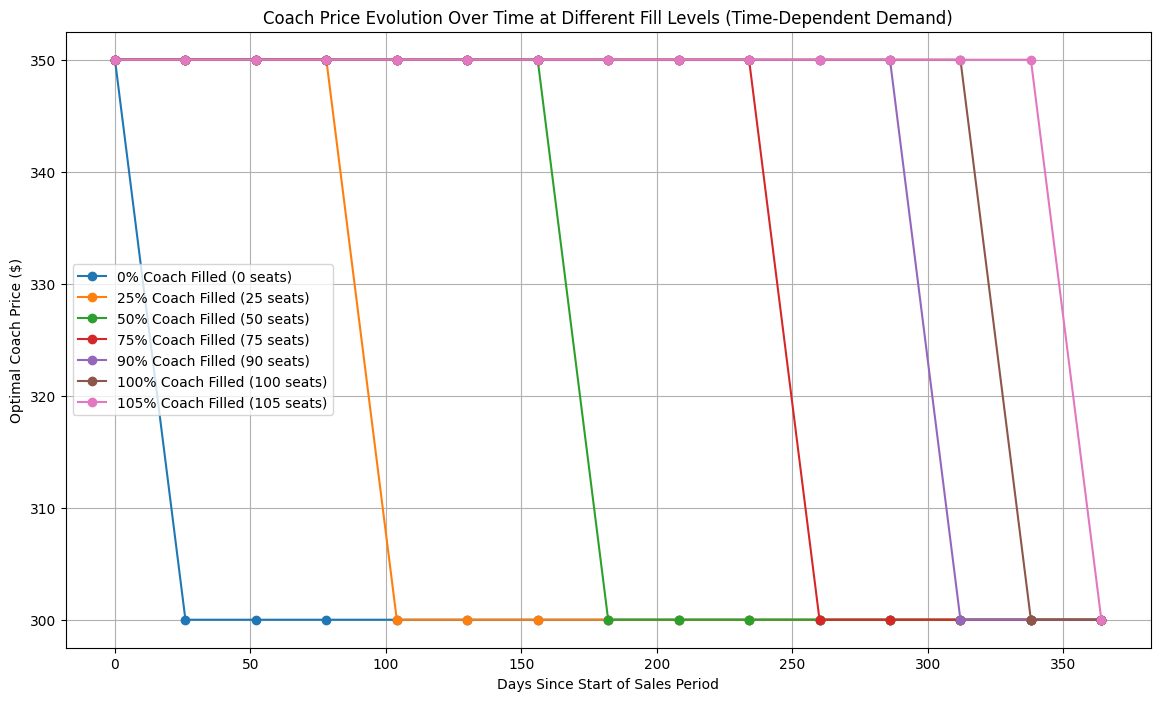

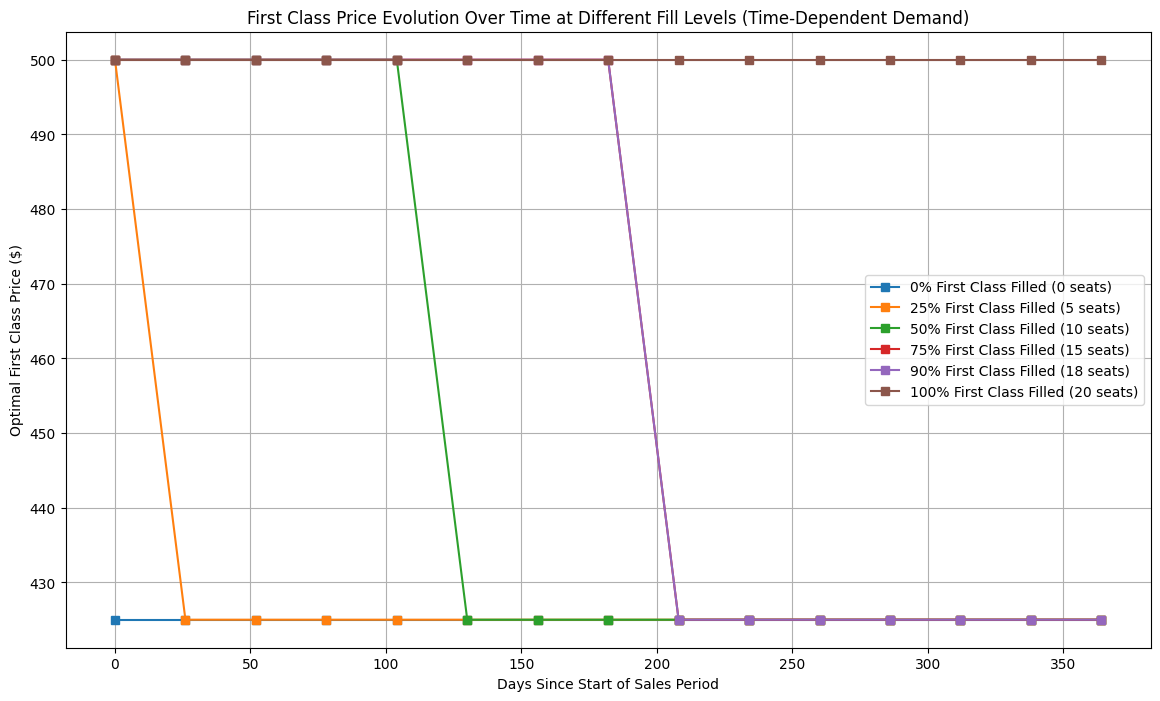

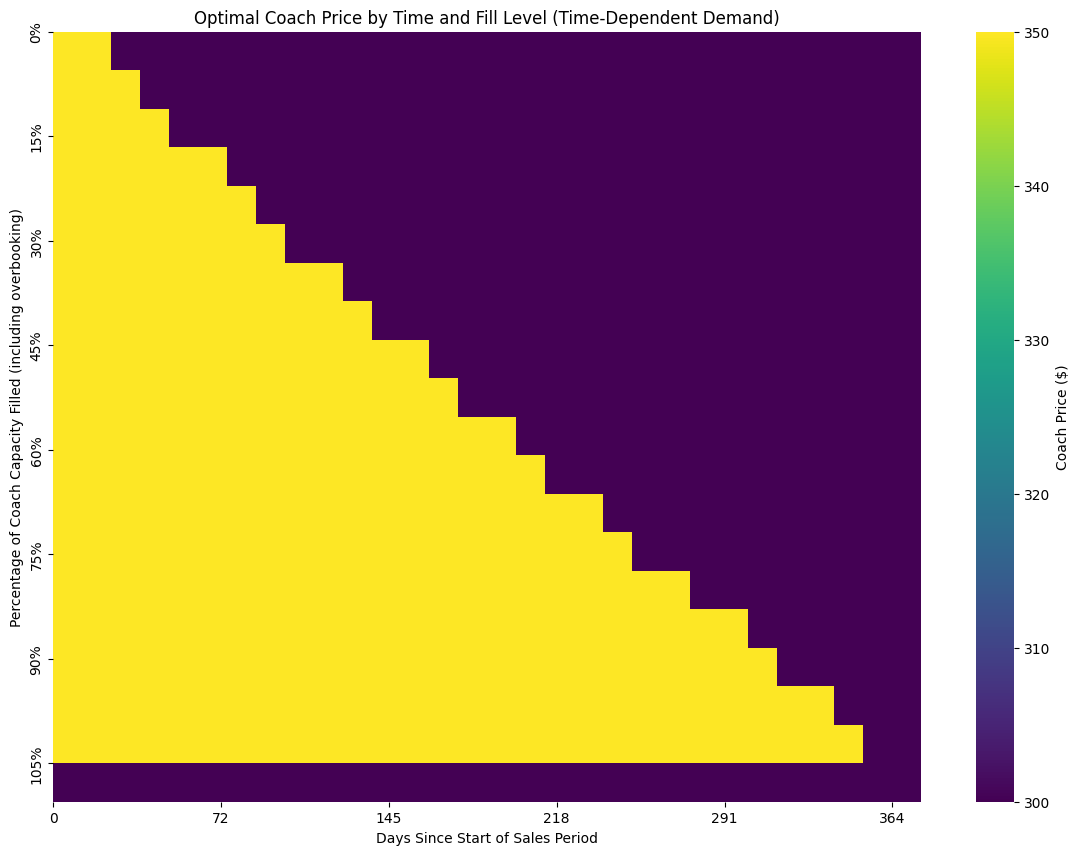

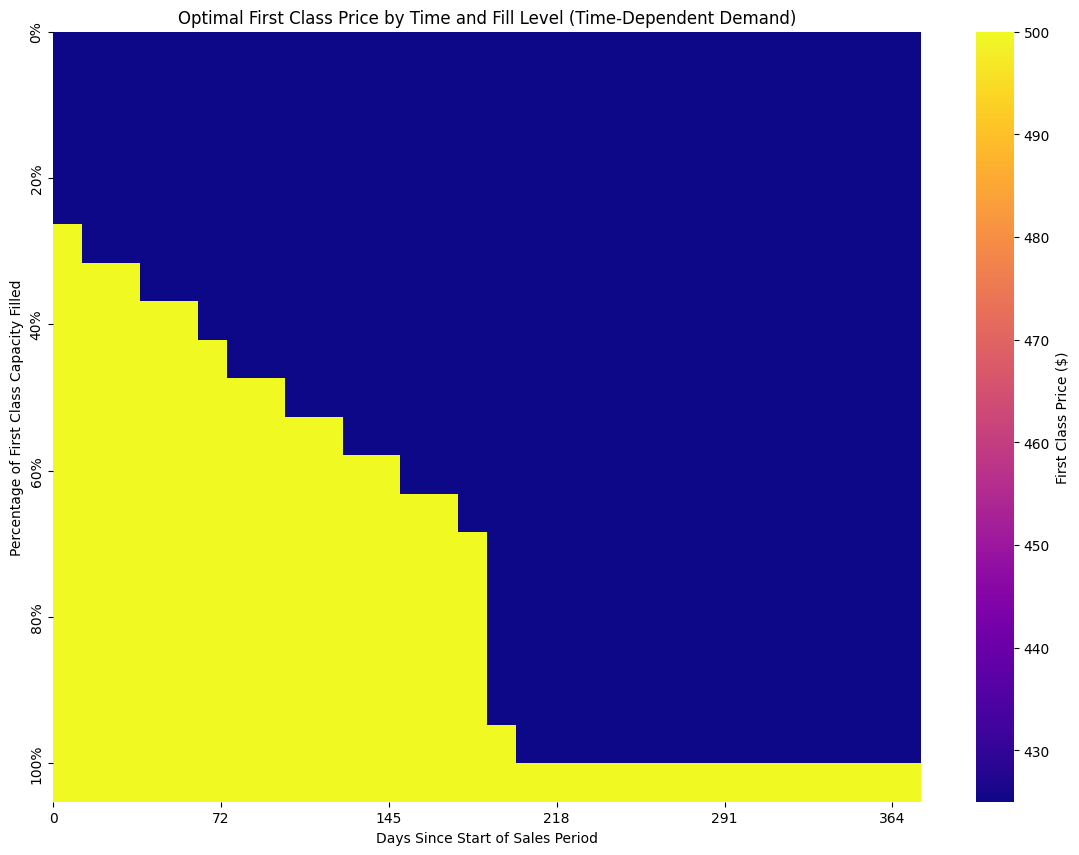

In [20]:
import numpy as np
from scipy.stats import binom
import matplotlib.pyplot as plt
import seaborn as sns
import time

def airline_dp_solution():
    """
    Solve the airline ticket pricing problem using dynamic programming,
    with corrected transition probability calculations and fixed visualizations.
    Enforces high price for first class when it's sold out.
    Includes time-dependent demand increase as departure approaches.
    """
    print("Starting airline ticket dynamic programming solution...")
    start_time = time.time()
    
    # Step 1: Initialize Parameters
    # Seat configuration
    coach_seats = 100
    first_class_seats = 20
    max_coach_overbooking = 9
    max_coach_tickets = coach_seats + max_coach_overbooking  # 109
    
    # Time horizon
    days_until_takeoff = 365
    
    # Pricing options
    coach_prices = [300, 350]
    first_class_prices = [425, 500]
    
    # Base sale probabilities (before time adjustment)
    base_coach_sale_prob = {
        300: 0.65,
        350: 0.30
    }
    # When first class is sold out
    base_coach_sale_prob_fc_sold_out = {
        300: 0.68,
        350: 0.33
    }
    base_first_class_sale_prob = {
        425: 0.08,
        500: 0.04
    }
    
    # Show-up probabilities
    coach_show_prob = 0.95
    first_class_show_prob = 0.97
    
    # Overbooking costs
    cost_bump_to_first_class = 50
    cost_bump_off_plane = 425
    
    # Discount rate
    annual_discount_rate = 0.17
    daily_discount_factor = 1 / (1 + annual_discount_rate / 365)
    
    print(f"Daily discount factor: {daily_discount_factor}")
    
    # Initialize state values and policy
    V = np.zeros((max_coach_tickets + 1, first_class_seats + 1, days_until_takeoff + 1))
    policy = np.zeros((max_coach_tickets + 1, first_class_seats + 1, days_until_takeoff + 1), dtype=int)
    
    # Step 2: Terminal day costs (day 365)
    print("Calculating terminal values...")
    
    # Terminal cost statistics
    terminal_cost_data = []
    
    for coach_sold in range(max_coach_tickets + 1):
        for fc_sold in range(first_class_seats + 1):
            # Calculate expected overbooking costs using binomial distribution
            cost = 0
            expected_bumped_to_fc = 0
            expected_bumped_off = 0
            
            # Generate all possible combinations of show-ups
            for coach_show in range(coach_sold + 1):
                coach_prob = binom.pmf(coach_show, coach_sold, coach_show_prob)
                
                for fc_show in range(fc_sold + 1):
                    fc_prob = binom.pmf(fc_show, fc_sold, first_class_show_prob)
                    
                    # Calculate probability of this exact scenario
                    scenario_prob = coach_prob * fc_prob
                    
                    # If coach is overbooked
                    if coach_show > coach_seats:
                        # Number of passengers to be bumped
                        bumped = coach_show - coach_seats
                        
                        # Available first class seats
                        available_fc = max(0, first_class_seats - fc_show)
                        
                        # Bump to first class if possible, otherwise off the plane
                        bumped_to_fc = min(bumped, available_fc)
                        bumped_off = bumped - bumped_to_fc
                        
                        # Track expected bumping for statistics
                        expected_bumped_to_fc += scenario_prob * bumped_to_fc
                        expected_bumped_off += scenario_prob * bumped_off
                        
                        # Calculate costs
                        scenario_cost = (bumped_to_fc * cost_bump_to_first_class) + (bumped_off * cost_bump_off_plane)
                        cost += scenario_prob * scenario_cost
            
            # Store terminal cost data for visualization
            if coach_sold >= 95:  # Only store for near-capacity situations
                terminal_cost_data.append({
                    'coach_sold': coach_sold,
                    'fc_sold': fc_sold,
                    'expected_cost': cost,
                    'expected_bumped_to_fc': expected_bumped_to_fc,
                    'expected_bumped_off': expected_bumped_off
                })
                
            V[coach_sold, fc_sold, -1] = -cost  # Negative because costs reduce value
    
    # Step 3: Backward induction - WITH TIME-DEPENDENT DEMAND
    print("Starting backward induction with time-dependent demand...")
    
    for day in range(days_until_takeoff - 1, -1, -1):
        if day % 50 == 0:
            print(f"Processing day {day}...")
        
        # Calculate time-dependent demand multiplier
        # Note: day is days until takeoff (counting down from 364 to 0)
        # We need to convert to days since sales start (counting up from 0 to 364)
        t = days_until_takeoff - 1 - day
        demand_multiplier = 0.75 + t/730
        
        # Time-adjusted sale probabilities for this day
        coach_sale_prob = {
            price: base_coach_sale_prob[price] * demand_multiplier
            for price in coach_prices
        }
        coach_sale_prob_fc_sold_out = {
            price: base_coach_sale_prob_fc_sold_out[price] * demand_multiplier
            for price in coach_prices
        }
        first_class_sale_prob = {
            price: base_first_class_sale_prob[price] * demand_multiplier
            for price in first_class_prices
        }
        
        # Cap probabilities at 1.0 (can't exceed 100%)
        for price in coach_prices:
            coach_sale_prob[price] = min(coach_sale_prob[price], 1.0)
            coach_sale_prob_fc_sold_out[price] = min(coach_sale_prob_fc_sold_out[price], 1.0)
        for price in first_class_prices:
            first_class_sale_prob[price] = min(first_class_sale_prob[price], 1.0)
            
        for coach_sold in range(max_coach_tickets + 1):
            for fc_sold in range(first_class_seats + 1):
                # Skip impossible states
                if coach_sold > max_coach_tickets or fc_sold > first_class_seats:
                    continue
                
                # Special handling for the case when first class is full
                if fc_sold == first_class_seats:
                    # When first class is sold out, we always use high price (index 1)
                    # We only need to decide on coach price
                    best_value = float('-inf')
                    best_action = -1
                    
                    # Try both coach prices with high FC price
                    for c_idx, coach_price in enumerate(coach_prices):
                        action = c_idx * 2 + 1  # Force high first class price (index 1)
                        
                        # Check coach availability
                        coach_available = coach_sold < max_coach_tickets
                        
                        # Calculate expected value
                        expected_revenue = 0
                        if coach_available:
                            # Use the increased probability when FC is sold out
                            c_prob = coach_sale_prob_fc_sold_out[coach_price]
                            expected_revenue += c_prob * coach_price
                        
                        # Calculate expected future value
                        expected_future_value = 0
                        
                        if not coach_available:
                            # If coach is also full, just move to next day
                            expected_future_value = V[coach_sold, fc_sold, day + 1]
                        else:
                            # Calculate probabilities for future states
                            prob_no_sale = 1 - c_prob
                            expected_future_value += prob_no_sale * V[coach_sold, fc_sold, day + 1]
                            
                            if coach_available:
                                expected_future_value += c_prob * V[coach_sold + 1, fc_sold, day + 1]
                        
                        # Calculate total value
                        current_value = expected_revenue + daily_discount_factor * expected_future_value
                        
                        if current_value > best_value:
                            best_value = current_value
                            best_action = action
                    
                    # Store best value and action
                    V[coach_sold, fc_sold, day] = best_value
                    policy[coach_sold, fc_sold, day] = best_action
                else:
                    # Regular processing for non-full first class
                    # Initialize for this state
                    best_value = float('-inf')
                    best_action = 0
                    
                    # Check availability
                    coach_available = coach_sold < max_coach_tickets
                    fc_available = fc_sold < first_class_seats
                    
                    # If both are sold out, just move to next day
                    if not coach_available and not fc_available:
                        V[coach_sold, fc_sold, day] = daily_discount_factor * V[coach_sold, fc_sold, day + 1]
                        continue
                    
                    # Try all pricing combinations (actions)
                    for c_idx, coach_price in enumerate(coach_prices):
                        for f_idx, fc_price in enumerate(first_class_prices):
                            action = c_idx * 2 + f_idx
                            
                            # Determine probabilities based on availability and pricing
                            c_prob = 0  # Coach sale probability
                            if coach_available:
                                if fc_sold == first_class_seats:  # This case is handled separately now
                                    c_prob = coach_sale_prob_fc_sold_out[coach_price]
                                else:
                                    c_prob = coach_sale_prob[coach_price]
                                    
                            f_prob = 0  # First class sale probability
                            if fc_available:
                                f_prob = first_class_sale_prob[fc_price]
                            
                            # Calculate expected immediate revenue
                            expected_revenue = 0
                            if coach_available:
                                expected_revenue += c_prob * coach_price
                            if fc_available:
                                expected_revenue += f_prob * fc_price
                            
                            # Calculate expected future value considering all possible combinations
                            expected_future_value = 0
                            
                            # Case 1: Neither ticket sells
                            prob_neither = (1 - c_prob if coach_available else 1) * (1 - f_prob if fc_available else 1)
                            expected_future_value += prob_neither * V[coach_sold, fc_sold, day + 1]
                            
                            # Case 2: Only coach sells
                            if coach_available:
                                prob_only_coach = c_prob * (1 - f_prob if fc_available else 1)
                                expected_future_value += prob_only_coach * V[coach_sold + 1, fc_sold, day + 1]
                            
                            # Case 3: Only first class sells
                            if fc_available:
                                prob_only_fc = (1 - c_prob if coach_available else 1) * f_prob
                                expected_future_value += prob_only_fc * V[coach_sold, fc_sold + 1, day + 1]
                            
                            # Case 4: Both sell
                            if coach_available and fc_available:
                                prob_both = c_prob * f_prob
                                expected_future_value += prob_both * V[coach_sold + 1, fc_sold + 1, day + 1]
                            
                            # Total expected value = immediate revenue + discounted future value
                            current_value = expected_revenue + daily_discount_factor * expected_future_value
                            
                            # Update if this is the best action
                            if current_value > best_value:
                                best_value = current_value
                                best_action = action
                    
                    # Store best value and action
                    V[coach_sold, fc_sold, day] = best_value
                    policy[coach_sold, fc_sold, day] = best_action
    
    elapsed_time = time.time() - start_time
    print(f"Dynamic programming solution completed in {elapsed_time:.2f} seconds")
    
    # Step 4: Run a simulation to validate and collect detailed statistics
    def simulate_flights(num_simulations=50000):
        """Simulate flights using the optimal policy and collect detailed statistics."""
        print(f"Running {num_simulations} simulations with detailed statistics...")
        
        total_revenue = 0
        
        # Statistics tracking
        coach_tickets_sold = []
        fc_tickets_sold = []
        bumped_to_fc_counts = []
        bumped_off_counts = []
        total_bumped_counts = []
        overbooking_costs = []
        ticket_revenues = []
        discounted_overbooking_costs = []
        
        # Helper function to convert action to prices
        def get_prices(action):
            coach_idx = action // 2
            fc_idx = action % 2
            return coach_prices[coach_idx], first_class_prices[fc_idx]
        
        for sim in range(num_simulations):
            if sim % 5000 == 0 and sim > 0:
                print(f"Completed {sim} simulations...")
                
            # Starting state
            coach_sold = 0
            fc_sold = 0
            ticket_revenue = 0
            
            # Daily ticket sales
            for day in range(days_until_takeoff):
                # Calculate time-dependent demand multiplier for this day
                t = day  # Day since start of sales
                demand_multiplier = 0.75 + t/730
                
                # Get optimal pricing for current state
                action = policy[coach_sold, fc_sold, day]
                coach_price, fc_price = get_prices(action)
                
                # Coach sales
                if coach_sold < max_coach_tickets:
                    # Determine time-adjusted probability based on first class availability
                    if fc_sold == first_class_seats:
                        sale_prob = base_coach_sale_prob_fc_sold_out[coach_price] * demand_multiplier
                    else:
                        sale_prob = base_coach_sale_prob[coach_price] * demand_multiplier
                    
                    # Cap probability at 1.0
                    sale_prob = min(sale_prob, 1.0)
                    
                    # Simulate sale
                    if np.random.random() < sale_prob:
                        coach_sold += 1
                        ticket_revenue += coach_price * (daily_discount_factor ** day)
                
                # First class sales
                if fc_sold < first_class_seats:
                    # Determine time-adjusted probability
                    sale_prob = base_first_class_sale_prob[fc_price] * demand_multiplier
                    
                    # Cap probability at 1.0
                    sale_prob = min(sale_prob, 1.0)
                    
                    # Simulate sale
                    if np.random.random() < sale_prob:
                        fc_sold += 1
                        ticket_revenue += fc_price * (daily_discount_factor ** day)
            
            # Record tickets sold
            coach_tickets_sold.append(coach_sold)
            fc_tickets_sold.append(fc_sold)
            
            # Flight day costs (overbooking)
            coach_show = np.random.binomial(coach_sold, coach_show_prob)
            fc_show = np.random.binomial(fc_sold, first_class_show_prob)
            
            # Initialize bumping counters
            bumped_to_fc = 0
            bumped_off = 0
            flight_overbooking_cost = 0
            
            # Calculate overbooking costs
            if coach_show > coach_seats:
                # Total passengers to bump
                to_bump = coach_show - coach_seats
                
                # Available first class seats
                available_fc = max(0, first_class_seats - fc_show)
                
                # How many get bumped to each category
                bumped_to_fc = min(to_bump, available_fc)
                bumped_off = to_bump - bumped_to_fc
                
                # Calculate costs
                flight_overbooking_cost = (bumped_to_fc * cost_bump_to_first_class) + (bumped_off * cost_bump_off_plane)
                
                # CRITICAL FIX: Apply discount factor correctly to match DP approach
                # In the DP solution, the terminal cost is recursively discounted through Bellman's equation
                # From day 0's perspective, this is equivalent to discounting by daily_discount_factor^days_until_takeoff
                discounted_cost = flight_overbooking_cost * (daily_discount_factor ** days_until_takeoff)
                ticket_revenue -= discounted_cost
                discounted_overbooking_costs.append(discounted_cost)
            else:
                discounted_overbooking_costs.append(0)
            
            # Record bumping statistics
            bumped_to_fc_counts.append(bumped_to_fc)
            bumped_off_counts.append(bumped_off)
            total_bumped_counts.append(bumped_to_fc + bumped_off)
            overbooking_costs.append(flight_overbooking_cost)
            ticket_revenues.append(ticket_revenue)
            
            # Add to total revenue
            total_revenue += ticket_revenue
        
        # Calculate summary statistics
        avg_coach_sold = np.mean(coach_tickets_sold)
        avg_fc_sold = np.mean(fc_tickets_sold)
        avg_bumped_to_fc = np.mean(bumped_to_fc_counts)
        avg_bumped_off = np.mean(bumped_off_counts)
        avg_total_bumped = np.mean(total_bumped_counts)
        avg_overbooking_cost = np.mean(overbooking_costs)
        avg_discounted_overbooking_cost = np.mean(discounted_overbooking_costs)
        avg_ticket_revenue = np.mean(ticket_revenues)
        
        # Calculate percentages
        pct_flights_with_bumping = 100 * np.sum(np.array(total_bumped_counts) > 0) / num_simulations
        total_coach_passengers = np.sum(np.array(coach_tickets_sold) * coach_show_prob)
        pct_coach_passengers_bumped = 100 * np.sum(total_bumped_counts) / total_coach_passengers if total_coach_passengers > 0 else 0
        
        # Print detailed statistics
        print("\nDetailed Bumping Statistics:")
        print(f"Average coach tickets sold: {avg_coach_sold:.2f} out of {max_coach_tickets}")
        print(f"Average first class tickets sold: {avg_fc_sold:.2f} out of {first_class_seats}")
        print(f"Average passengers bumped to first class: {avg_bumped_to_fc:.4f}")
        print(f"Average passengers bumped off plane: {avg_bumped_off:.4f}")
        print(f"Average total passengers bumped: {avg_total_bumped:.4f}")
        print(f"Percentage of flights with any bumping: {pct_flights_with_bumping:.2f}%")
        print(f"Percentage of coach passengers bumped: {pct_coach_passengers_bumped:.4f}%")
        print(f"Average raw overbooking cost per flight: ${avg_overbooking_cost:.2f}")
        print(f"Average discounted overbooking cost per flight: ${avg_discounted_overbooking_cost:.2f}")
        print(f"Average ticket revenue per flight: ${avg_ticket_revenue:.2f}")
        
        # Create visualizations
        
        # 1. Histogram of number of passengers bumped to first class
        plt.figure(figsize=(10, 6))
        plt.hist(bumped_to_fc_counts, bins=range(max(bumped_to_fc_counts)+2), alpha=0.7)
        plt.xlabel('Number of Passengers Bumped to First Class')
        plt.ylabel('Frequency')
        plt.title('Distribution of Passengers Bumped to First Class')
        plt.grid(True)
        plt.savefig('bumped_to_fc_histogram.png')
        
        # 2. Histogram of number of passengers bumped off plane
        plt.figure(figsize=(10, 6))
        plt.hist(bumped_off_counts, bins=range(max(bumped_off_counts)+2), alpha=0.7)
        plt.xlabel('Number of Passengers Bumped Off Plane')
        plt.ylabel('Frequency')
        plt.title('Distribution of Passengers Bumped Off Plane')
        plt.grid(True)
        plt.savefig('bumped_off_histogram.png')
        
        # 3. Visualize time-dependent demand multiplier
        plt.figure(figsize=(12, 6))
        days = np.arange(days_until_takeoff)
        demand_multipliers = 0.75 + days/730
        plt.plot(days, demand_multipliers, 'b-')
        plt.axhline(y=1.0, color='r', linestyle='--', label='Original demand level')
        plt.xlabel('Days Since Start of Sales Period')
        plt.ylabel('Demand Multiplier')
        plt.title('Time-Dependent Demand Multiplier')
        plt.grid(True)
        plt.legend()
        plt.savefig('demand_multiplier.png')
        
        # 4. Visualize adjusted sale probabilities for $300 coach ticket
        plt.figure(figsize=(12, 6))
        days = np.arange(days_until_takeoff)
        base_prob = base_coach_sale_prob[300]
        adjusted_probs = np.minimum(base_prob * (0.75 + days/730), 1.0)
        plt.plot(days, adjusted_probs, 'g-', label=f'Adjusted ($300 coach)')
        plt.axhline(y=base_prob, color='r', linestyle='--', label=f'Original ({base_prob*100:.1f}%)')
        plt.xlabel('Days Since Start of Sales Period')
        plt.ylabel('Sale Probability')
        plt.title('Time-Adjusted Sale Probability for $300 Coach Ticket')
        plt.grid(True)
        plt.legend()
        plt.savefig('adjusted_sale_probability.png')
        
        # 5. Visualize ticket revenue distribution
        plt.figure(figsize=(12, 6))
        plt.hist(ticket_revenues, bins=50, alpha=0.7)
        plt.axvline(x=np.mean(ticket_revenues), color='r', linestyle='--', label=f'Mean: ${np.mean(ticket_revenues):.2f}')
        plt.xlabel('Ticket Revenue ($)')
        plt.ylabel('Frequency')
        plt.title('Distribution of Ticket Revenue')
        plt.grid(True)
        plt.legend()
        plt.savefig('ticket_revenue_distribution.png')
        
        # Statistics dictionary
        statistics = {
            'avg_coach_sold': avg_coach_sold,
            'avg_fc_sold': avg_fc_sold,
            'avg_bumped_to_fc': avg_bumped_to_fc,
            'avg_bumped_off': avg_bumped_off,
            'avg_total_bumped': avg_total_bumped,
            'pct_flights_with_bumping': pct_flights_with_bumping,
            'pct_coach_passengers_bumped': pct_coach_passengers_bumped,
            'avg_overbooking_cost': avg_overbooking_cost,
            'avg_discounted_overbooking_cost': avg_discounted_overbooking_cost,
            'avg_ticket_revenue': avg_ticket_revenue,
            'coach_tickets_sold': coach_tickets_sold,
            'fc_tickets_sold': fc_tickets_sold,
            'bumped_to_fc_counts': bumped_to_fc_counts,
            'bumped_off_counts': bumped_off_counts,
            'total_bumped_counts': total_bumped_counts,
            'overbooking_costs': overbooking_costs,
            'discounted_overbooking_costs': discounted_overbooking_costs,
            'ticket_revenues': ticket_revenues
        }
        
        return total_revenue / num_simulations, statistics
    
    # Create policy visualizations
    def create_policy_visualizations():
        """
        Create visualizations showing pricing strategy evolution over time.
        """
        print("Creating policy visualizations...")
        
        # Helper function to get prices from action
        def get_prices(action):
            coach_idx = action // 2
            fc_idx = action % 2
            return coach_prices[coach_idx], first_class_prices[fc_idx]
        
        # 1. Price evolution over time at different inventory levels
        days_to_check = np.linspace(0, days_until_takeoff-1, 15, dtype=int)  # 15 time points
        
        # Define inventory levels to check (percentage of capacity filled)
        # For coach: 0%, 25%, 50%, 75%, 90%, 100%, 105% (max with overbooking)
        # For first class: 0%, 25%, 50%, 75%, 90%, 100% (max capacity)
        coach_fill_levels = [0.0, 0.25, 0.50, 0.75, 0.90, 1.0, 1.05]
        fc_fill_levels = [0.0, 0.25, 0.50, 0.75, 0.90, 1.0]
        
        # Prepare arrays for the data
        coach_price_data = np.zeros((len(coach_fill_levels), len(days_to_check)))
        fc_price_data = np.zeros((len(fc_fill_levels), len(days_to_check)))
        
        # Fill the arrays with pricing data for coach
        for i, fill_level in enumerate(coach_fill_levels):
            coach_sold = min(int(fill_level * coach_seats), max_coach_tickets)
            fc_sold = 0  # Start with no first class tickets sold
            
            for j, day in enumerate(days_to_check):
                action = policy[coach_sold, fc_sold, day]
                coach_price, _ = get_prices(action)
                coach_price_data[i, j] = coach_price
        
        # Fill the arrays with pricing data for first class
        for i, fill_level in enumerate(fc_fill_levels):
            fc_sold = min(int(fill_level * first_class_seats), first_class_seats)
            coach_sold = 0  # Start with no coach tickets sold
            
            for j, day in enumerate(days_to_check):
                action = policy[coach_sold, fc_sold, day]
                _, fc_price = get_prices(action)
                fc_price_data[i, j] = fc_price
        
        # Plot coach price evolution
        plt.figure(figsize=(14, 8))
        for i, fill_level in enumerate(coach_fill_levels):
            plt.plot(days_to_check, coach_price_data[i], 'o-', 
                    label=f"{int(fill_level*100)}% Coach Filled ({int(fill_level*coach_seats)} seats)")
        
        plt.xlabel('Days Since Start of Sales Period')
        plt.ylabel('Optimal Coach Price ($)')
        plt.title('Coach Price Evolution Over Time at Different Fill Levels (Time-Dependent Demand)')
        plt.grid(True)
        plt.legend()
        plt.savefig('coach_price_evolution_by_fill.png')
        
        # Plot first class price evolution
        plt.figure(figsize=(14, 8))
        for i, fill_level in enumerate(fc_fill_levels):
            plt.plot(days_to_check, fc_price_data[i], 's-', 
                    label=f"{int(fill_level*100)}% First Class Filled ({int(fill_level*first_class_seats)} seats)")
        
        plt.xlabel('Days Since Start of Sales Period')
        plt.ylabel('Optimal First Class Price ($)')
        plt.title('First Class Price Evolution Over Time at Different Fill Levels (Time-Dependent Demand)')
        plt.grid(True)
        plt.legend()
        plt.savefig('fc_price_evolution_by_fill.png')
        
        # 2. Create price heatmaps with properly fixed axes
        
        # For days, use evenly spaced points from 0 to days_until_takeoff-1
        days_points = np.linspace(0, days_until_takeoff-1, 30, dtype=int)
        
        # For coach fill levels, use points from 0% to 105% (accounting for overbooking)
        coach_fill_points = np.linspace(0, max_coach_tickets/coach_seats, 20)
        
        # For first class fill levels, use points from 0% to 100%
        fc_fill_points = np.linspace(0, 1.0, 20)
        
        # Arrays for heatmaps
        coach_heatmap = np.zeros((len(coach_fill_points), len(days_points)))
        fc_heatmap = np.zeros((len(fc_fill_points), len(days_points)))
        
        # Fill the coach heatmap data
        for i, fill in enumerate(coach_fill_points):
            coach_sold = min(int(fill * coach_seats), max_coach_tickets)
            fc_sold = 0  # Keep first class empty to isolate coach effect
            
            for j, day in enumerate(days_points):
                action = policy[coach_sold, fc_sold, day]
                coach_price, _ = get_prices(action)
                coach_heatmap[i, j] = coach_price
        
        # Fill the first class heatmap data
        for i, fill in enumerate(fc_fill_points):
            fc_sold = min(int(fill * first_class_seats), first_class_seats)
            coach_sold = 0  # Keep coach empty to isolate first class effect
            
            for j, day in enumerate(days_points):
                action = policy[coach_sold, fc_sold, day]
                _, fc_price = get_prices(action)
                fc_heatmap[i, j] = fc_price
        
        # Create coach price heatmap
        plt.figure(figsize=(14, 10))
        
        # Create the heatmap without automatic tick labels
        ax = sns.heatmap(coach_heatmap, cmap='viridis', cbar_kws={'label': 'Coach Price ($)'})
        
        # Explicitly set the tick locations and labels
        x_ticks = np.linspace(0, len(days_points)-1, 6)  # 6 evenly spaced ticks
        x_labels = [f"{int(d)}" for d in np.linspace(0, days_until_takeoff-1, 6)]  # 0, 73, 146, 219, 292, 365
        
        y_ticks = np.linspace(0, len(coach_fill_points)-1, 8)  # 8 evenly spaced ticks
        y_labels = [f"{int(p)}%" for p in np.linspace(0, 105, 8)]  # 0%, 15%, 30%, ..., 105%
        
        # Set the tick positions and labels
        plt.xticks(x_ticks, x_labels)
        plt.yticks(y_ticks, y_labels)
        
        plt.xlabel('Days Since Start of Sales Period')
        plt.ylabel('Percentage of Coach Capacity Filled (including overbooking)')
        plt.title('Optimal Coach Price by Time and Fill Level (Time-Dependent Demand)')
        plt.savefig('coach_price_heatmap.png')
        
        # Create first class price heatmap
        plt.figure(figsize=(14, 10))
        
        # Create the heatmap without automatic tick labels
        ax = sns.heatmap(fc_heatmap, cmap='plasma', cbar_kws={'label': 'First Class Price ($)'})
        
        # Explicitly set the tick locations and labels
        x_ticks = np.linspace(0, len(days_points)-1, 6)  # 6 evenly spaced ticks
        x_labels = [f"{int(d)}" for d in np.linspace(0, days_until_takeoff-1, 6)]  # 0, 73, 146, 219, 292, 365
        
        y_ticks = np.linspace(0, len(fc_fill_points)-1, 6)  # 6 evenly spaced ticks
        y_labels = [f"{int(p)}%" for p in np.linspace(0, 100, 6)]  # 0%, 20%, 40%, ..., 100%
        
        # Set the tick positions and labels
        plt.xticks(x_ticks, x_labels)
        plt.yticks(y_ticks, y_labels)
        
        plt.xlabel('Days Since Start of Sales Period')
        plt.ylabel('Percentage of First Class Capacity Filled')
        plt.title('Optimal First Class Price by Time and Fill Level (Time-Dependent Demand)')
        plt.savefig('fc_price_heatmap.png')
        
        print("Policy visualizations created successfully!")
    
    # Get the expected profit from DP solution
    expected_profit = V[0, 0, 0]
    print(f"Expected profit from time-dependent DP solution: ${expected_profit:.2f}")
    
    # Validate with simulation and collect statistics
    simulated_profit, statistics = simulate_flights(50000)
    print(f"Expected profit from simulation: ${simulated_profit:.2f}")
    print(f"Difference: ${abs(expected_profit - simulated_profit):.2f}")
    print(f"Difference percentage: {100 * abs(expected_profit - simulated_profit) / expected_profit:.2f}%")
    
    # Create policy visualizations
    create_policy_visualizations()
    
    return {
        'expected_profit': expected_profit,
        'simulated_profit': simulated_profit,
        'value_function': V,
        'policy': policy,
        'statistics': statistics
    }

# Run the solution
results = airline_dp_solution()

# Output the final answer with detailed statistics on bumping
print("\n" + "="*50)
print("AIRLINE TICKET PRICING OPTIMIZATION RESULTS (TIME-DEPENDENT DEMAND)")
print("="*50)
print(f"Final Expected Discounted Profit: ${results['expected_profit']:.2f}")
print(f"Final Simulated Discounted Profit: ${results['simulated_profit']:.2f}")
print(f"Difference: ${abs(results['expected_profit'] - results['simulated_profit']):.2f}")
print(f"Difference percentage: {100 * abs(results['expected_profit'] - results['simulated_profit']) / results['expected_profit']:.2f}%")
print("\nBUMPING STATISTICS SUMMARY:")
print(f"Average passengers bumped to first class per flight: {results['statistics']['avg_bumped_to_fc']:.4f}")
print(f"Average passengers bumped off plane per flight: {results['statistics']['avg_bumped_off']:.4f}")
print(f"Percentage of flights with any bumping: {results['statistics']['pct_flights_with_bumping']:.2f}%")
print(f"Percentage of coach passengers bumped: {results['statistics']['pct_coach_passengers_bumped']:.4f}%")
print(f"Average raw overbooking cost per flight: ${results['statistics']['avg_overbooking_cost']:.2f}")
print(f"Average discounted overbooking cost per flight: ${results['statistics']['avg_discounted_overbooking_cost']:.2f}")
print("="*50)

Simulation/DP for base optimal (9) overbooking policy

Starting airline ticket dynamic programming solution...
Daily discount factor: 0.999534463400608
Calculating terminal values...
Starting backward induction with corrected transition probabilities...
Processing day 350...
Processing day 300...
Processing day 250...
Processing day 200...
Processing day 150...
Processing day 100...
Processing day 50...
Processing day 0...
Dynamic programming solution completed in 100.36 seconds
Expected profit from corrected DP solution: $41886.16
Running 10000 simulations with detailed statistics...
Completed 1000 simulations...
Completed 2000 simulations...
Completed 3000 simulations...
Completed 4000 simulations...
Completed 5000 simulations...
Completed 6000 simulations...
Completed 7000 simulations...
Completed 8000 simulations...
Completed 9000 simulations...

Detailed Bumping Statistics:
Average coach tickets sold: 104.96 out of 105
Average first class tickets sold: 19.80 out of 20
Average passengers bumped to first class: 0.2450
Average passengers

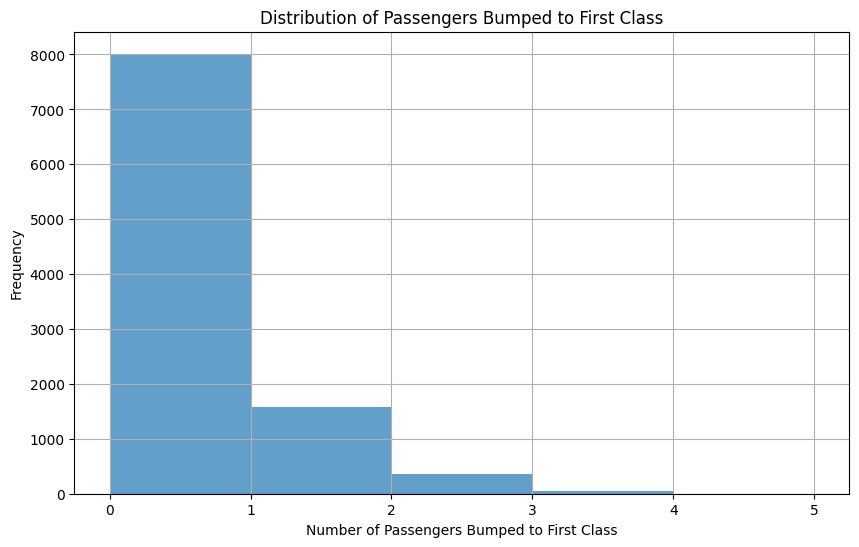

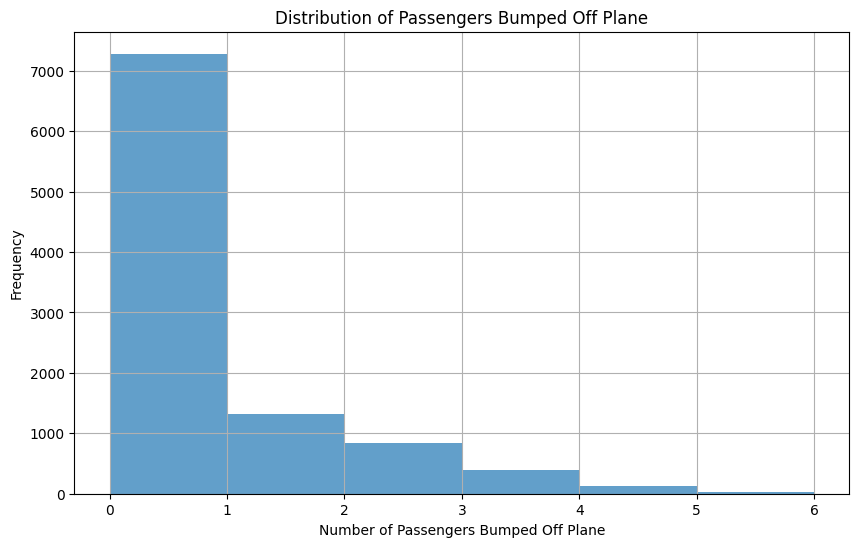

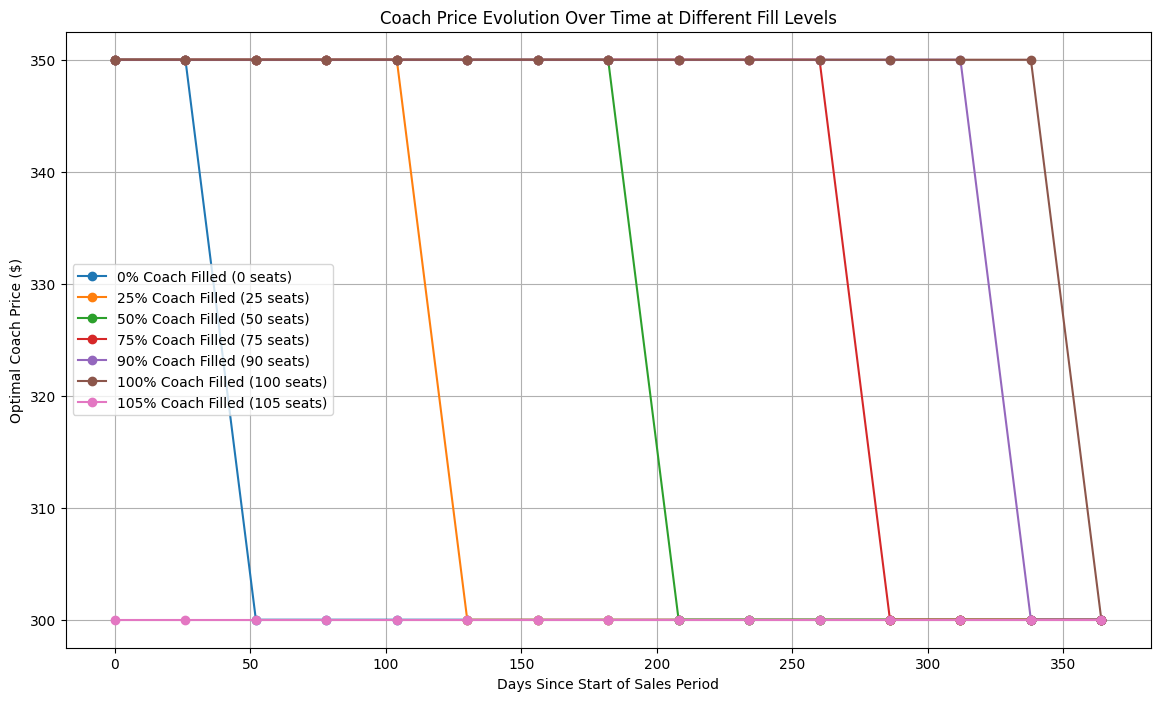

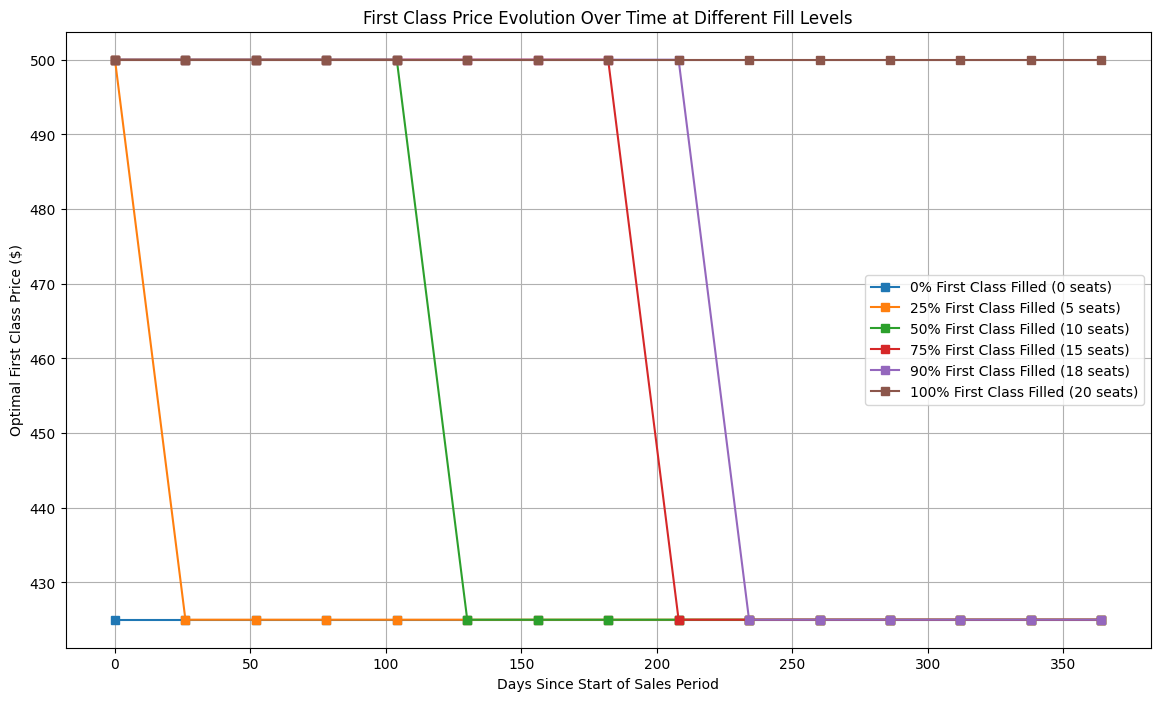

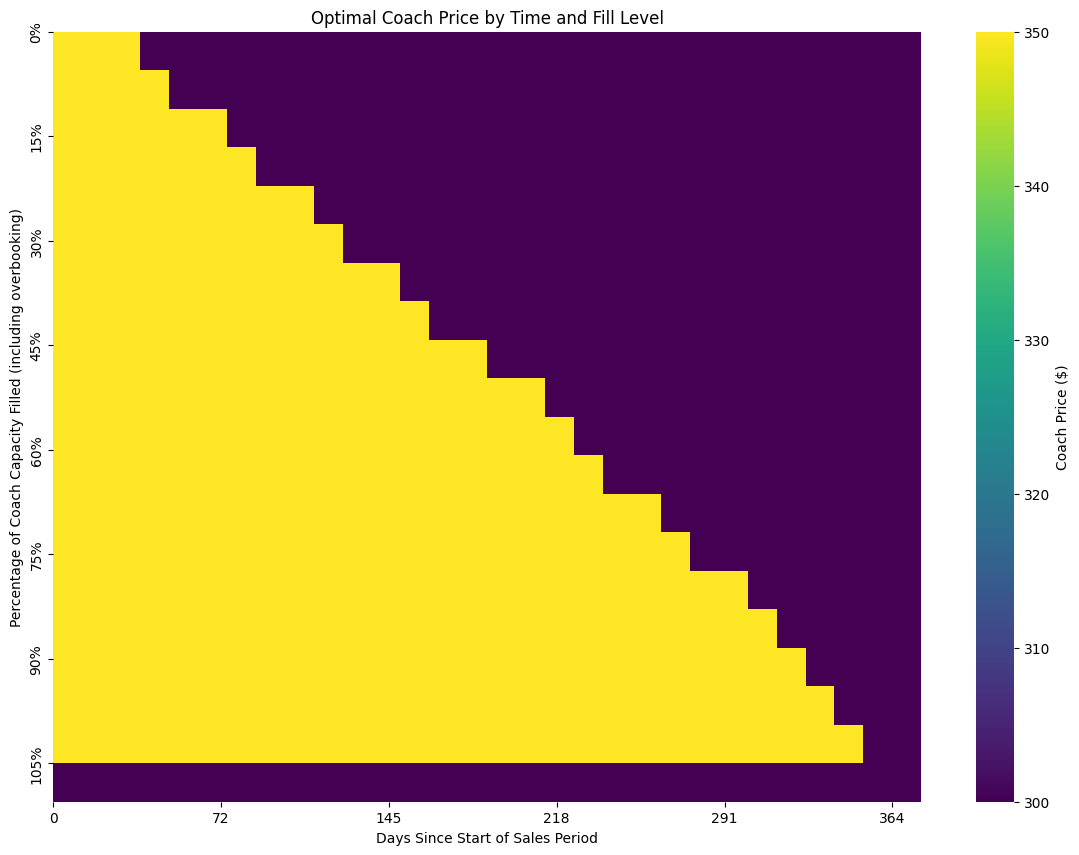

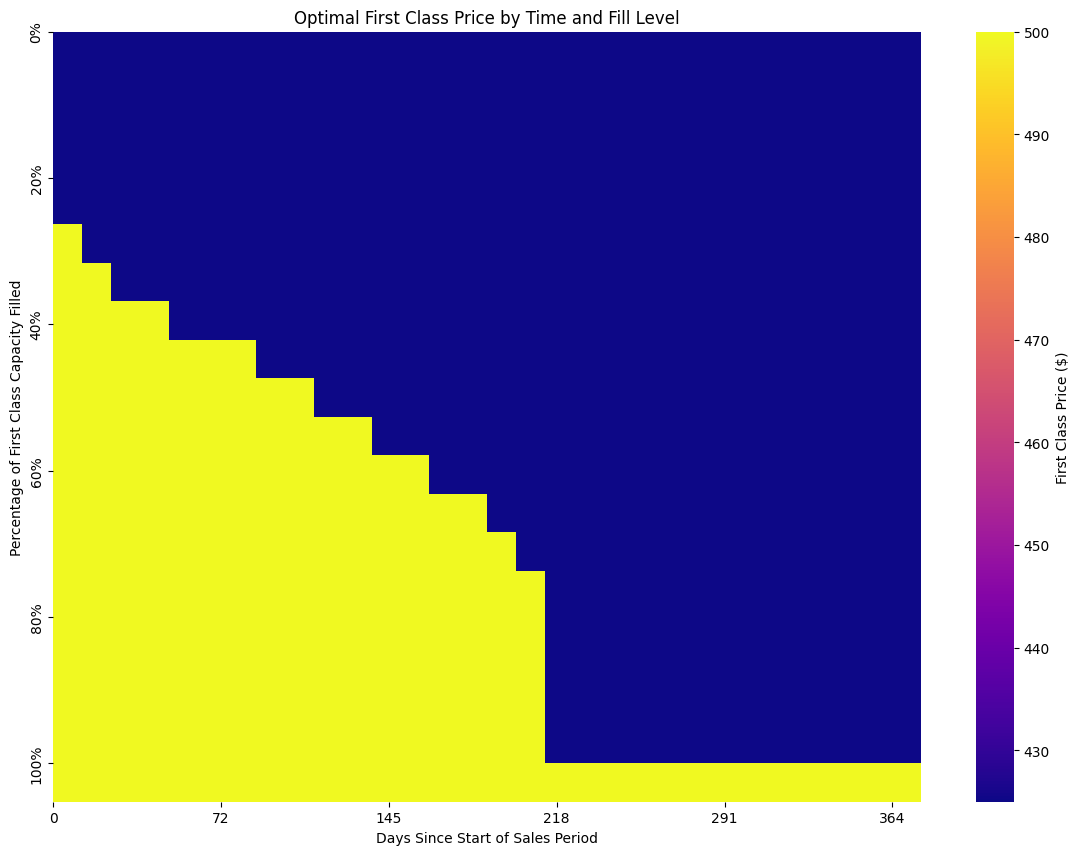

In [ ]:
import numpy as np
from scipy.stats import binom
import matplotlib.pyplot as plt
import seaborn as sns
import time

def airline_dp_solution():
    """
    Solve the airline ticket pricing problem using dynamic programming,
    with corrected transition probability calculations and fixed visualizations.
    Enforces high price for first class when it's sold out.
    """
    print("Starting airline ticket dynamic programming solution...")
    start_time = time.time()
    
    # Step 1: Initialize Parameters
    # Seat configuration
    coach_seats = 100
    first_class_seats = 20
    max_coach_overbooking = 9
    max_coach_tickets = coach_seats + max_coach_overbooking  # 105
    
    # Time horizon
    days_until_takeoff = 365
    
    # Pricing options
    coach_prices = [300, 350]
    first_class_prices = [425, 500]
    
    # Sale probabilities
    coach_sale_prob = {
        300: 0.65,
        350: 0.30
    }
    # When first class is sold out
    coach_sale_prob_fc_sold_out = {
        300: 0.68,
        350: 0.33
    }
    first_class_sale_prob = {
        425: 0.08,
        500: 0.04
    }
    
    # Show-up probabilities
    coach_show_prob = 0.95
    first_class_show_prob = 0.97
    
    # Overbooking costs
    cost_bump_to_first_class = 50
    cost_bump_off_plane = 425
    
    # Discount rate
    annual_discount_rate = 0.17
    daily_discount_factor = 1 / (1 + annual_discount_rate / 365)
    
    print(f"Daily discount factor: {daily_discount_factor}")
    
    # Initialize state values and policy
    V = np.zeros((max_coach_tickets + 1, first_class_seats + 1, days_until_takeoff + 1))
    policy = np.zeros((max_coach_tickets + 1, first_class_seats + 1, days_until_takeoff + 1), dtype=int)
    
    # Step 2: Terminal day costs (day 365)
    print("Calculating terminal values...")
    
    # Terminal cost statistics
    terminal_cost_data = []
    
    for coach_sold in range(max_coach_tickets + 1):
        for fc_sold in range(first_class_seats + 1):
            # Calculate expected overbooking costs using binomial distribution
            cost = 0
            expected_bumped_to_fc = 0
            expected_bumped_off = 0
            
            # Generate all possible combinations of show-ups
            for coach_show in range(coach_sold + 1):
                coach_prob = binom.pmf(coach_show, coach_sold, coach_show_prob)
                
                for fc_show in range(fc_sold + 1):
                    fc_prob = binom.pmf(fc_show, fc_sold, first_class_show_prob)
                    
                    # Calculate probability of this exact scenario
                    scenario_prob = coach_prob * fc_prob
                    
                    # If coach is overbooked
                    if coach_show > coach_seats:
                        # Number of passengers to be bumped
                        bumped = coach_show - coach_seats
                        
                        # Available first class seats
                        available_fc = max(0, first_class_seats - fc_show)
                        
                        # Bump to first class if possible, otherwise off the plane
                        bumped_to_fc = min(bumped, available_fc)
                        bumped_off = bumped - bumped_to_fc
                        
                        # Track expected bumping for statistics
                        expected_bumped_to_fc += scenario_prob * bumped_to_fc
                        expected_bumped_off += scenario_prob * bumped_off
                        
                        # Calculate costs
                        scenario_cost = (bumped_to_fc * cost_bump_to_first_class) + (bumped_off * cost_bump_off_plane)
                        cost += scenario_prob * scenario_cost
            
            # Store terminal cost data for visualization
            if coach_sold >= 95:  # Only store for near-capacity situations
                terminal_cost_data.append({
                    'coach_sold': coach_sold,
                    'fc_sold': fc_sold,
                    'expected_cost': cost,
                    'expected_bumped_to_fc': expected_bumped_to_fc,
                    'expected_bumped_off': expected_bumped_off
                })
                
            V[coach_sold, fc_sold, -1] = -cost  # Negative because costs reduce value
    
    # Step 3: Backward induction - CORRECTED IMPLEMENTATION
    print("Starting backward induction with corrected transition probabilities...")
    
    for day in range(days_until_takeoff - 1, -1, -1):
        if day % 50 == 0:
            print(f"Processing day {day}...")
            
        for coach_sold in range(max_coach_tickets + 1):
            for fc_sold in range(first_class_seats + 1):
                # Skip impossible states
                if coach_sold > max_coach_tickets or fc_sold > first_class_seats:
                    continue
                
                # Special handling for the case when first class is full
                if fc_sold == first_class_seats:
                    # When first class is sold out, we always use high price (index 1)
                    # We only need to decide on coach price
                    best_value = float('-inf')
                    best_action = -1
                    
                    # Try both coach prices with high FC price
                    for c_idx, coach_price in enumerate(coach_prices):
                        action = c_idx * 2 + 1  # Force high first class price (index 1)
                        
                        # Check coach availability
                        coach_available = coach_sold < max_coach_tickets
                        
                        # Calculate expected value
                        expected_revenue = 0
                        if coach_available:
                            # Use the increased probability when FC is sold out
                            c_prob = coach_sale_prob_fc_sold_out[coach_price]
                            expected_revenue += c_prob * coach_price
                        
                        # Calculate expected future value
                        expected_future_value = 0
                        
                        if not coach_available:
                            # If coach is also full, just move to next day
                            expected_future_value = V[coach_sold, fc_sold, day + 1]
                        else:
                            # Calculate probabilities for future states
                            prob_no_sale = 1 - c_prob
                            expected_future_value += prob_no_sale * V[coach_sold, fc_sold, day + 1]
                            
                            if coach_available:
                                expected_future_value += c_prob * V[coach_sold + 1, fc_sold, day + 1]
                        
                        # Calculate total value
                        current_value = expected_revenue + daily_discount_factor * expected_future_value
                        
                        if current_value > best_value:
                            best_value = current_value
                            best_action = action
                    
                    # Store best value and action
                    V[coach_sold, fc_sold, day] = best_value
                    policy[coach_sold, fc_sold, day] = best_action
                else:
                    # Regular processing for non-full first class
                    # Initialize for this state
                    best_value = float('-inf')
                    best_action = 0
                    
                    # Check availability
                    coach_available = coach_sold < max_coach_tickets
                    fc_available = fc_sold < first_class_seats
                    
                    # If both are sold out, just move to next day
                    if not coach_available and not fc_available:
                        V[coach_sold, fc_sold, day] = daily_discount_factor * V[coach_sold, fc_sold, day + 1]
                        continue
                    
                    # Try all pricing combinations (actions)
                    for c_idx, coach_price in enumerate(coach_prices):
                        for f_idx, fc_price in enumerate(first_class_prices):
                            action = c_idx * 2 + f_idx
                            
                            # CORRECTED: Calculate expected value properly without double-counting
                            
                            # Determine probabilities based on availability and pricing
                            c_prob = 0  # Coach sale probability
                            if coach_available:
                                if fc_sold == first_class_seats:  # This case is handled separately now
                                    c_prob = coach_sale_prob_fc_sold_out[coach_price]
                                else:
                                    c_prob = coach_sale_prob[coach_price]
                                    
                            f_prob = 0  # First class sale probability
                            if fc_available:
                                f_prob = first_class_sale_prob[fc_price]
                            
                            # Calculate expected immediate revenue
                            expected_revenue = 0
                            if coach_available:
                                expected_revenue += c_prob * coach_price
                            if fc_available:
                                expected_revenue += f_prob * fc_price
                            
                            # Calculate expected future value considering all possible combinations
                            # NOTE: We calculate this ONCE, not separately for each ticket type
                            expected_future_value = 0
                            
                            # Case 1: Neither ticket sells
                            prob_neither = (1 - c_prob if coach_available else 1) * (1 - f_prob if fc_available else 1)
                            expected_future_value += prob_neither * V[coach_sold, fc_sold, day + 1]
                            
                            # Case 2: Only coach sells
                            if coach_available:
                                prob_only_coach = c_prob * (1 - f_prob if fc_available else 1)
                                expected_future_value += prob_only_coach * V[coach_sold + 1, fc_sold, day + 1]
                            
                            # Case 3: Only first class sells
                            if fc_available:
                                prob_only_fc = (1 - c_prob if coach_available else 1) * f_prob
                                expected_future_value += prob_only_fc * V[coach_sold, fc_sold + 1, day + 1]
                            
                            # Case 4: Both sell
                            if coach_available and fc_available:
                                prob_both = c_prob * f_prob
                                expected_future_value += prob_both * V[coach_sold + 1, fc_sold + 1, day + 1]
                            
                            # Total expected value = immediate revenue + discounted future value
                            current_value = expected_revenue + daily_discount_factor * expected_future_value
                            
                            # Update if this is the best action
                            if current_value > best_value:
                                best_value = current_value
                                best_action = action
                    
                    # Store best value and action
                    V[coach_sold, fc_sold, day] = best_value
                    policy[coach_sold, fc_sold, day] = best_action
    
    elapsed_time = time.time() - start_time
    print(f"Dynamic programming solution completed in {elapsed_time:.2f} seconds")
    
    # Step 4: Run a simulation to validate and collect detailed statistics
    def simulate_flights(num_simulations=10000):
        """Simulate flights using the optimal policy and collect detailed statistics."""
        print(f"Running {num_simulations} simulations with detailed statistics...")
        
        total_revenue = 0
        
        # Statistics tracking
        coach_tickets_sold = []
        fc_tickets_sold = []
        bumped_to_fc_counts = []
        bumped_off_counts = []
        total_bumped_counts = []
        overbooking_costs = []
        ticket_revenues = []
        
        # Helper function to convert action to prices
        def get_prices(action):
            coach_idx = action // 2
            fc_idx = action % 2
            return coach_prices[coach_idx], first_class_prices[fc_idx]
        
        for sim in range(num_simulations):
            if sim % 1000 == 0 and sim > 0:
                print(f"Completed {sim} simulations...")
                
            # Starting state
            coach_sold = 0
            fc_sold = 0
            ticket_revenue = 0
            
            # Daily ticket sales
            for day in range(days_until_takeoff):
                # Get optimal pricing for current state
                action = policy[coach_sold, fc_sold, day]
                coach_price, fc_price = get_prices(action)
                
                # Coach sales
                if coach_sold < max_coach_tickets:
                    # Determine probability based on first class availability
                    if fc_sold == first_class_seats:
                        sale_prob = coach_sale_prob_fc_sold_out[coach_price]
                    else:
                        sale_prob = coach_sale_prob[coach_price]
                    
                    # Simulate sale
                    if np.random.random() < sale_prob:
                        coach_sold += 1
                        ticket_revenue += coach_price * (daily_discount_factor ** day)
                
                # First class sales
                if fc_sold < first_class_seats:
                    # Determine probability
                    sale_prob = first_class_sale_prob[fc_price]
                    
                    # Simulate sale
                    if np.random.random() < sale_prob:
                        fc_sold += 1
                        ticket_revenue += fc_price * (daily_discount_factor ** day)
            
            # Record tickets sold
            coach_tickets_sold.append(coach_sold)
            fc_tickets_sold.append(fc_sold)
            ticket_revenues.append(ticket_revenue)
            
            # Flight day costs (overbooking)
            coach_show = np.random.binomial(coach_sold, coach_show_prob)
            fc_show = np.random.binomial(fc_sold, first_class_show_prob)
            
            # Initialize bumping counters
            bumped_to_fc = 0
            bumped_off = 0
            flight_overbooking_cost = 0
            
            # Calculate overbooking costs
            if coach_show > coach_seats:
                # Total passengers to bump
                to_bump = coach_show - coach_seats
                
                # Available first class seats
                available_fc = max(0, first_class_seats - fc_show)
                
                # How many get bumped to each category
                bumped_to_fc = min(to_bump, available_fc)
                bumped_off = to_bump - bumped_to_fc
                
                # Calculate costs
                flight_overbooking_cost = (bumped_to_fc * cost_bump_to_first_class) + (bumped_off * cost_bump_off_plane)
                
                # Apply discount factor for final day
                discounted_cost = flight_overbooking_cost * (daily_discount_factor ** days_until_takeoff)
                ticket_revenue -= discounted_cost
            
            # Record bumping statistics
            bumped_to_fc_counts.append(bumped_to_fc)
            bumped_off_counts.append(bumped_off)
            total_bumped_counts.append(bumped_to_fc + bumped_off)
            overbooking_costs.append(flight_overbooking_cost)
            
            # Add to total revenue
            total_revenue += ticket_revenue
        
        # Calculate summary statistics
        avg_coach_sold = np.mean(coach_tickets_sold)
        avg_fc_sold = np.mean(fc_tickets_sold)
        avg_bumped_to_fc = np.mean(bumped_to_fc_counts)
        avg_bumped_off = np.mean(bumped_off_counts)
        avg_total_bumped = np.mean(total_bumped_counts)
        avg_overbooking_cost = np.mean(overbooking_costs)
        avg_ticket_revenue = np.mean(ticket_revenues)
        
        # Calculate percentages
        pct_flights_with_bumping = 100 * np.sum(np.array(total_bumped_counts) > 0) / num_simulations
        total_coach_passengers = np.sum(np.array(coach_tickets_sold) * coach_show_prob)
        pct_coach_passengers_bumped = 100 * np.sum(total_bumped_counts) / total_coach_passengers if total_coach_passengers > 0 else 0
        
        # Print detailed statistics
        print("\nDetailed Bumping Statistics:")
        print(f"Average coach tickets sold: {avg_coach_sold:.2f} out of {max_coach_tickets}")
        print(f"Average first class tickets sold: {avg_fc_sold:.2f} out of {first_class_seats}")
        print(f"Average passengers bumped to first class: {avg_bumped_to_fc:.4f}")
        print(f"Average passengers bumped off plane: {avg_bumped_off:.4f}")
        print(f"Average total passengers bumped: {avg_total_bumped:.4f}")
        print(f"Percentage of flights with any bumping: {pct_flights_with_bumping:.2f}%")
        print(f"Percentage of coach passengers bumped: {pct_coach_passengers_bumped:.4f}%")
        print(f"Average overbooking cost per flight: ${avg_overbooking_cost:.2f}")
        print(f"Average ticket revenue per flight: ${avg_ticket_revenue:.2f}")
        
        # Create visualizations
        
        # 1. Histogram of number of passengers bumped to first class
        plt.figure(figsize=(10, 6))
        plt.hist(bumped_to_fc_counts, bins=range(max(bumped_to_fc_counts)+2), alpha=0.7)
        plt.xlabel('Number of Passengers Bumped to First Class')
        plt.ylabel('Frequency')
        plt.title('Distribution of Passengers Bumped to First Class')
        plt.grid(True)
        plt.savefig('bumped_to_fc_histogram.png')
        
        # 2. Histogram of number of passengers bumped off plane
        plt.figure(figsize=(10, 6))
        plt.hist(bumped_off_counts, bins=range(max(bumped_off_counts)+2), alpha=0.7)
        plt.xlabel('Number of Passengers Bumped Off Plane')
        plt.ylabel('Frequency')
        plt.title('Distribution of Passengers Bumped Off Plane')
        plt.grid(True)
        plt.savefig('bumped_off_histogram.png')
        
        # Statistics dictionary
        statistics = {
            'avg_coach_sold': avg_coach_sold,
            'avg_fc_sold': avg_fc_sold,
            'avg_bumped_to_fc': avg_bumped_to_fc,
            'avg_bumped_off': avg_bumped_off,
            'avg_total_bumped': avg_total_bumped,
            'pct_flights_with_bumping': pct_flights_with_bumping,
            'pct_coach_passengers_bumped': pct_coach_passengers_bumped,
            'avg_overbooking_cost': avg_overbooking_cost,
            'avg_ticket_revenue': avg_ticket_revenue,
            'coach_tickets_sold': coach_tickets_sold,
            'fc_tickets_sold': fc_tickets_sold,
            'bumped_to_fc_counts': bumped_to_fc_counts,
            'bumped_off_counts': bumped_off_counts,
            'total_bumped_counts': total_bumped_counts,
            'overbooking_costs': overbooking_costs,
            'ticket_revenues': ticket_revenues
        }
        
        return total_revenue / num_simulations, statistics
    
    # Get the expected profit from DP solution
    expected_profit = V[0, 0, 0]
    print(f"Expected profit from corrected DP solution: ${expected_profit:.2f}")
    
    # Validate with simulation and collect statistics
    simulated_profit, statistics = simulate_flights(10000)
    print(f"Expected profit from simulation: ${simulated_profit:.2f}")
    print(f"Difference: ${abs(expected_profit - simulated_profit):.2f}")
    
    # Create fixed visualizations with correct axes
    def create_fixed_visualizations():
        """
        Create visualizations with properly fixed axes showing pricing strategy
        evolution over time.
        """
        print("Creating fixed visualizations...")
        
        # Helper function to get prices from action
        def get_prices(action):
            coach_idx = action // 2
            fc_idx = action % 2
            return coach_prices[coach_idx], first_class_prices[fc_idx]
        
        # 1. Price evolution over time at different inventory levels
        days_to_check = np.linspace(0, days_until_takeoff-1, 15, dtype=int)  # 15 time points
        
        # Define inventory levels to check (percentage of capacity filled)
        # For coach: 0%, 25%, 50%, 75%, 90%, 100%, 105% (max with overbooking)
        # For first class: 0%, 25%, 50%, 75%, 90%, 100% (max capacity)
        coach_fill_levels = [0.0, 0.25, 0.50, 0.75, 0.90, 1.0, 1.05]
        fc_fill_levels = [0.0, 0.25, 0.50, 0.75, 0.90, 1.0]
        
        # Prepare arrays for the data
        coach_price_data = np.zeros((len(coach_fill_levels), len(days_to_check)))
        fc_price_data = np.zeros((len(fc_fill_levels), len(days_to_check)))
        
        # Fill the arrays with pricing data for coach
        for i, fill_level in enumerate(coach_fill_levels):
            coach_sold = min(int(fill_level * coach_seats), max_coach_tickets)
            fc_sold = 0  # Start with no first class tickets sold
            
            for j, day in enumerate(days_to_check):
                action = policy[coach_sold, fc_sold, day]
                coach_price, _ = get_prices(action)
                coach_price_data[i, j] = coach_price
        
        # Fill the arrays with pricing data for first class
        for i, fill_level in enumerate(fc_fill_levels):
            fc_sold = min(int(fill_level * first_class_seats), first_class_seats)
            coach_sold = 0  # Start with no coach tickets sold
            
            for j, day in enumerate(days_to_check):
                action = policy[coach_sold, fc_sold, day]
                _, fc_price = get_prices(action)
                fc_price_data[i, j] = fc_price
        
        # Plot coach price evolution
        plt.figure(figsize=(14, 8))
        for i, fill_level in enumerate(coach_fill_levels):
            plt.plot(days_to_check, coach_price_data[i], 'o-', 
                    label=f"{int(fill_level*100)}% Coach Filled ({int(fill_level*coach_seats)} seats)")
        
        plt.xlabel('Days Since Start of Sales Period')
        plt.ylabel('Optimal Coach Price ($)')
        plt.title('Coach Price Evolution Over Time at Different Fill Levels')
        plt.grid(True)
        plt.legend()
        plt.savefig('coach_price_evolution_by_fill.png')
        
        # Plot first class price evolution
        plt.figure(figsize=(14, 8))
        for i, fill_level in enumerate(fc_fill_levels):
            plt.plot(days_to_check, fc_price_data[i], 's-', 
                    label=f"{int(fill_level*100)}% First Class Filled ({int(fill_level*first_class_seats)} seats)")
        
        plt.xlabel('Days Since Start of Sales Period')
        plt.ylabel('Optimal First Class Price ($)')
        plt.title('First Class Price Evolution Over Time at Different Fill Levels')
        plt.grid(True)
        plt.legend()
        plt.savefig('fc_price_evolution_by_fill.png')
        
        # 2. Create price heatmaps with PROPERLY FIXED AXES
        
        # For days, use evenly spaced points from 0 to days_until_takeoff-1
        days_points = np.linspace(0, days_until_takeoff-1, 30, dtype=int)
        
        # For coach fill levels, use points from 0% to 105% (accounting for overbooking)
        coach_fill_points = np.linspace(0, max_coach_tickets/coach_seats, 20)
        
        # For first class fill levels, use points from 0% to 100%
        fc_fill_points = np.linspace(0, 1.0, 20)
        
        # Arrays for heatmaps
        coach_heatmap = np.zeros((len(coach_fill_points), len(days_points)))
        fc_heatmap = np.zeros((len(fc_fill_points), len(days_points)))
        
        # Fill the coach heatmap data
        for i, fill in enumerate(coach_fill_points):
            coach_sold = min(int(fill * coach_seats), max_coach_tickets)
            fc_sold = 0  # Keep first class empty to isolate coach effect
            
            for j, day in enumerate(days_points):
                action = policy[coach_sold, fc_sold, day]
                coach_price, _ = get_prices(action)
                coach_heatmap[i, j] = coach_price
        
        # Fill the first class heatmap data
        for i, fill in enumerate(fc_fill_points):
            fc_sold = min(int(fill * first_class_seats), first_class_seats)
            coach_sold = 0  # Keep coach empty to isolate first class effect
            
            for j, day in enumerate(days_points):
                action = policy[coach_sold, fc_sold, day]
                _, fc_price = get_prices(action)
                fc_heatmap[i, j] = fc_price
        
        # Create coach price heatmap with PROPERLY FIXED AXES
        plt.figure(figsize=(14, 10))
        
        # Create the heatmap without automatic tick labels
        ax = sns.heatmap(coach_heatmap, cmap='viridis', cbar_kws={'label': 'Coach Price ($)'})
        
        # Explicitly set the tick locations and labels
        x_ticks = np.linspace(0, len(days_points)-1, 6)  # 6 evenly spaced ticks
        x_labels = [f"{int(d)}" for d in np.linspace(0, days_until_takeoff-1, 6)]  # 0, 73, 146, 219, 292, 365
        
        y_ticks = np.linspace(0, len(coach_fill_points)-1, 8)  # 8 evenly spaced ticks
        y_labels = [f"{int(p)}%" for p in np.linspace(0, 105, 8)]  # 0%, 15%, 30%, ..., 105%
        
        # Set the tick positions and labels
        plt.xticks(x_ticks, x_labels)
        plt.yticks(y_ticks, y_labels)
        
        plt.xlabel('Days Since Start of Sales Period')
        plt.ylabel('Percentage of Coach Capacity Filled (including overbooking)')
        plt.title('Optimal Coach Price by Time and Fill Level')
        plt.savefig('coach_price_heatmap_fixed.png')
        
        # Create first class price heatmap with PROPERLY FIXED AXES
        plt.figure(figsize=(14, 10))
        
        # Create the heatmap without automatic tick labels
        ax = sns.heatmap(fc_heatmap, cmap='plasma', cbar_kws={'label': 'First Class Price ($)'})
        
        # Explicitly set the tick locations and labels
        x_ticks = np.linspace(0, len(days_points)-1, 6)  # 6 evenly spaced ticks
        x_labels = [f"{int(d)}" for d in np.linspace(0, days_until_takeoff-1, 6)]  # 0, 73, 146, 219, 292, 365
        
        y_ticks = np.linspace(0, len(fc_fill_points)-1, 6)  # 6 evenly spaced ticks
        y_labels = [f"{int(p)}%" for p in np.linspace(0, 100, 6)]  # 0%, 20%, 40%, ..., 100%
        
        # Set the tick positions and labels
        plt.xticks(x_ticks, x_labels)
        plt.yticks(y_ticks, y_labels)
        
        plt.xlabel('Days Since Start of Sales Period')
        plt.ylabel('Percentage of First Class Capacity Filled')
        plt.title('Optimal First Class Price by Time and Fill Level')
        plt.savefig('fc_price_heatmap_fixed.png')
        
        print("Fixed visualizations created successfully!")
    
    # Create fixed visualizations
    create_fixed_visualizations()
    
    return {
        'expected_profit': expected_profit,
        'simulated_profit': simulated_profit,
        'value_function': V,
        'policy': policy,
        'statistics': statistics
    }

# Run the solution
results = airline_dp_solution()

# Output the final answer with detailed statistics on bumping
print("\n" + "="*50)
print("AIRLINE TICKET PRICING OPTIMIZATION RESULTS")
print("="*50)
print(f"Final Expected Discounted Profit: ${results['expected_profit']:.2f}")
print(f"Final Simulated Discounted Profit: ${results['simulated_profit']:.2f}")
print(f"Difference: ${abs(results['expected_profit'] - results['simulated_profit']):.2f}")
print("\nBUMPING STATISTICS SUMMARY:")
print(f"Average passengers bumped to first class per flight: {results['statistics']['avg_bumped_to_fc']:.4f}")
print(f"Average passengers bumped off plane per flight: {results['statistics']['avg_bumped_off']:.4f}")
print(f"Percentage of flights with any bumping: {results['statistics']['pct_flights_with_bumping']:.2f}%")
print(f"Percentage of coach passengers bumped: {results['statistics']['pct_coach_passengers_bumped']:.4f}%")
print(f"Average overbooking cost per flight: ${results['statistics']['avg_overbooking_cost']:.2f}")
print("="*50)

Simulation/DP for base overbooking policy (5)

Starting airline ticket dynamic programming solution...
Daily discount factor: 0.999534463400608
Calculating terminal values...
Starting backward induction with corrected transition probabilities...
Processing day 350...
Processing day 300...
Processing day 250...
Processing day 200...
Processing day 150...
Processing day 100...
Processing day 50...
Processing day 0...
Dynamic programming solution completed in 230.24 seconds
Expected profit from corrected DP solution: $41886.16
Running 10000 simulations with detailed statistics...
Completed 1000 simulations...
Completed 2000 simulations...
Completed 3000 simulations...
Completed 4000 simulations...
Completed 5000 simulations...
Completed 6000 simulations...
Completed 7000 simulations...
Completed 8000 simulations...
Completed 9000 simulations...

Detailed Bumping Statistics:
Average coach tickets sold: 104.96 out of 105
Average first class tickets sold: 19.80 out of 20
Average passengers bumped to first class: 0.2458
Average passengers

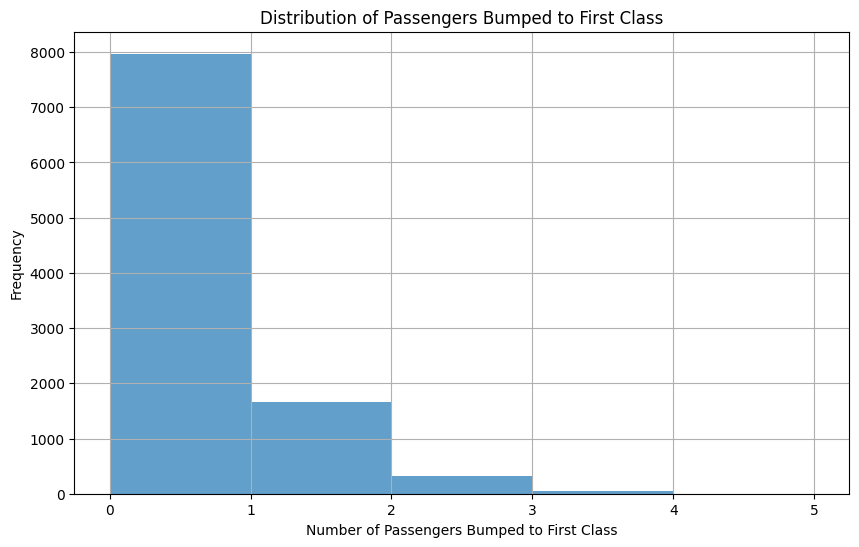

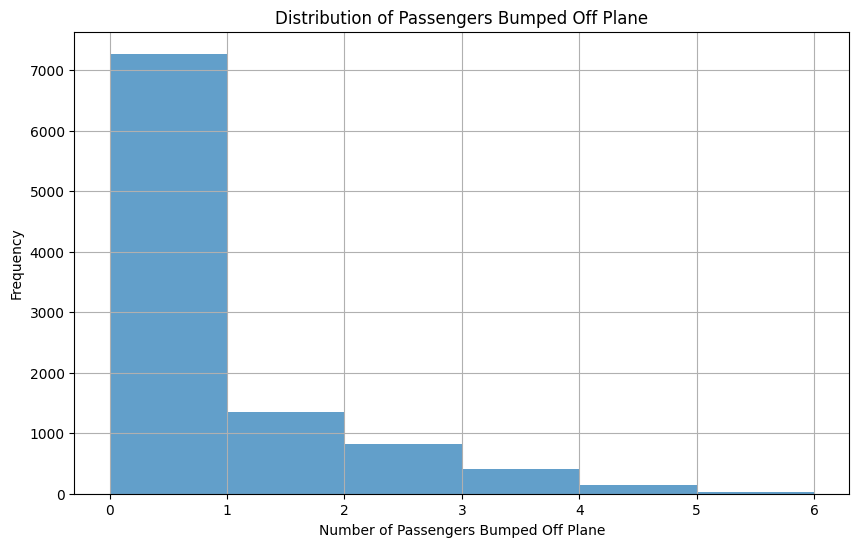

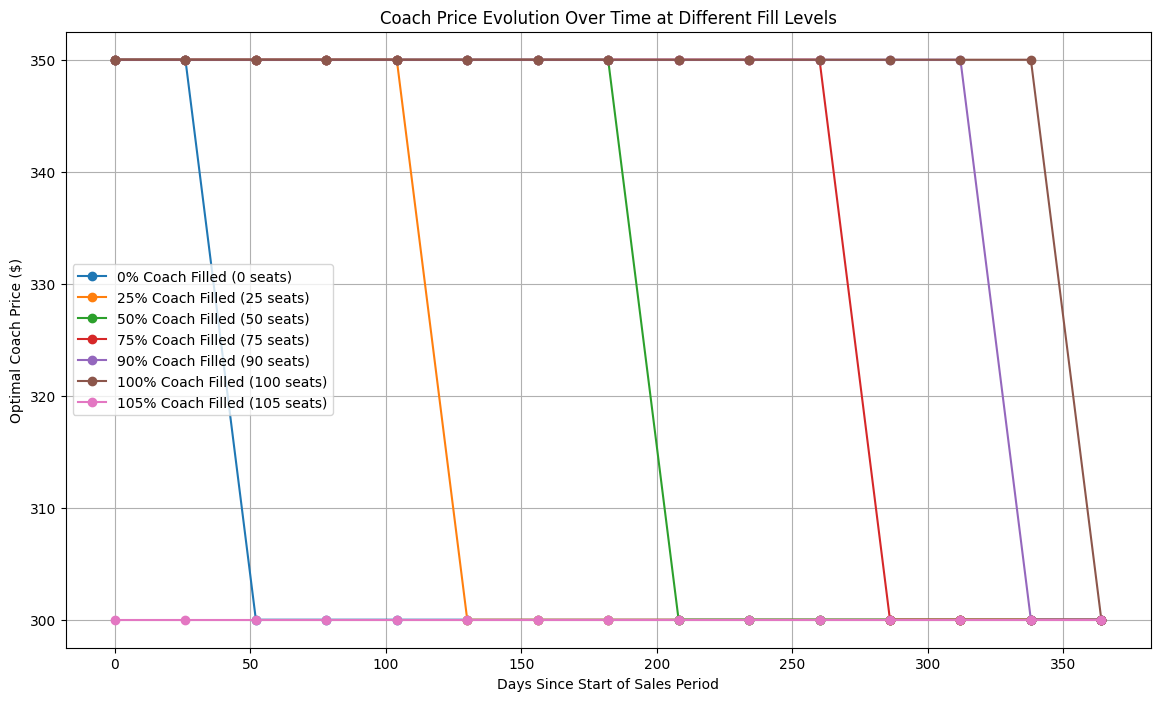

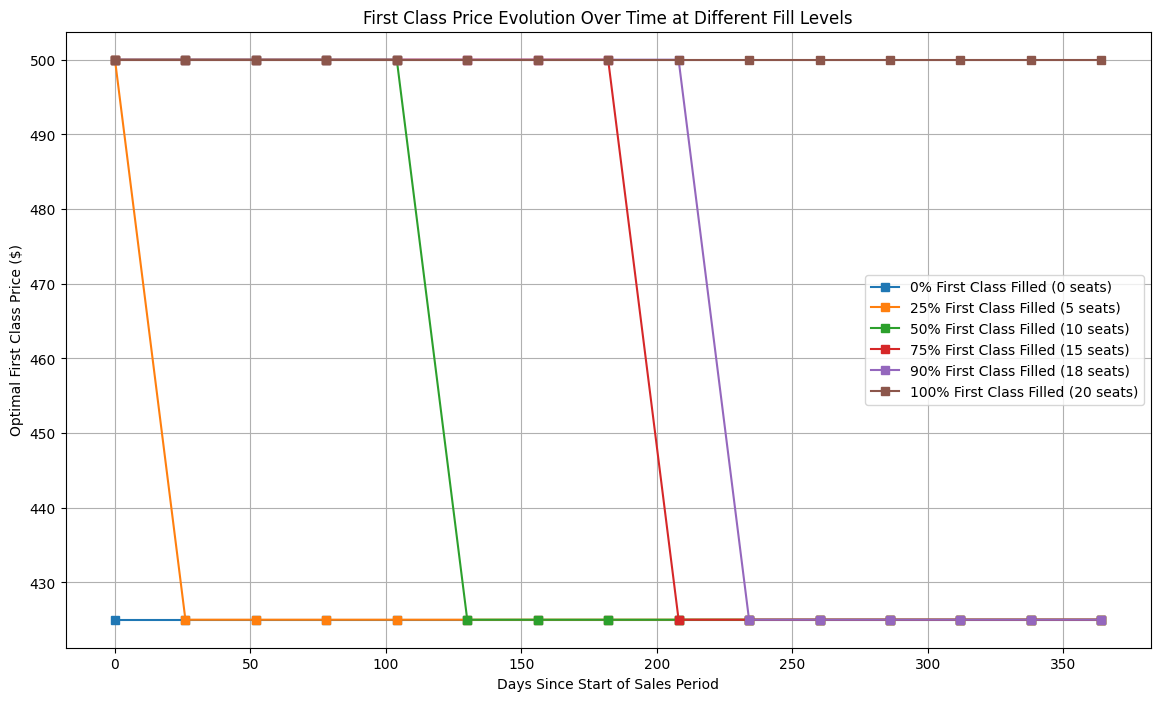

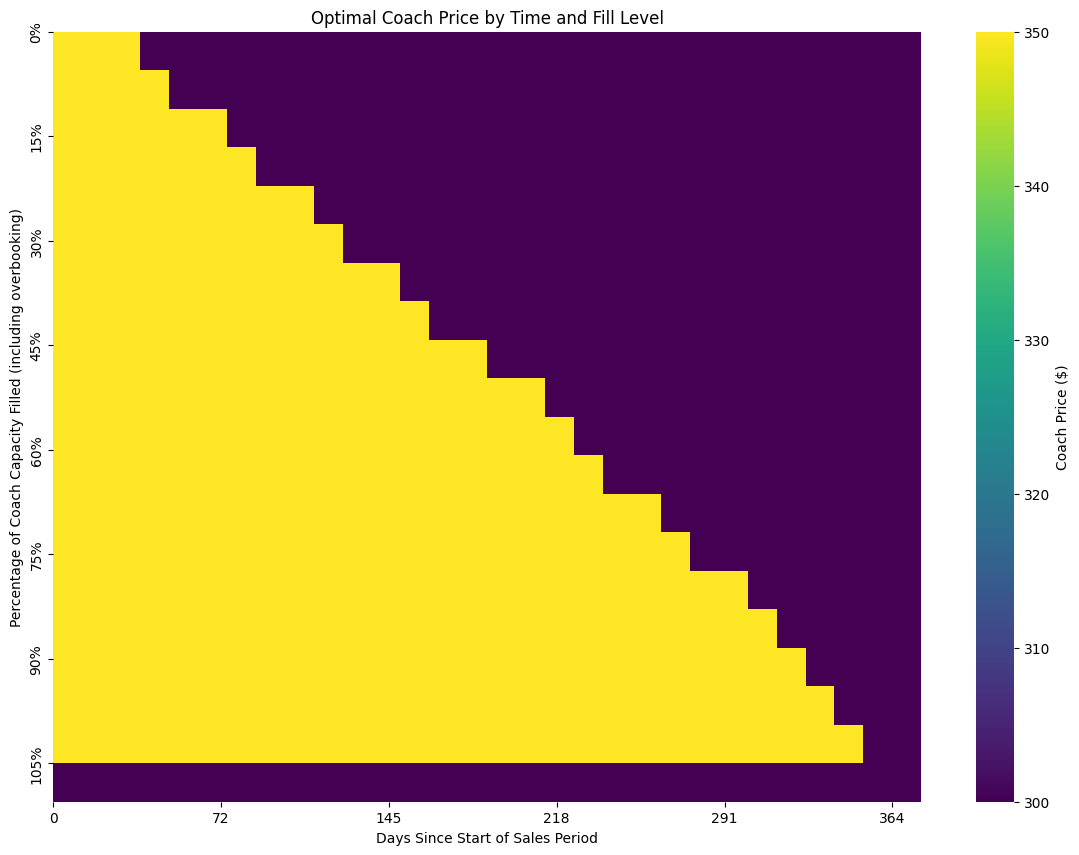

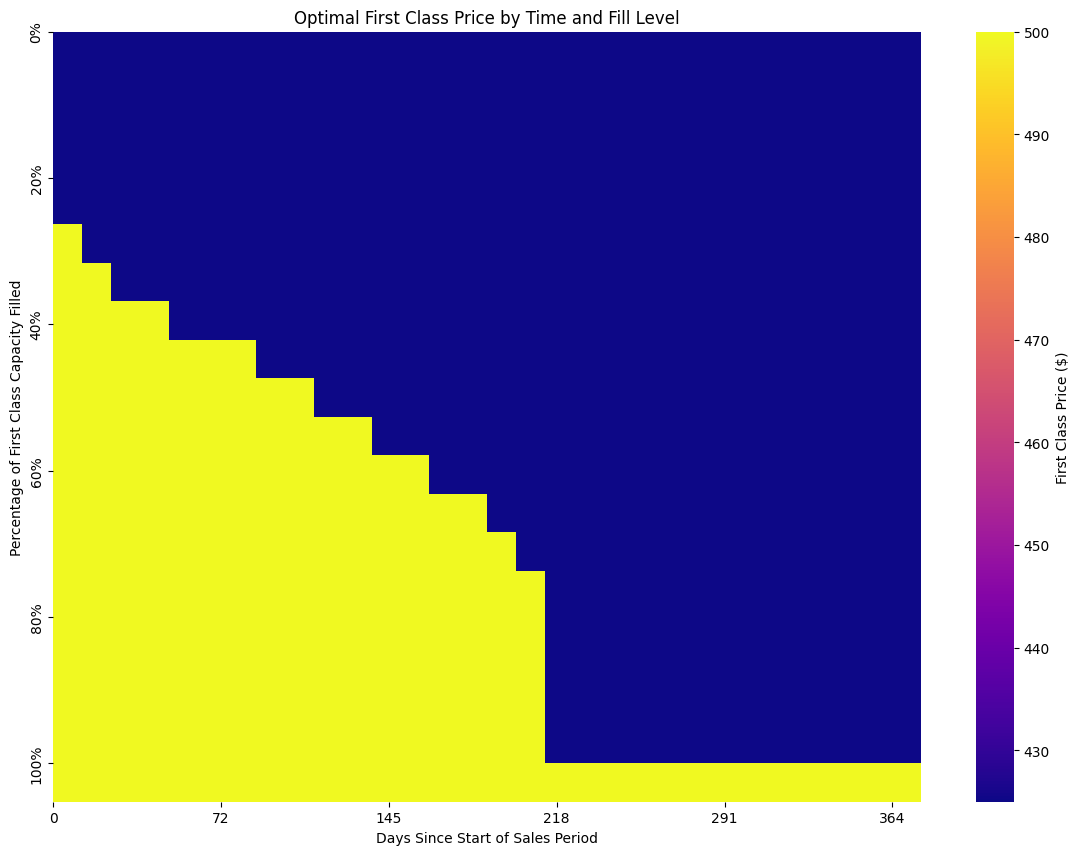

In [15]:
import numpy as np
from scipy.stats import binom
import matplotlib.pyplot as plt
import seaborn as sns
import time

def airline_dp_solution():
    """
    Solve the airline ticket pricing problem using dynamic programming,
    with corrected transition probability calculations and fixed visualizations.
    Enforces high price for first class when it's sold out.
    """
    print("Starting airline ticket dynamic programming solution...")
    start_time = time.time()
    
    # Step 1: Initialize Parameters
    # Seat configuration
    coach_seats = 100
    first_class_seats = 20
    max_coach_overbooking = 5
    max_coach_tickets = coach_seats + max_coach_overbooking  # 105
    
    # Time horizon
    days_until_takeoff = 365
    
    # Pricing options
    coach_prices = [300, 350]
    first_class_prices = [425, 500]
    
    # Sale probabilities
    coach_sale_prob = {
        300: 0.65,
        350: 0.30
    }
    # When first class is sold out
    coach_sale_prob_fc_sold_out = {
        300: 0.68,
        350: 0.33
    }
    first_class_sale_prob = {
        425: 0.08,
        500: 0.04
    }
    
    # Show-up probabilities
    coach_show_prob = 0.95
    first_class_show_prob = 0.97
    
    # Overbooking costs
    cost_bump_to_first_class = 50
    cost_bump_off_plane = 425
    
    # Discount rate
    annual_discount_rate = 0.17
    daily_discount_factor = 1 / (1 + annual_discount_rate / 365)
    
    print(f"Daily discount factor: {daily_discount_factor}")
    
    # Initialize state values and policy
    V = np.zeros((max_coach_tickets + 1, first_class_seats + 1, days_until_takeoff + 1))
    policy = np.zeros((max_coach_tickets + 1, first_class_seats + 1, days_until_takeoff + 1), dtype=int)
    
    # Step 2: Terminal day costs (day 365)
    print("Calculating terminal values...")
    
    # Terminal cost statistics
    terminal_cost_data = []
    
    for coach_sold in range(max_coach_tickets + 1):
        for fc_sold in range(first_class_seats + 1):
            # Calculate expected overbooking costs using binomial distribution
            cost = 0
            expected_bumped_to_fc = 0
            expected_bumped_off = 0
            
            # Generate all possible combinations of show-ups
            for coach_show in range(coach_sold + 1):
                coach_prob = binom.pmf(coach_show, coach_sold, coach_show_prob)
                
                for fc_show in range(fc_sold + 1):
                    fc_prob = binom.pmf(fc_show, fc_sold, first_class_show_prob)
                    
                    # Calculate probability of this exact scenario
                    scenario_prob = coach_prob * fc_prob
                    
                    # If coach is overbooked
                    if coach_show > coach_seats:
                        # Number of passengers to be bumped
                        bumped = coach_show - coach_seats
                        
                        # Available first class seats
                        available_fc = max(0, first_class_seats - fc_show)
                        
                        # Bump to first class if possible, otherwise off the plane
                        bumped_to_fc = min(bumped, available_fc)
                        bumped_off = bumped - bumped_to_fc
                        
                        # Track expected bumping for statistics
                        expected_bumped_to_fc += scenario_prob * bumped_to_fc
                        expected_bumped_off += scenario_prob * bumped_off
                        
                        # Calculate costs
                        scenario_cost = (bumped_to_fc * cost_bump_to_first_class) + (bumped_off * cost_bump_off_plane)
                        cost += scenario_prob * scenario_cost
            
            # Store terminal cost data for visualization
            if coach_sold >= 95:  # Only store for near-capacity situations
                terminal_cost_data.append({
                    'coach_sold': coach_sold,
                    'fc_sold': fc_sold,
                    'expected_cost': cost,
                    'expected_bumped_to_fc': expected_bumped_to_fc,
                    'expected_bumped_off': expected_bumped_off
                })
                
            V[coach_sold, fc_sold, -1] = -cost  # Negative because costs reduce value
    
    # Step 3: Backward induction - CORRECTED IMPLEMENTATION
    print("Starting backward induction with corrected transition probabilities...")
    
    for day in range(days_until_takeoff - 1, -1, -1):
        if day % 50 == 0:
            print(f"Processing day {day}...")
            
        for coach_sold in range(max_coach_tickets + 1):
            for fc_sold in range(first_class_seats + 1):
                # Skip impossible states
                if coach_sold > max_coach_tickets or fc_sold > first_class_seats:
                    continue
                
                # Special handling for the case when first class is full
                if fc_sold == first_class_seats:
                    # When first class is sold out, we always use high price (index 1)
                    # We only need to decide on coach price
                    best_value = float('-inf')
                    best_action = -1
                    
                    # Try both coach prices with high FC price
                    for c_idx, coach_price in enumerate(coach_prices):
                        action = c_idx * 2 + 1  # Force high first class price (index 1)
                        
                        # Check coach availability
                        coach_available = coach_sold < max_coach_tickets
                        
                        # Calculate expected value
                        expected_revenue = 0
                        if coach_available:
                            # Use the increased probability when FC is sold out
                            c_prob = coach_sale_prob_fc_sold_out[coach_price]
                            expected_revenue += c_prob * coach_price
                        
                        # Calculate expected future value
                        expected_future_value = 0
                        
                        if not coach_available:
                            # If coach is also full, just move to next day
                            expected_future_value = V[coach_sold, fc_sold, day + 1]
                        else:
                            # Calculate probabilities for future states
                            prob_no_sale = 1 - c_prob
                            expected_future_value += prob_no_sale * V[coach_sold, fc_sold, day + 1]
                            
                            if coach_available:
                                expected_future_value += c_prob * V[coach_sold + 1, fc_sold, day + 1]
                        
                        # Calculate total value
                        current_value = expected_revenue + daily_discount_factor * expected_future_value
                        
                        if current_value > best_value:
                            best_value = current_value
                            best_action = action
                    
                    # Store best value and action
                    V[coach_sold, fc_sold, day] = best_value
                    policy[coach_sold, fc_sold, day] = best_action
                else:
                    # Regular processing for non-full first class
                    # Initialize for this state
                    best_value = float('-inf')
                    best_action = 0
                    
                    # Check availability
                    coach_available = coach_sold < max_coach_tickets
                    fc_available = fc_sold < first_class_seats
                    
                    # If both are sold out, just move to next day
                    if not coach_available and not fc_available:
                        V[coach_sold, fc_sold, day] = daily_discount_factor * V[coach_sold, fc_sold, day + 1]
                        continue
                    
                    # Try all pricing combinations (actions)
                    for c_idx, coach_price in enumerate(coach_prices):
                        for f_idx, fc_price in enumerate(first_class_prices):
                            action = c_idx * 2 + f_idx
                            
                            # CORRECTED: Calculate expected value properly without double-counting
                            
                            # Determine probabilities based on availability and pricing
                            c_prob = 0  # Coach sale probability
                            if coach_available:
                                if fc_sold == first_class_seats:  # This case is handled separately now
                                    c_prob = coach_sale_prob_fc_sold_out[coach_price]
                                else:
                                    c_prob = coach_sale_prob[coach_price]
                                    
                            f_prob = 0  # First class sale probability
                            if fc_available:
                                f_prob = first_class_sale_prob[fc_price]
                            
                            # Calculate expected immediate revenue
                            expected_revenue = 0
                            if coach_available:
                                expected_revenue += c_prob * coach_price
                            if fc_available:
                                expected_revenue += f_prob * fc_price
                            
                            # Calculate expected future value considering all possible combinations
                            # NOTE: We calculate this ONCE, not separately for each ticket type
                            expected_future_value = 0
                            
                            # Case 1: Neither ticket sells
                            prob_neither = (1 - c_prob if coach_available else 1) * (1 - f_prob if fc_available else 1)
                            expected_future_value += prob_neither * V[coach_sold, fc_sold, day + 1]
                            
                            # Case 2: Only coach sells
                            if coach_available:
                                prob_only_coach = c_prob * (1 - f_prob if fc_available else 1)
                                expected_future_value += prob_only_coach * V[coach_sold + 1, fc_sold, day + 1]
                            
                            # Case 3: Only first class sells
                            if fc_available:
                                prob_only_fc = (1 - c_prob if coach_available else 1) * f_prob
                                expected_future_value += prob_only_fc * V[coach_sold, fc_sold + 1, day + 1]
                            
                            # Case 4: Both sell
                            if coach_available and fc_available:
                                prob_both = c_prob * f_prob
                                expected_future_value += prob_both * V[coach_sold + 1, fc_sold + 1, day + 1]
                            
                            # Total expected value = immediate revenue + discounted future value
                            current_value = expected_revenue + daily_discount_factor * expected_future_value
                            
                            # Update if this is the best action
                            if current_value > best_value:
                                best_value = current_value
                                best_action = action
                    
                    # Store best value and action
                    V[coach_sold, fc_sold, day] = best_value
                    policy[coach_sold, fc_sold, day] = best_action
    
    elapsed_time = time.time() - start_time
    print(f"Dynamic programming solution completed in {elapsed_time:.2f} seconds")
    
    # Step 4: Run a simulation to validate and collect detailed statistics
    def simulate_flights(num_simulations=10000):
        """Simulate flights using the optimal policy and collect detailed statistics."""
        print(f"Running {num_simulations} simulations with detailed statistics...")
        
        total_revenue = 0
        
        # Statistics tracking
        coach_tickets_sold = []
        fc_tickets_sold = []
        bumped_to_fc_counts = []
        bumped_off_counts = []
        total_bumped_counts = []
        overbooking_costs = []
        ticket_revenues = []
        
        # Helper function to convert action to prices
        def get_prices(action):
            coach_idx = action // 2
            fc_idx = action % 2
            return coach_prices[coach_idx], first_class_prices[fc_idx]
        
        for sim in range(num_simulations):
            if sim % 1000 == 0 and sim > 0:
                print(f"Completed {sim} simulations...")
                
            # Starting state
            coach_sold = 0
            fc_sold = 0
            ticket_revenue = 0
            
            # Daily ticket sales
            for day in range(days_until_takeoff):
                # Get optimal pricing for current state
                action = policy[coach_sold, fc_sold, day]
                coach_price, fc_price = get_prices(action)
                
                # Coach sales
                if coach_sold < max_coach_tickets:
                    # Determine probability based on first class availability
                    if fc_sold == first_class_seats:
                        sale_prob = coach_sale_prob_fc_sold_out[coach_price]
                    else:
                        sale_prob = coach_sale_prob[coach_price]
                    
                    # Simulate sale
                    if np.random.random() < sale_prob:
                        coach_sold += 1
                        ticket_revenue += coach_price * (daily_discount_factor ** day)
                
                # First class sales
                if fc_sold < first_class_seats:
                    # Determine probability
                    sale_prob = first_class_sale_prob[fc_price]
                    
                    # Simulate sale
                    if np.random.random() < sale_prob:
                        fc_sold += 1
                        ticket_revenue += fc_price * (daily_discount_factor ** day)
            
            # Record tickets sold
            coach_tickets_sold.append(coach_sold)
            fc_tickets_sold.append(fc_sold)
            ticket_revenues.append(ticket_revenue)
            
            # Flight day costs (overbooking)
            coach_show = np.random.binomial(coach_sold, coach_show_prob)
            fc_show = np.random.binomial(fc_sold, first_class_show_prob)
            
            # Initialize bumping counters
            bumped_to_fc = 0
            bumped_off = 0
            flight_overbooking_cost = 0
            
            # Calculate overbooking costs
            if coach_show > coach_seats:
                # Total passengers to bump
                to_bump = coach_show - coach_seats
                
                # Available first class seats
                available_fc = max(0, first_class_seats - fc_show)
                
                # How many get bumped to each category
                bumped_to_fc = min(to_bump, available_fc)
                bumped_off = to_bump - bumped_to_fc
                
                # Calculate costs
                flight_overbooking_cost = (bumped_to_fc * cost_bump_to_first_class) + (bumped_off * cost_bump_off_plane)
                
                # Apply discount factor for final day
                discounted_cost = flight_overbooking_cost * (daily_discount_factor ** days_until_takeoff)
                ticket_revenue -= discounted_cost
            
            # Record bumping statistics
            bumped_to_fc_counts.append(bumped_to_fc)
            bumped_off_counts.append(bumped_off)
            total_bumped_counts.append(bumped_to_fc + bumped_off)
            overbooking_costs.append(flight_overbooking_cost)
            
            # Add to total revenue
            total_revenue += ticket_revenue
        
        # Calculate summary statistics
        avg_coach_sold = np.mean(coach_tickets_sold)
        avg_fc_sold = np.mean(fc_tickets_sold)
        avg_bumped_to_fc = np.mean(bumped_to_fc_counts)
        avg_bumped_off = np.mean(bumped_off_counts)
        avg_total_bumped = np.mean(total_bumped_counts)
        avg_overbooking_cost = np.mean(overbooking_costs)
        avg_ticket_revenue = np.mean(ticket_revenues)
        
        # Calculate percentages
        pct_flights_with_bumping = 100 * np.sum(np.array(total_bumped_counts) > 0) / num_simulations
        total_coach_passengers = np.sum(np.array(coach_tickets_sold) * coach_show_prob)
        pct_coach_passengers_bumped = 100 * np.sum(total_bumped_counts) / total_coach_passengers if total_coach_passengers > 0 else 0
        
        # Print detailed statistics
        print("\nDetailed Bumping Statistics:")
        print(f"Average coach tickets sold: {avg_coach_sold:.2f} out of {max_coach_tickets}")
        print(f"Average first class tickets sold: {avg_fc_sold:.2f} out of {first_class_seats}")
        print(f"Average passengers bumped to first class: {avg_bumped_to_fc:.4f}")
        print(f"Average passengers bumped off plane: {avg_bumped_off:.4f}")
        print(f"Average total passengers bumped: {avg_total_bumped:.4f}")
        print(f"Percentage of flights with any bumping: {pct_flights_with_bumping:.2f}%")
        print(f"Percentage of coach passengers bumped: {pct_coach_passengers_bumped:.4f}%")
        print(f"Average overbooking cost per flight: ${avg_overbooking_cost:.2f}")
        print(f"Average ticket revenue per flight: ${avg_ticket_revenue:.2f}")
        
        # Create visualizations
        
        # 1. Histogram of number of passengers bumped to first class
        plt.figure(figsize=(10, 6))
        plt.hist(bumped_to_fc_counts, bins=range(max(bumped_to_fc_counts)+2), alpha=0.7)
        plt.xlabel('Number of Passengers Bumped to First Class')
        plt.ylabel('Frequency')
        plt.title('Distribution of Passengers Bumped to First Class')
        plt.grid(True)
        plt.savefig('bumped_to_fc_histogram.png')
        
        # 2. Histogram of number of passengers bumped off plane
        plt.figure(figsize=(10, 6))
        plt.hist(bumped_off_counts, bins=range(max(bumped_off_counts)+2), alpha=0.7)
        plt.xlabel('Number of Passengers Bumped Off Plane')
        plt.ylabel('Frequency')
        plt.title('Distribution of Passengers Bumped Off Plane')
        plt.grid(True)
        plt.savefig('bumped_off_histogram.png')
        
        # Statistics dictionary
        statistics = {
            'avg_coach_sold': avg_coach_sold,
            'avg_fc_sold': avg_fc_sold,
            'avg_bumped_to_fc': avg_bumped_to_fc,
            'avg_bumped_off': avg_bumped_off,
            'avg_total_bumped': avg_total_bumped,
            'pct_flights_with_bumping': pct_flights_with_bumping,
            'pct_coach_passengers_bumped': pct_coach_passengers_bumped,
            'avg_overbooking_cost': avg_overbooking_cost,
            'avg_ticket_revenue': avg_ticket_revenue,
            'coach_tickets_sold': coach_tickets_sold,
            'fc_tickets_sold': fc_tickets_sold,
            'bumped_to_fc_counts': bumped_to_fc_counts,
            'bumped_off_counts': bumped_off_counts,
            'total_bumped_counts': total_bumped_counts,
            'overbooking_costs': overbooking_costs,
            'ticket_revenues': ticket_revenues
        }
        
        return total_revenue / num_simulations, statistics
    
    # Get the expected profit from DP solution
    expected_profit = V[0, 0, 0]
    print(f"Expected profit from corrected DP solution: ${expected_profit:.2f}")
    
    # Validate with simulation and collect statistics
    simulated_profit, statistics = simulate_flights(10000)
    print(f"Expected profit from simulation: ${simulated_profit:.2f}")
    print(f"Difference: ${abs(expected_profit - simulated_profit):.2f}")
    
    # Create fixed visualizations with correct axes
    def create_fixed_visualizations():
        """
        Create visualizations with properly fixed axes showing pricing strategy
        evolution over time.
        """
        print("Creating fixed visualizations...")
        
        # Helper function to get prices from action
        def get_prices(action):
            coach_idx = action // 2
            fc_idx = action % 2
            return coach_prices[coach_idx], first_class_prices[fc_idx]
        
        # 1. Price evolution over time at different inventory levels
        days_to_check = np.linspace(0, days_until_takeoff-1, 15, dtype=int)  # 15 time points
        
        # Define inventory levels to check (percentage of capacity filled)
        # For coach: 0%, 25%, 50%, 75%, 90%, 100%, 105% (max with overbooking)
        # For first class: 0%, 25%, 50%, 75%, 90%, 100% (max capacity)
        coach_fill_levels = [0.0, 0.25, 0.50, 0.75, 0.90, 1.0, 1.05]
        fc_fill_levels = [0.0, 0.25, 0.50, 0.75, 0.90, 1.0]
        
        # Prepare arrays for the data
        coach_price_data = np.zeros((len(coach_fill_levels), len(days_to_check)))
        fc_price_data = np.zeros((len(fc_fill_levels), len(days_to_check)))
        
        # Fill the arrays with pricing data for coach
        for i, fill_level in enumerate(coach_fill_levels):
            coach_sold = min(int(fill_level * coach_seats), max_coach_tickets)
            fc_sold = 0  # Start with no first class tickets sold
            
            for j, day in enumerate(days_to_check):
                action = policy[coach_sold, fc_sold, day]
                coach_price, _ = get_prices(action)
                coach_price_data[i, j] = coach_price
        
        # Fill the arrays with pricing data for first class
        for i, fill_level in enumerate(fc_fill_levels):
            fc_sold = min(int(fill_level * first_class_seats), first_class_seats)
            coach_sold = 0  # Start with no coach tickets sold
            
            for j, day in enumerate(days_to_check):
                action = policy[coach_sold, fc_sold, day]
                _, fc_price = get_prices(action)
                fc_price_data[i, j] = fc_price
        
        # Plot coach price evolution
        plt.figure(figsize=(14, 8))
        for i, fill_level in enumerate(coach_fill_levels):
            plt.plot(days_to_check, coach_price_data[i], 'o-', 
                    label=f"{int(fill_level*100)}% Coach Filled ({int(fill_level*coach_seats)} seats)")
        
        plt.xlabel('Days Since Start of Sales Period')
        plt.ylabel('Optimal Coach Price ($)')
        plt.title('Coach Price Evolution Over Time at Different Fill Levels')
        plt.grid(True)
        plt.legend()
        plt.savefig('coach_price_evolution_by_fill.png')
        
        # Plot first class price evolution
        plt.figure(figsize=(14, 8))
        for i, fill_level in enumerate(fc_fill_levels):
            plt.plot(days_to_check, fc_price_data[i], 's-', 
                    label=f"{int(fill_level*100)}% First Class Filled ({int(fill_level*first_class_seats)} seats)")
        
        plt.xlabel('Days Since Start of Sales Period')
        plt.ylabel('Optimal First Class Price ($)')
        plt.title('First Class Price Evolution Over Time at Different Fill Levels')
        plt.grid(True)
        plt.legend()
        plt.savefig('fc_price_evolution_by_fill.png')
        
        # 2. Create price heatmaps with PROPERLY FIXED AXES
        
        # For days, use evenly spaced points from 0 to days_until_takeoff-1
        days_points = np.linspace(0, days_until_takeoff-1, 30, dtype=int)
        
        # For coach fill levels, use points from 0% to 105% (accounting for overbooking)
        coach_fill_points = np.linspace(0, max_coach_tickets/coach_seats, 20)
        
        # For first class fill levels, use points from 0% to 100%
        fc_fill_points = np.linspace(0, 1.0, 20)
        
        # Arrays for heatmaps
        coach_heatmap = np.zeros((len(coach_fill_points), len(days_points)))
        fc_heatmap = np.zeros((len(fc_fill_points), len(days_points)))
        
        # Fill the coach heatmap data
        for i, fill in enumerate(coach_fill_points):
            coach_sold = min(int(fill * coach_seats), max_coach_tickets)
            fc_sold = 0  # Keep first class empty to isolate coach effect
            
            for j, day in enumerate(days_points):
                action = policy[coach_sold, fc_sold, day]
                coach_price, _ = get_prices(action)
                coach_heatmap[i, j] = coach_price
        
        # Fill the first class heatmap data
        for i, fill in enumerate(fc_fill_points):
            fc_sold = min(int(fill * first_class_seats), first_class_seats)
            coach_sold = 0  # Keep coach empty to isolate first class effect
            
            for j, day in enumerate(days_points):
                action = policy[coach_sold, fc_sold, day]
                _, fc_price = get_prices(action)
                fc_heatmap[i, j] = fc_price
        
        # Create coach price heatmap with PROPERLY FIXED AXES
        plt.figure(figsize=(14, 10))
        
        # Create the heatmap without automatic tick labels
        ax = sns.heatmap(coach_heatmap, cmap='viridis', cbar_kws={'label': 'Coach Price ($)'})
        
        # Explicitly set the tick locations and labels
        x_ticks = np.linspace(0, len(days_points)-1, 6)  # 6 evenly spaced ticks
        x_labels = [f"{int(d)}" for d in np.linspace(0, days_until_takeoff-1, 6)]  # 0, 73, 146, 219, 292, 365
        
        y_ticks = np.linspace(0, len(coach_fill_points)-1, 8)  # 8 evenly spaced ticks
        y_labels = [f"{int(p)}%" for p in np.linspace(0, 105, 8)]  # 0%, 15%, 30%, ..., 105%
        
        # Set the tick positions and labels
        plt.xticks(x_ticks, x_labels)
        plt.yticks(y_ticks, y_labels)
        
        plt.xlabel('Days Since Start of Sales Period')
        plt.ylabel('Percentage of Coach Capacity Filled (including overbooking)')
        plt.title('Optimal Coach Price by Time and Fill Level')
        plt.savefig('coach_price_heatmap_fixed.png')
        
        # Create first class price heatmap with PROPERLY FIXED AXES
        plt.figure(figsize=(14, 10))
        
        # Create the heatmap without automatic tick labels
        ax = sns.heatmap(fc_heatmap, cmap='plasma', cbar_kws={'label': 'First Class Price ($)'})
        
        # Explicitly set the tick locations and labels
        x_ticks = np.linspace(0, len(days_points)-1, 6)  # 6 evenly spaced ticks
        x_labels = [f"{int(d)}" for d in np.linspace(0, days_until_takeoff-1, 6)]  # 0, 73, 146, 219, 292, 365
        
        y_ticks = np.linspace(0, len(fc_fill_points)-1, 6)  # 6 evenly spaced ticks
        y_labels = [f"{int(p)}%" for p in np.linspace(0, 100, 6)]  # 0%, 20%, 40%, ..., 100%
        
        # Set the tick positions and labels
        plt.xticks(x_ticks, x_labels)
        plt.yticks(y_ticks, y_labels)
        
        plt.xlabel('Days Since Start of Sales Period')
        plt.ylabel('Percentage of First Class Capacity Filled')
        plt.title('Optimal First Class Price by Time and Fill Level')
        plt.savefig('fc_price_heatmap_fixed.png')
        
        print("Fixed visualizations created successfully!")
    
    # Create fixed visualizations
    create_fixed_visualizations()
    
    return {
        'expected_profit': expected_profit,
        'simulated_profit': simulated_profit,
        'value_function': V,
        'policy': policy,
        'statistics': statistics
    }

# Run the solution
results = airline_dp_solution()

# Output the final answer with detailed statistics on bumping
print("\n" + "="*50)
print("AIRLINE TICKET PRICING OPTIMIZATION RESULTS")
print("="*50)
print(f"Final Expected Discounted Profit: ${results['expected_profit']:.2f}")
print(f"Final Simulated Discounted Profit: ${results['simulated_profit']:.2f}")
print(f"Difference: ${abs(results['expected_profit'] - results['simulated_profit']):.2f}")
print("\nBUMPING STATISTICS SUMMARY:")
print(f"Average passengers bumped to first class per flight: {results['statistics']['avg_bumped_to_fc']:.4f}")
print(f"Average passengers bumped off plane per flight: {results['statistics']['avg_bumped_off']:.4f}")
print(f"Percentage of flights with any bumping: {results['statistics']['pct_flights_with_bumping']:.2f}%")
print(f"Percentage of coach passengers bumped: {results['statistics']['pct_coach_passengers_bumped']:.4f}%")
print(f"Average overbooking cost per flight: ${results['statistics']['avg_overbooking_cost']:.2f}")
print("="*50)